NOTEBOOK FIVE

# Set up and Config

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import seaborn as sns
import anndata as ad
import PyPDF2
import matplotlib.pyplot as plt
import statistics as st
from pathlib import Path
import scipy.stats as stats
from collections import defaultdict
from statannot import add_stat_annotation
import gseapy as gp
from gseapy.plot import barplot, dotplot
from gseapy.plot import gseaplot

In [2]:
#adata_processed = "/mnt/ibm_sm/home/lea.mcgeever/ms/notebooks/adata_files/adata_processed__02172022.h5ad"
adata_processed = "/mnt/ibm_sm/home/lea.mcgeever/ms/notebooks/adata_files/adata_processed_04192022.h5ad"
adata = sc.read_h5ad(adata_processed)

adata_kidney_processed = "/mnt/ibm_sm/home/lea.mcgeever/ms/notebooks/adata_files/adata_kidney_processed_05182022.h5ad"
tissue = sc.read_h5ad(adata_kidney_processed)


In [3]:
sc.settings.verbosity = 3             
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.20.1 scipy==1.6.2 pandas==1.2.4 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.9.8 pynndescent==0.5.5


In [4]:
'''Dictionary of Macrophages by Tissue'''

macrophages_in_tissues = {'Aorta':{'macrophage','professional antigen presenting cell'},
                         'BAT':{},
                         'Bladder':{},
                         'Brain_Myeloid':{'macrophage', 'microglial cell'},
                         'Brain_Non-Myeloid':{'macrophage', 'microglial cell'},
                         'Diaphragm':{'macrophage'},
                         'GAT':{} ,
                         'Heart':{'macrophage'},
                         'Kidney':{'macrophage'},
                         'Large_Intestine':{} ,
                         'Limb_Muscle':{'macrophage'},
                         'Liver':{'Kupffer cell'},
                         'Lung':{'lung macrophage'},
                         'MAT':{'macrophage'},
                         'Mammary_Gland': {},         
                         'Marrow':{'macrophage'},
                         'Pancreas':{} ,
                         'SCAT':{} ,
                         'Skin':{'macrophage'},
                         'Spleen':{} ,
                         'Thymus':{'macrophage'},
                         'Tongue':{} ,
                         'Trachea':{'macrophage'}
                        }

In [5]:
ages = ['3m','18m','24m']

In [6]:
dissociation_genes = ['Actg1','Btg1','Cxcl1','Dnajb4','Errfi1','H3f3b','Hspb1','Irf1','Klf6','Mir22hg','Nfkbia','Pcf11',
                      'Pxdc1','Sdc4','Srf','Tpm3','Usp2','Gadd45g','Ankrd1','Btg2','Cyr61','Dusp1','Erfe','Hipk3','Hsph1',
                      'Irf8','Klf9','Mt1','Nfkbiz','Pde4b','Rap1b','Serpine1','Srsf5','Tppp3','Wac','Hspe1','Arid5a','Ccnl1',
                      'Dcn','Dusp8','Fos','Hsp90aa1','Id3','Itpkc','Litaf','Mt2','Nop58','Per1','Rassf1','Skil','Srsf7','Tra2a',
                      'Zc3h12a','Ier5','Atf3','Noct','Ddx3x','Egr1','Fosb','Hsp90ab1','Idi1','Jun','Lmna','Myadm','Nppc',
                      'Phlda1','Rhob','Slc10a6','Stat3','Tra2b','Zfand5','Kcne4','Atf4','Cebpb','Ddx5','Egr2','Fosl2','Hspa1a',
                      'Ier2','Junb','Maff','Myc','Nr4a1','Pnp','Rhoh','Slc38a2','Tagln2','Trib1','Zfp36','Bag3','Cebpd','Des',
                      'Eif1','Gadd45a','Hspa1b','Ier3','Jund','Mafk','Myd88','Odc1','Pnrc1','Ripk1','Slc41a1','Tiparp','Tubb4b',
                      'Zfp36l1','Bhlhe40','Cebpg','Dnaja1','Eif5','Gcc1','Hspa5','Ifrd1','Klf2','Mcl1','Nckap5l','Osgin1',
                      'Ppp1cc','Sat1','Socs3','Tnfaip3','Tubb6','Zfp36l2','Brd2','Csrnp1','Dnajb1','Erf','Gem','Hspa8','Il6',
                      'Klf4','Midn','Ncoa7','Oxnad1','Ppp1r15a','Sbno2','Sqstm1','Tnfaip6','Ubc','Zyx']

In [7]:
len(dissociation_genes)

140

In [8]:
def remove_cats(adata):

    cat_columns = adata.obs.select_dtypes(['category']).columns
    adata.obs[cat_columns] = adata.obs[cat_columns].astype(str)
    
    return adata

In [9]:
def gene_expression_obs(adata, listy):
    '''Takes adata object. 
    Returns adata copy with var genes where genes 
    and their expression values are columns in dataframe of adata.'''
    adata2 = adata.copy()
    
    for j in listy:
        adata2.obs[j] = adata2[:,j].X.toarray().flatten()
    
    return adata2

In [10]:
def gene_expression_df(adata, genelist):
    '''Takes adata object of a tissue type and a list of genes. 
    Returns a pandas dataframe where genes and their expression values are columns in dataframe of adata.'''
    df = adata.obs.copy()
    
    for g in genelist:
        df[g] = adata[:,g].X.toarray().flatten()
    return df 

In [11]:
def GSEA_DataFrame(adata, age):
    ''' Input is adata object. Output is a pandas DataFrame 
    of names, scores, pvals, pvals_adj, logfoldchanges. 
    For inputting the age: 3m = 0, 18m = 1 or 24m = 2'''
    
    names = [] 
    scores = [] 
    pvals = []
    pvals_adj = []
    logfoldchanges = []
      
    for i,l in enumerate(list(adata.obs.index)):
        n = adata.uns['rank_genes_groups']['names'][i][age]
        s = adata.uns['rank_genes_groups']['scores'][i][age]
        p = adata.uns['rank_genes_groups']['pvals'][i][age]
        pa = adata.uns['rank_genes_groups']['pvals_adj'][i][age]
        l = adata.uns['rank_genes_groups']['logfoldchanges'][i][age]

        names.append(n)
        scores.append(s)
        pvals.append(p)
        pvals_adj.append(pa)
        logfoldchanges.append(l)
        
    dictionary = {'names':names,
                    'scores':scores,
                    'pvals': pvals,
                    'pvals_adj': pvals_adj,
                    'logfoldchanges': logfoldchanges
                 }
    df = pd.DataFrame(dictionary)
    return df

# Brain_Myeloid, no enrichment

In [20]:
adata_Brain_Myeloid = adata[adata.obs['tissue'] == "Brain_Myeloid"].copy()
sc.pp.pca(adata_Brain_Myeloid)
sc.pp.neighbors(adata_Brain_Myeloid, n_pcs=9)
sc.tl.leiden(adata_Brain_Myeloid) 
sc.tl.umap(adata_Brain_Myeloid)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 9
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:11)
running Leiden clustering
    finished: found 13 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:11)


In [22]:
# macrophage
BM_mac = adata_Brain_Myeloid[adata_Brain_Myeloid.obs['cell_ontology_class'].isin(['macrophage'])]
sc.pp.pca(BM_mac)
sc.pp.neighbors(BM_mac, n_pcs=9)
sc.tl.leiden(BM_mac) 
sc.tl.umap(BM_mac)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 9
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 9 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)
Filtering genes using: min_in_group_fraction: 0.25 min_fold_change: 2, max_out_group_fraction: 0.5


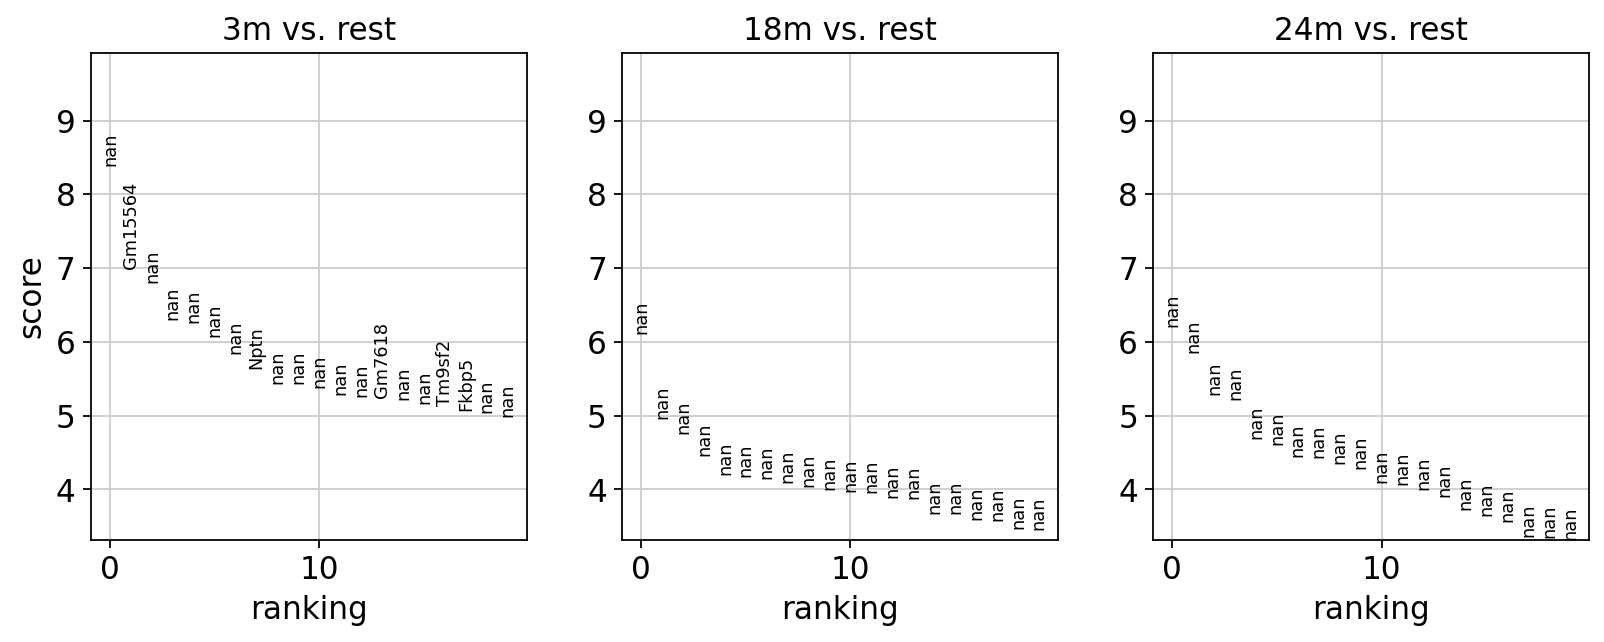

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_age']`


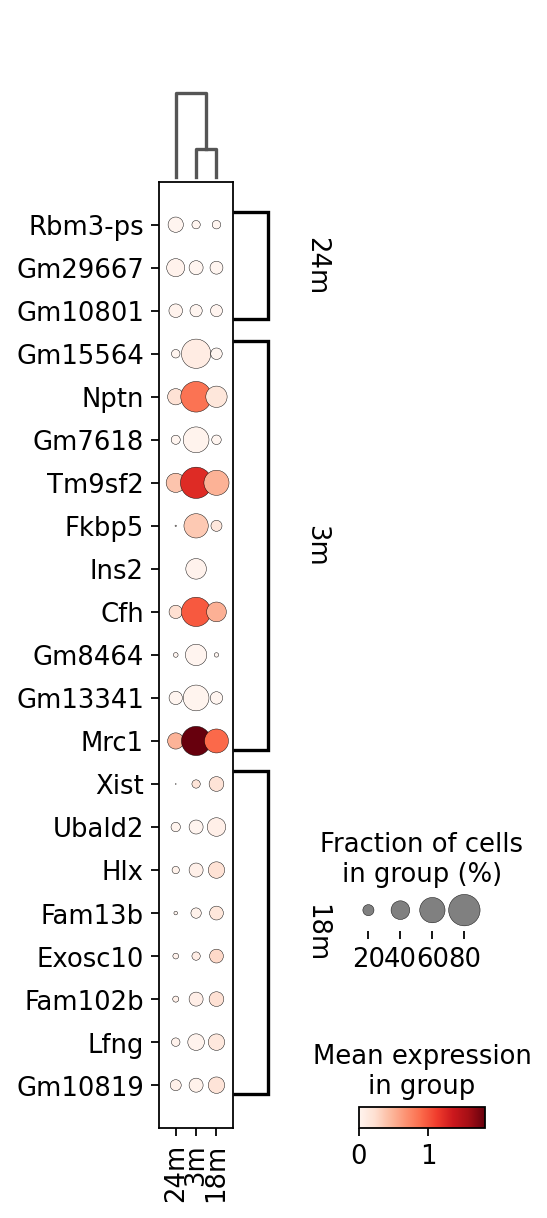

In [23]:
sc.tl.rank_genes_groups(BM_mac, groupby = 'age', method = 'wilcoxon', pts = True)
sc.tl.filter_rank_genes_groups(BM_mac, min_fold_change=2)
sc.pl.rank_genes_groups(BM_mac, key='rank_genes_groups_filtered')
sc.pl.rank_genes_groups_dotplot(BM_mac, key='rank_genes_groups_filtered', swap_axes=True)

## 3m Brain_Myeloid

In [29]:
df = GSEA_DataFrame(BM_mac, '3m')
df_adj = df[df['logfoldchanges']>=0.7]
Brain_Myeloid_3m_sig = list(df_adj['names'])
df_adj

names    scores         pvals     pvals_adj  logfoldchanges
0      Rps29  8.391817  4.786853e-17  2.595049e-12        2.062242
1    Gm15564  6.988245  2.783446e-12  7.544809e-08        5.035502
2    Gm10736  6.806630  9.991126e-12  1.805463e-07        1.913418
3      Rps21  6.295343  3.067201e-10  3.325582e-06        1.427228
4    Serinc3  6.261784  3.805979e-10  3.438829e-06        1.908526
..       ...       ...           ...           ...             ...
281     Cct8  2.789376  5.280971e-03  9.176025e-01        0.873535
282  Tubgcp5  2.789376  5.280971e-03  9.176025e-01        1.328360
283    Csf1r  2.784441  5.362010e-03  9.287070e-01        1.052237
284   Ccdc12  2.781480  5.411171e-03  9.342370e-01        0.956861
286    Ncoa3  2.774570  5.527466e-03  9.482753e-01        1.072484

[244 rows x 5 columns]

In [30]:
#macrophages
enr_Brain_Myeloid_3m = gp.enrichr(gene_list= Brain_Myeloid_3m_sig,
                 gene_sets=[#'WikiPathways_2019_Mouse',
                            'KEGG_2019_Mouse',
                            'GO_Cellular_Component_2021',
                            'GO_Biological_Process_2021',
                            'GO_Molecular_Function_2021',
                            'GTEx_Aging_Signatures_2021',
                            #'HDSigDB_Mouse_2021',
                            'Mouse_Gene_Atlas'],
                 organism='Mouse', # don't forget to set organism to the one you desired! e.g. Yeast
                 description='test_name',
                 outdir='test/enrichr_kegg',
                 no_plot=False,
                 cutoff=1.0 # test dataset, use lower value from range(0,1)
                )

df = enr_Brain_Myeloid_3m.results
df = df[df['Adjusted P-value'] <= 0.05].copy() 
df

Gene_set  \
0                KEGG_2019_Mouse   
1                KEGG_2019_Mouse   
2                KEGG_2019_Mouse   
3                KEGG_2019_Mouse   
4                KEGG_2019_Mouse   
...                          ...   
421   GO_Biological_Process_2021   
422   GO_Biological_Process_2021   
2228  GO_Molecular_Function_2021   
2229  GO_Molecular_Function_2021   
2650            Mouse_Gene_Atlas   

                                                   Term  Overlap  \
0                                              Ribosome   13/170   
1             Non-alcoholic fatty liver disease (NAFLD)    9/151   
2                                         Thermogenesis   11/231   
3                                              Lysosome    8/124   
4           Protein processing in endoplasmic reticulum    9/163   
...                                                 ...      ...   
421   cellular response to organic cyclic compound (...    8/150   
422   regulation of cellular amide metabolic process...     4/32   
2228                           RNA binding (GO:0003723)  37/1406   
2229  oxidoreduction-driven active transmembrane tra...     6/58   
2650                         macrophage bone marrow 0hr   10/180   

           P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
0     1.759304e-07          0.000037            0                     0   
1     1.014124e-04          0.007492            0                     0   
2     1.328651e-04          0.007492            0                     0   
3     1.427078e-04          0.007492            0                     0   
4     1.811808e-04          0.007610            0                     0   
...            ...               ...          ...                   ...   
421   5.199586e-04          0.045236            0                     0   
422   5.941687e-04          0.049343            0                     0   
2228  7.741026e-06          0.002469            0                     0   
2229  7.382665e-05          0.011775            0                     0   
2650  7.577086e-05          0.006289            0                     0   

      Odds Ratio  Combined Score  \
0       7.025312      109.265929   
1       5.289961       48.648149   
2       4.192275       37.420984   
3       5.739334       50.820142   
4       4.874772       42.001110   
...          ...             ...   
421     4.682263       35.406156   
422    11.742857       87.230020   
2228    2.400705       28.253841   
2229    9.552683       90.882224   
2650    4.923580       46.713923   

                                                  Genes  
0     RPL41;RPS26;RPS17;RPS28;RPS27;RPS29;MT-RNR2;MT...  
1     INS1;COX7B;NDUFS7;UQCRQ;INS2;NDUFA3;NDUFA2;COX...  
2     COX7B;NDUFS7;UQCRQ;NDUFA3;NDUFA2;ATP5K;GCG;COX...  
3         CD164;HGSNAT;ASAH1;CLTC;AP1B1;IDS;MAN2B1;GUSB  
4     PDIA3;TRAM1;MAN1A2;SEC61G;SSR3;CANX;RAD23B;PDI...  
...                                                 ...  
421   P2RY12;JUP;NCOA3;NRIP1;CTNNA1;ATP1A1;ACTB;HSP90B1  
422                             APP;CYFIP1;PCIF1;PICALM  
2228  ANKRD17;MACF1;ANP32A;DHX9;CLTC;AKAP8;HDLBP;HSP...  
2229            NDUFS7;UQCRQ;NDUFA3;NDUFA2;COX6A1;COX5B  
2650  CSF1R;DAB2;HIP1;ADAM15;WNK1;MRC1;WWP1;TM6SF1;C...  

[62 rows x 10 columns]

<AxesSubplot:xlabel='-log$_{10}$(Adjusted P-value)'>

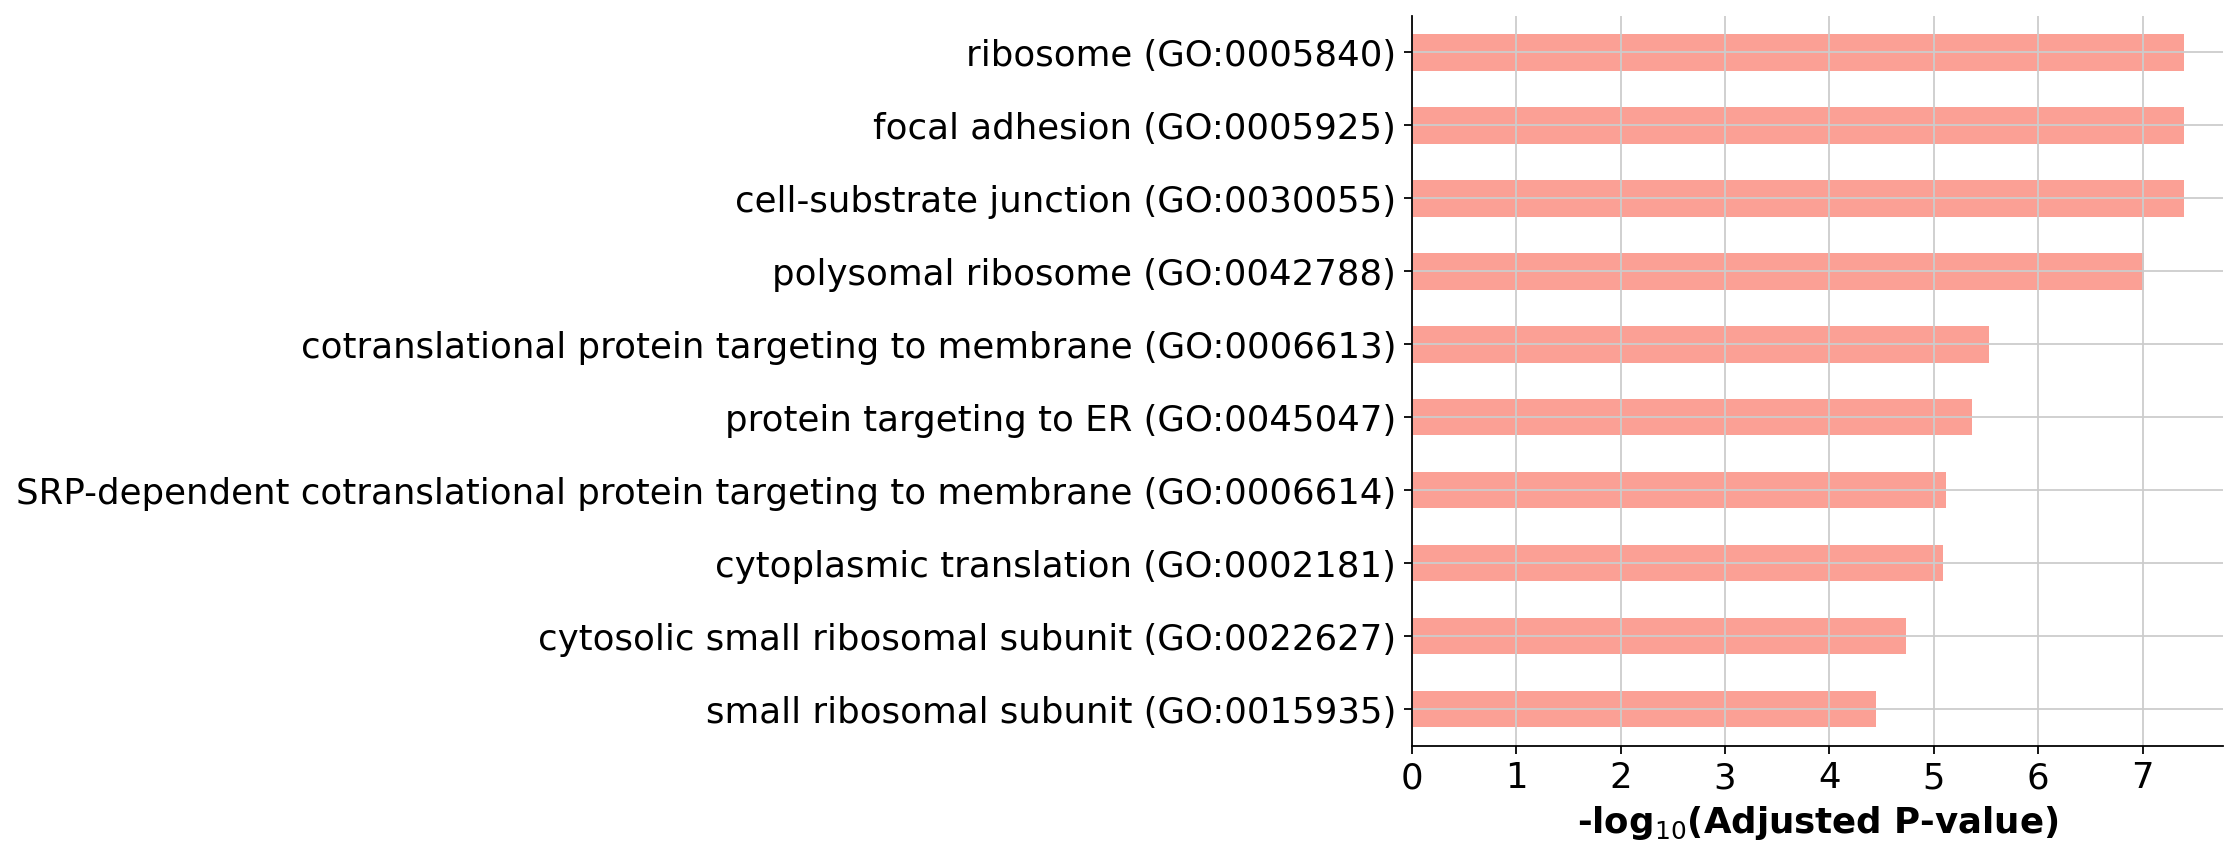

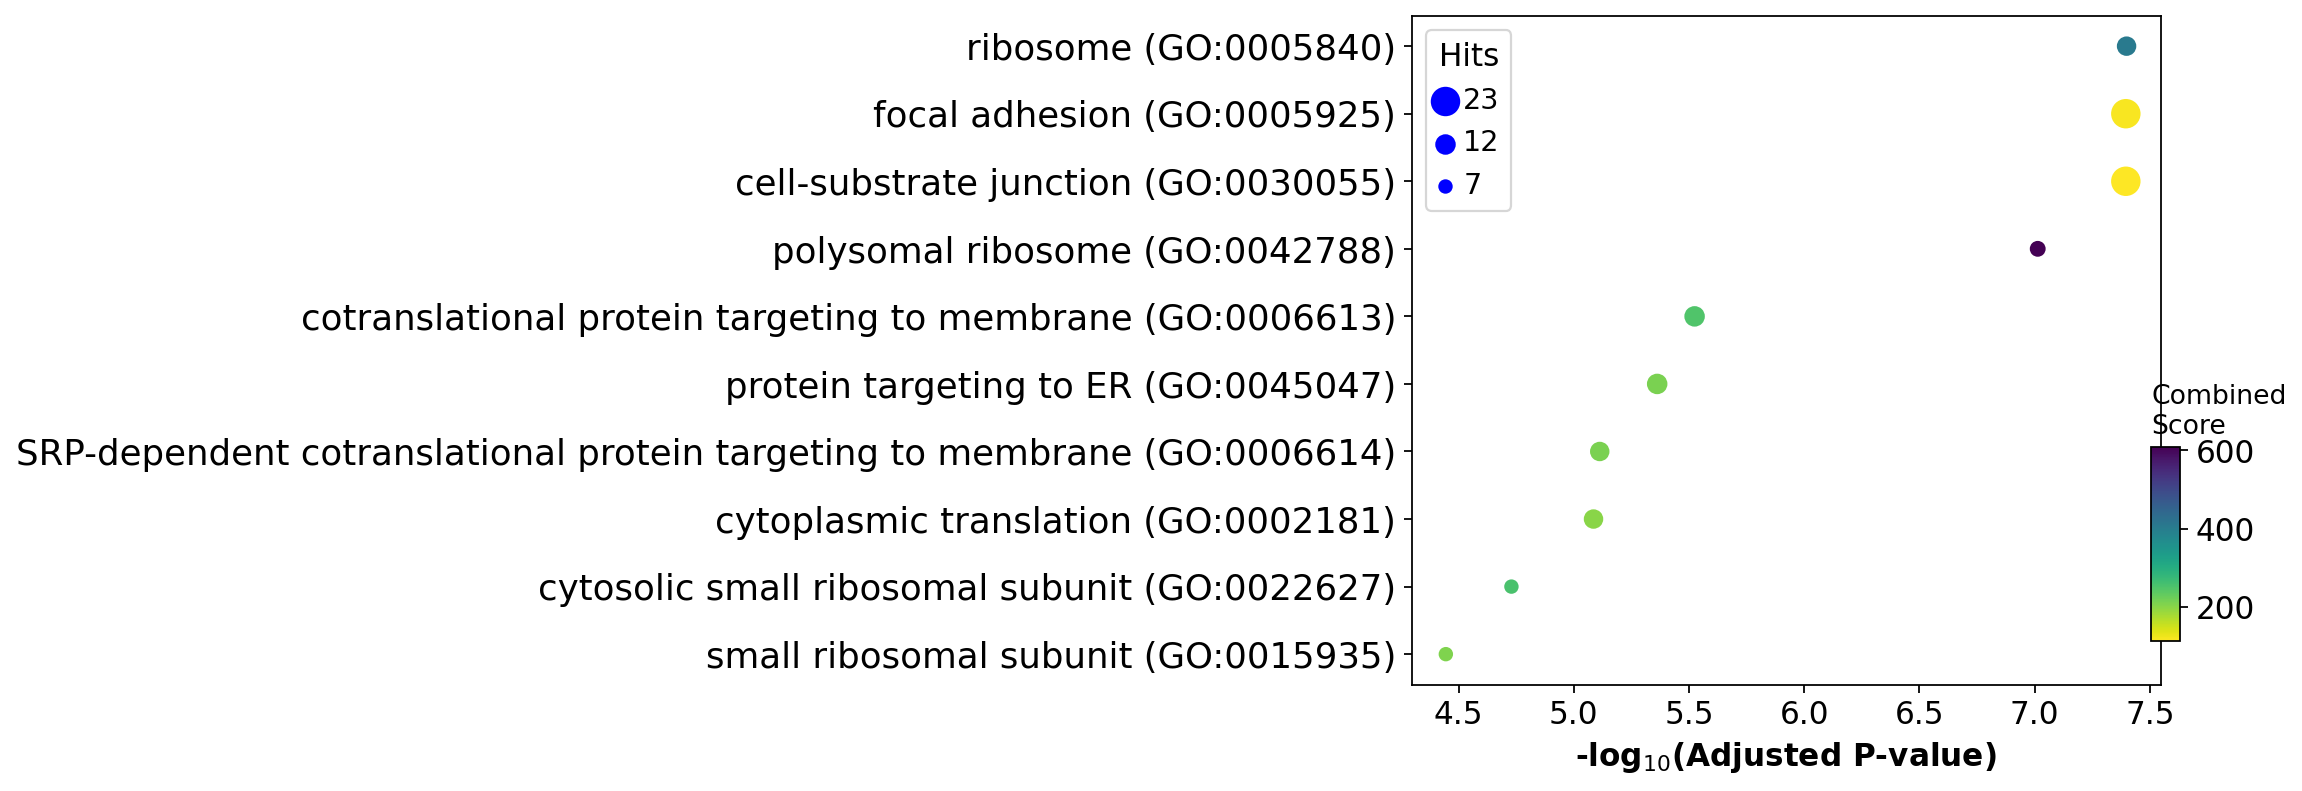

In [31]:
barplot(df,column='Adjusted P-value', cutoff = 1.0)
dotplot(df,column='Adjusted P-value', cutoff = 1.0, cmap='viridis_r')

## 18m

In [37]:
df = GSEA_DataFrame(BM_mac, '18m')
df_adj = df[df['logfoldchanges']>=0.7]
Brain_Myeloid_18m_sig = list(df_adj['names'])
df_adj

names    scores         pvals  pvals_adj  logfoldchanges
0     Gm6900  6.113964  9.718659e-10   0.000053        1.935985
1    Gm44705  4.960415  7.034284e-07   0.012711        1.477603
2    Gm16378  4.747715  2.057280e-06   0.027882        0.958052
3     Tmbim6  4.458939  8.236624e-06   0.063789        0.966298
4      Lamp1  4.196558  2.710028e-05   0.149500        1.202926
..       ...       ...           ...        ...             ...
277   Setd1b  1.977956  4.793371e-02   1.000000        0.790976
279   Znhit1  1.974074  4.837330e-02   1.000000        0.906763
282    Sp100  1.964759  4.944214e-02   1.000000        0.849373
284     Ppt2  1.963983  4.953210e-02   1.000000        0.782727
286    Pdcd5  1.958549  5.016566e-02   1.000000        0.779979

[206 rows x 5 columns]

In [38]:
#macrophages
enr_Brain_Myeloid_18m = gp.enrichr(gene_list= Brain_Myeloid_18m_sig,
                 gene_sets=[#'WikiPathways_2019_Mouse',
                            'KEGG_2019_Mouse',
                            'GO_Cellular_Component_2021',
                            'GO_Biological_Process_2021',
                            'GO_Molecular_Function_2021',
                            'GTEx_Aging_Signatures_2021',
                            #'HDSigDB_Mouse_2021',
                            'Mouse_Gene_Atlas'],
                 organism='Mouse', # don't forget to set organism to the one you desired! e.g. Yeast
                 description='test_name',
                 outdir='test/enrichr_kegg',
                 no_plot=False,
                 cutoff=1.0 # test dataset, use lower value from range(0,1)
                )

df = enr_Brain_Myeloid_18m.results
df = df[df['Adjusted P-value'] <= 0.05].copy() 
df

Gene_set  \
0                KEGG_2019_Mouse   
1                KEGG_2019_Mouse   
2                KEGG_2019_Mouse   
3                KEGG_2019_Mouse   
4                KEGG_2019_Mouse   
5                KEGG_2019_Mouse   
6                KEGG_2019_Mouse   
7                KEGG_2019_Mouse   
8                KEGG_2019_Mouse   
9                KEGG_2019_Mouse   
10               KEGG_2019_Mouse   
11               KEGG_2019_Mouse   
12               KEGG_2019_Mouse   
13               KEGG_2019_Mouse   
206   GO_Cellular_Component_2021   
207   GO_Cellular_Component_2021   
208   GO_Cellular_Component_2021   
209   GO_Cellular_Component_2021   
210   GO_Cellular_Component_2021   
211   GO_Cellular_Component_2021   
212   GO_Cellular_Component_2021   
213   GO_Cellular_Component_2021   
214   GO_Cellular_Component_2021   
215   GO_Cellular_Component_2021   
216   GO_Cellular_Component_2021   
217   GO_Cellular_Component_2021   
218   GO_Cellular_Component_2021   
219   GO_Cellular_Component_2021   
220   GO_Cellular_Component_2021   
221   GO_Cellular_Component_2021   
222   GO_Cellular_Component_2021   
223   GO_Cellular_Component_2021   
224   GO_Cellular_Component_2021   
225   GO_Cellular_Component_2021   
226   GO_Cellular_Component_2021   
227   GO_Cellular_Component_2021   
228   GO_Cellular_Component_2021   
229   GO_Cellular_Component_2021   
230   GO_Cellular_Component_2021   
231   GO_Cellular_Component_2021   
381   GO_Biological_Process_2021   
382   GO_Biological_Process_2021   
383   GO_Biological_Process_2021   
384   GO_Biological_Process_2021   
385   GO_Biological_Process_2021   
386   GO_Biological_Process_2021   
387   GO_Biological_Process_2021   
388   GO_Biological_Process_2021   
2100  GO_Molecular_Function_2021   
2461            Mouse_Gene_Atlas   
2462            Mouse_Gene_Atlas   
2463            Mouse_Gene_Atlas   
2464            Mouse_Gene_Atlas   

                                                   Term Overlap       P-value  \
0                                              Lysosome  12/124  6.000157e-09   
1                                          Tuberculosis  12/178  3.353674e-07   
2                                             Phagosome  11/180  2.740419e-06   
3                            Hedgehog signaling pathway    5/44  8.650685e-05   
4             Chagas disease (American trypanosomiasis)   7/103  9.541168e-05   
5                                    Pathways in cancer  15/535  4.534225e-04   
6              Vasopressin-regulated water reabsorption    4/43  9.850568e-04   
7                  Leukocyte transendothelial migration   6/115  1.231321e-03   
8                       Human cytomegalovirus infection   9/255  1.353361e-03   
9                                           Endocytosis   9/269  1.951263e-03   
10                                          Spliceosome   6/132  2.481684e-03   
11              Transcriptional misregulation in cancer   7/183  2.935623e-03   
12                       Ubiquitin mediated proteolysis   6/138  3.096033e-03   
13             Human immunodeficiency virus 1 infection   8/238  3.341848e-03   
206                         vacuolar lumen (GO:0005775)  12/161  1.124278e-07   
207                               lysosome (GO:0005764)  19/477  5.489626e-07   
208                      azurophil granule (GO:0042582)  11/155  6.284482e-07   
209                secretory granule lumen (GO:0034774)  15/316  1.053075e-06   
210                 ficolin-1-rich granule (GO:0101002)  11/184  3.390625e-06   
211                          lytic vacuole (GO:0000323)  11/219  1.769374e-05   
212                        lysosomal lumen (GO:0043202)    7/86  2.998151e-05   
213                azurophil granule lumen (GO:0035578)    7/90  4.026756e-05   
214                       tertiary granule (GO:0070820)   9/164  5.234683e-05   
215           ficolin-1-rich granule lumen (GO:1904813)   7/123  2.877090e-04   
216       heterotrimeric G-protein complex (GO:0005834

<AxesSubplot:xlabel='-log$_{10}$(Adjusted P-value)'>

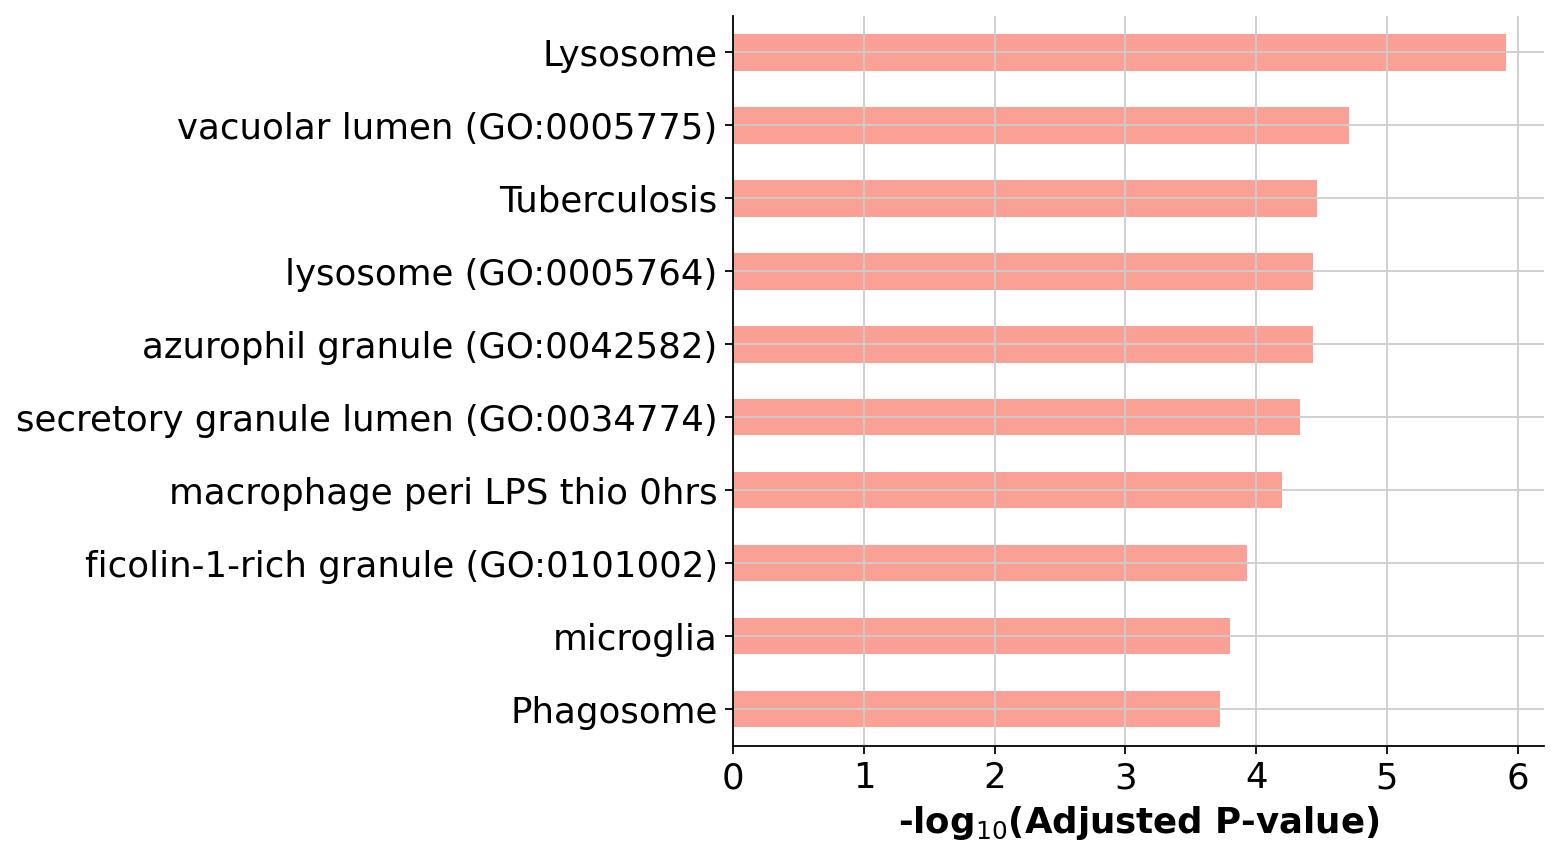

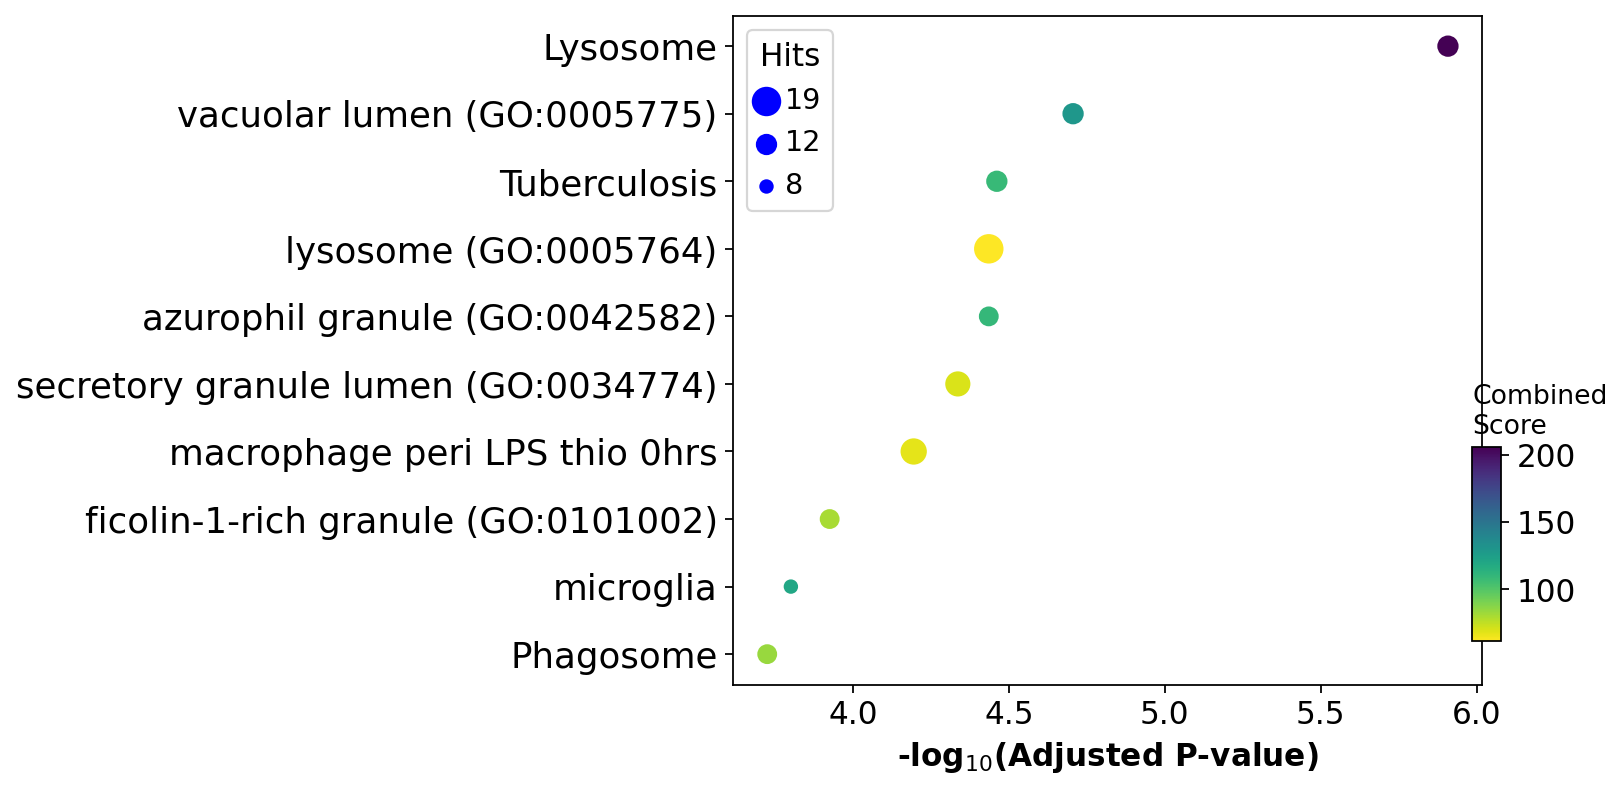

In [39]:
barplot(df,column='Adjusted P-value', cutoff = 1.0)
dotplot(df,column='Adjusted P-value', cutoff = 1.0, cmap='viridis_r')

## 24m

In [40]:
df = GSEA_DataFrame(BM_mac, '24m')
df_adj = df[df['logfoldchanges']>=0.7]
Brain_Myeloid_24m_sig = list(df_adj['names'])
df_adj

names    scores         pvals  pvals_adj  logfoldchanges
0     Gm1821  6.206728  5.409921e-10   0.000029        0.938493
1     Rpl13a  5.856670  4.722386e-09   0.000085        0.992265
2    Gm15427  5.282291  1.275783e-07   0.000988        1.006536
3    Gm15710  5.219424  1.794808e-07   0.001216        1.164426
4    Gm11478  4.680050  2.868051e-06   0.007994        1.362175
..       ...       ...           ...        ...             ...
281  Gm45855  1.122326  2.617238e-01   1.000000        1.255017
282   Pdlim1  1.118754  2.632451e-01   1.000000        0.715087
283   Agpat4  1.114468  2.650786e-01   1.000000        1.066621
284   Mvb12a  1.113039  2.656917e-01   1.000000        0.768048
286   Gm6807  1.104466  2.693910e-01   1.000000        0.891707

[182 rows x 5 columns]

In [41]:
#macrophages
enr_Brain_Myeloid_24m = gp.enrichr(gene_list= Brain_Myeloid_24m_sig,
                 gene_sets=[#'WikiPathways_2019_Mouse',
                            'KEGG_2019_Mouse',
                            'GO_Cellular_Component_2021',
                            'GO_Biological_Process_2021',
                            'GO_Molecular_Function_2021',
                            'GTEx_Aging_Signatures_2021',
                            #'HDSigDB_Mouse_2021',
                            'Mouse_Gene_Atlas'],
                 organism='Mouse', # don't forget to set organism to the one you desired! e.g. Yeast
                 description='test_name',
                 outdir='test/enrichr_kegg',
                 no_plot=False,
                 cutoff=1.0 # test dataset, use lower value from range(0,1)
                )

df = enr_Brain_Myeloid_24m.results
df = df[df['Adjusted P-value'] <= 0.05].copy() 
df

Gene_set                                 Term Overlap   P-value  \
0  KEGG_2019_Mouse            Graft-versus-host disease    6/64  0.000025   
1  KEGG_2019_Mouse             Type I diabetes mellitus    6/69  0.000039   
2  KEGG_2019_Mouse  Antigen processing and presentation    6/90  0.000173   
3  KEGG_2019_Mouse                  Allograft rejection    5/63  0.000271   
4  KEGG_2019_Mouse           Autoimmune thyroid disease    5/78  0.000729   
5  KEGG_2019_Mouse                    Viral myocarditis    5/87  0.001195   
6  KEGG_2019_Mouse                               Asthma    3/25  0.001471   
7  KEGG_2019_Mouse           Hematopoietic cell lineage    5/94  0.001686   
8  KEGG_2019_Mouse     Inflammatory bowel disease (IBD)    4/59  0.002044   
9  KEGG_2019_Mouse                        Leishmaniasis    4/67  0.003254   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0          0.002572            0                     0   11.614420   
1          0.002572            0                     0   10.689935   
2          0.007606            0                     0    8.008929   
3          0.008937            0                     0    9.624002   
4          0.019241            0                     0    7.640662   
5          0.026280            0                     0    6.798953   
6          0.027740            0                     0   15.080752   
7          0.027825            0                     0    6.261982   
8          0.029982            0                     0    8.074770   
9          0.042958            0                     0    7.046549   

   Combined Score                                  Genes  
0      122.933632   H2-EB1;IL1B;H2-Q6;H2-Q7;H2-AA;H2-AB1  
1      108.533098   H2-EB1;IL1B;H2-Q6;H2-Q7;H2-AA;H2-AB1  
2       69.381022  H2-EB1;H2-Q6;H2-Q7;IFI30;H2-AA;H2-AB1  
3       79.052375        H2-EB1;H2-Q6;H2-Q7;H2-AA;H2-AB1  
4       55.196537        H2-EB1;H2-Q6;H2-Q7;H2-AA;H2-AB1  
5       45.756791        H2-EB1;H2-Q6;H2-Q7;H2-AA;H2-AB1  
6       98.352976                    H2-EB1;H2-AA;H2-AB1  
7       39.983985        H2-EB1;IL1B;CSF2RA;H2-AA;H2-AB1  
8       50.004916               H2-EB1;IL1B;H2-AA;H2-AB1  
9       40.360936               H2-EB1;IL1B;H2-AA;H2-AB1

<AxesSubplot:xlabel='-log$_{10}$(Adjusted P-value)'>

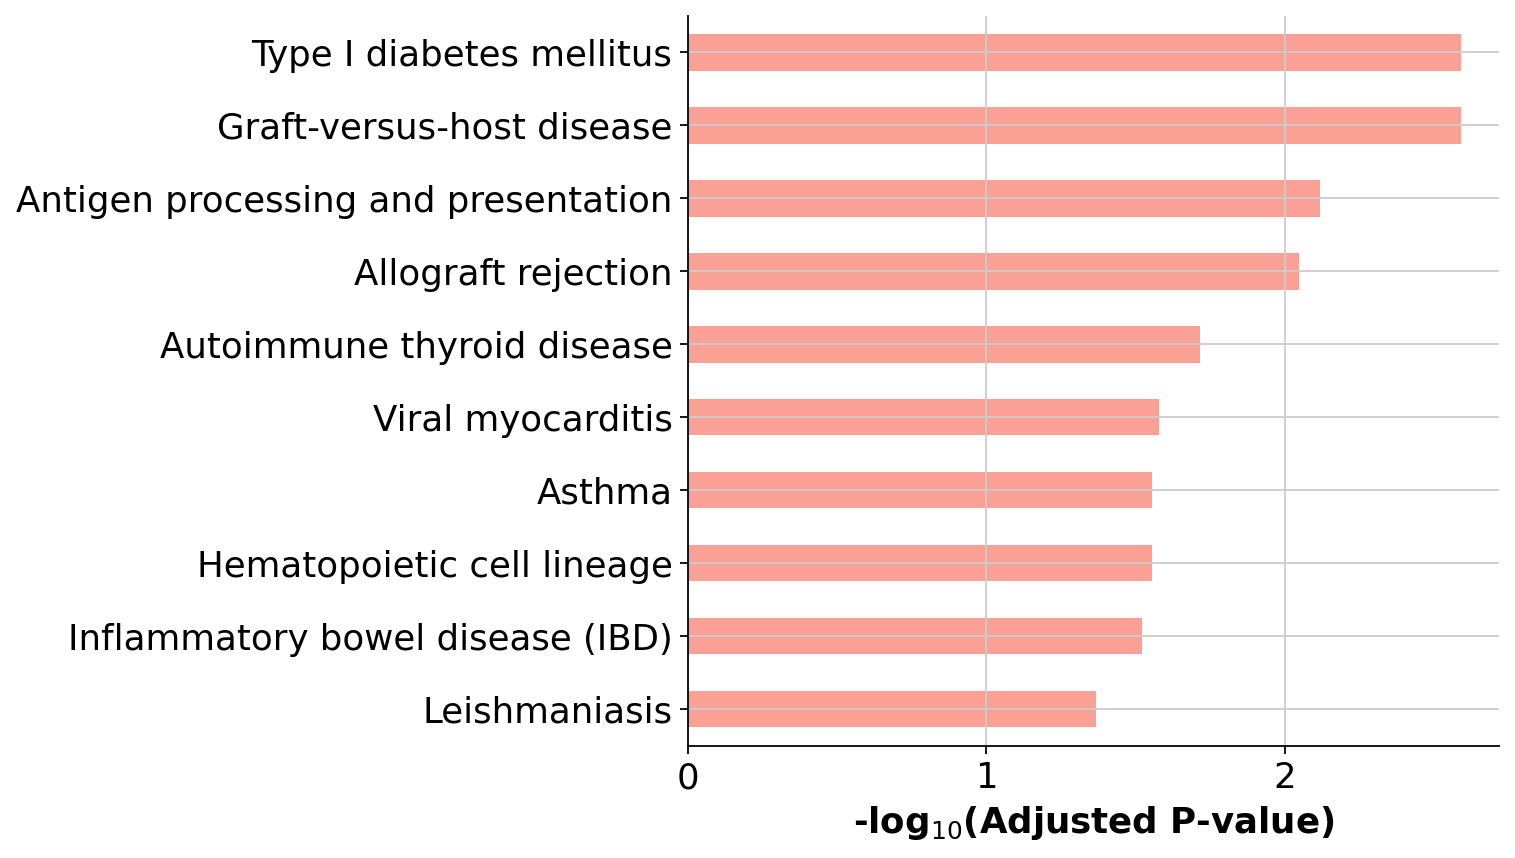

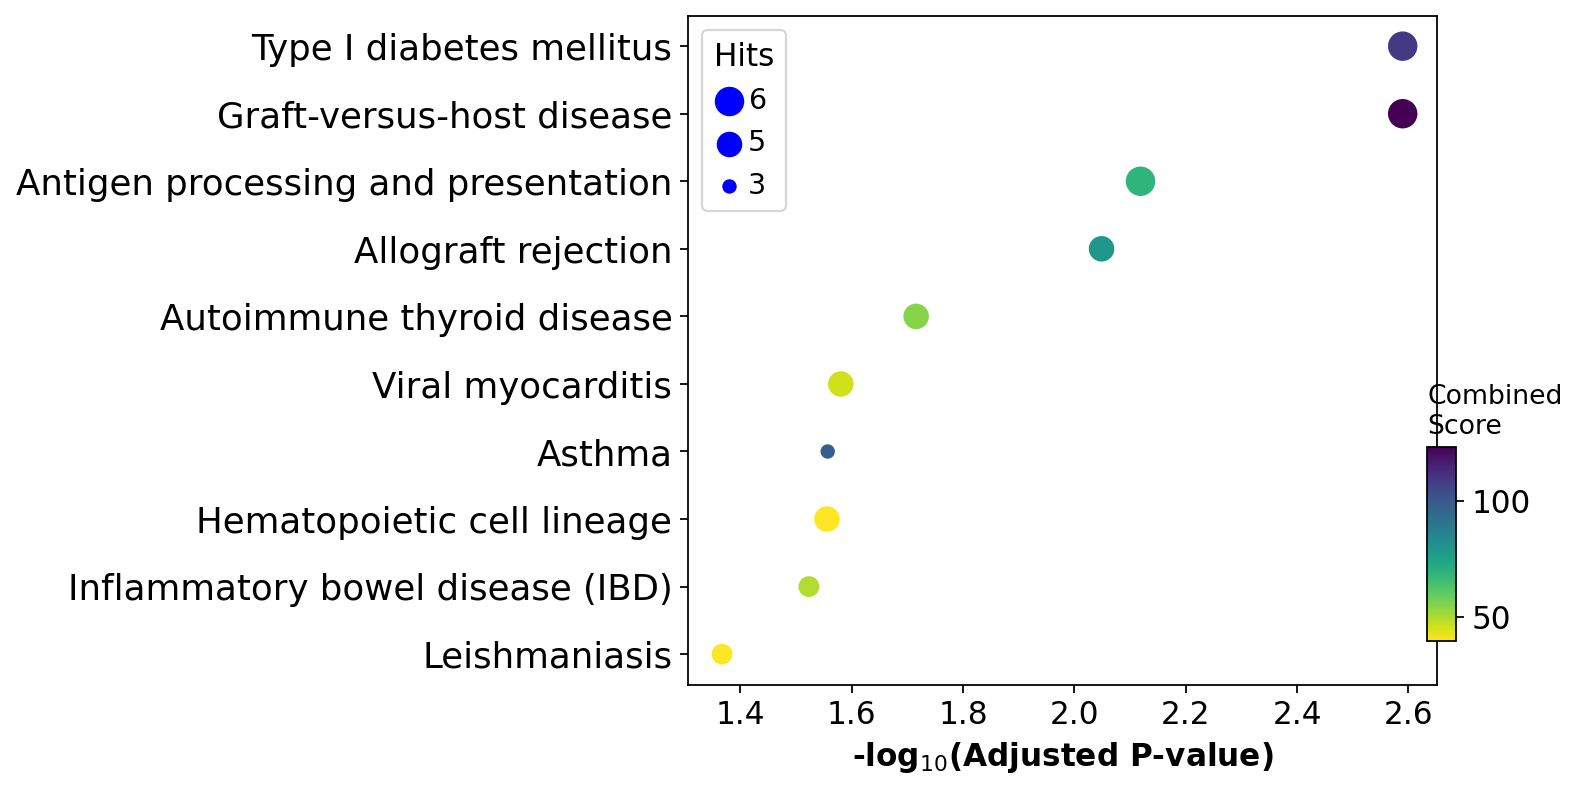

In [42]:
barplot(df,column='Adjusted P-value', cutoff = 1.0)
dotplot(df,column='Adjusted P-value', cutoff = 1.0, cmap='viridis_r')

# Aorta

## Processing

In [ ]:
adata_AORTA = adata[adata.obs['tissue'] == "Aorta"].copy()
sc.pp.pca(adata_AORTA)
sc.pp.neighbors(adata_AORTA, n_pcs=9)
sc.tl.leiden(adata_AORTA) 
sc.tl.umap(adata_AORTA)

In [ ]:
#Macrophages
AORTA_macs = adata_AORTA[adata_AORTA.obs['cell_ontology_class']=='macrophage']
AORTA_macs_3m_24m = AORTA_macs[AORTA_macs.obs['age'].isin(['3m', '24m'])]
sc.pp.pca(AORTA_macs_3m_24m)
sc.pp.neighbors(AORTA_macs_3m_24m, n_pcs=9)
sc.tl.leiden(AORTA_macs_3m_24m) 
sc.tl.umap(AORTA_macs_3m_24m)

In [ ]:
#APCs and macrophages
AORTA_macs_APCs = adata_AORTA[adata_AORTA.obs['cell_ontology_class'].isin(['professional antigen presenting cell', 'macrophage'])]
sc.pp.pca(AORTA_macs_APCs)
sc.pp.neighbors(AORTA_macs_APCs, n_pcs=9)
sc.tl.leiden(AORTA_macs_APCs) 
sc.tl.umap(AORTA_macs_APCs)

In [ ]:
#APCs only
AORTA_APCs = adata_AORTA[adata_AORTA.obs['cell_ontology_class']=='professional antigen presenting cell']
sc.pp.pca(AORTA_APCs)
sc.pp.neighbors(AORTA_APCs, n_pcs=9)
sc.tl.leiden(AORTA_APCs) 
sc.tl.umap(AORTA_APCs)

## rank_genes

In [ ]:
AORTA_macs_3m_24m

In [ ]:
# Macrophages (3m, 24m)
sc.tl.rank_genes_groups(AORTA_macs_3m_24m, groupby = 'age', method = 'wilcoxon', pts = True)
sc.tl.filter_rank_genes_groups(AORTA_macs_3m_24m, min_fold_change=2)
sc.pl.rank_genes_groups(AORTA_macs_3m_24m, key='rank_genes_groups_filtered')
sc.pl.rank_genes_groups_dotplot(AORTA_macs_3m_24m, key='rank_genes_groups_filtered', swap_axes=True)

In [ ]:
#Antigen Presenting Cells & Macrophages (3m, 24m)
sc.tl.rank_genes_groups(AORTA_macs_APCs, groupby = 'age', method = 'wilcoxon', pts = True)
sc.tl.filter_rank_genes_groups(AORTA_macs_APCs, min_fold_change=2)
sc.pl.rank_genes_groups(AORTA_macs_APCs, key='rank_genes_groups_filtered')
sc.pl.rank_genes_groups_dotplot(AORTA_macs_APCs, key='rank_genes_groups_filtered', swap_axes=True)

In [ ]:
#Only Antigen Presenting Cells
sc.tl.rank_genes_groups(AORTA_APCs, groupby = 'age', method = 'wilcoxon', pts = True)
sc.tl.filter_rank_genes_groups(AORTA_APCs, min_fold_change=2)
sc.pl.rank_genes_groups(AORTA_APCs, key='rank_genes_groups_filtered')
sc.pl.rank_genes_groups_dotplot(AORTA_APCs, key='rank_genes_groups_filtered', swap_axes=True)

In [ ]:
AORTA_macs_24m = ['Rpl13a-ps1','Gm3788','Gm12537','Gm46522','Rpl10-ps1','Gm9308','Rpl17-ps9','Rps8-ps2','Ntmt1']


In [ ]:
def AORTA_gene_expression_df(adata, genelist):
    '''Takes adata object and a list of genes. 
    Returns a pandas dataframe where genes and their expression values are columns in dataframe of adata.'''
    df = adata.obs.copy()
    
    for g in genelist:
        df[g] = adata_AORTA[:,g].X.toarray().flatten()
    return df 

adata_AORTA_obs = gene_expression_obs(adata_AORTA, AORTA_macs_24m)
adata_AORTA_obs = remove_cats(adata_AORTA_obs)
AORTA_df = AORTA_gene_expression_df(adata_AORTA_obs, AORTA_macs_24m)


In [ ]:
set(adata_AORTA.obs['cell_ontology_class'])

In [ ]:
df = AORTA_df[['age','cell_ontology_class','Gm3788']]
df["age_months"] = [int(e[:-1]) for e in df.age]
df = df.sort_values("age_months")
mask = df['cell_ontology_class'].isin(['aortic endothelial cell',
 'fibroblast of cardiac tissue',
 'fibrocyte',
 'macrophage',
 'professional antigen presenting cell'])
df = df[mask]

x = "cell_ontology_class" 
y = "Gm3788" 
hue = 'age'
hue_order = ['3m', '18m', '24m']

box_pairs=[  
    (("macrophage", "3m"), ("macrophage", "18m")),
    (("macrophage", "3m"), ("macrophage", "24m")),
    (("macrophage", "18m"), ("macrophage", "24m")),
    
    (("fibrocyte", "3m"), ("fibrocyte", "18m")),
    (("fibrocyte", "3m"), ("fibrocyte", "24m")),
    (("fibrocyte", "18m"), ("fibrocyte", "24m")),
    
    (("aortic endothelial cel", "3m"), ("aortic endothelial cel", "18m")),
    (("aortic endothelial cel", "3m"), ("aortic endothelial cel", "24m")),
    (("aortic endothelial cel", "18m"), ("aortic endothelial cel", "24m")),
    
    (("fibroblast of cardiac tissue", "3m"), ("fibroblast of cardiac tissue", "18m")),
    (("fibroblast of cardiac tissue", "3m"), ("fibroblast of cardiac tissue", "24m")),
    (("fibroblast of cardiac tissue", "18m"), ("fibroblast of cardiac tissue", "24m")),
    
    (("professional antigen presenting cell", "3m"), ("professional antigen presenting cell", "18m")),
    (("professional antigen presenting cell", "3m"), ("professional antigen presenting cell", "24m")),
    (("professional antigen presenting cell", "18m"), ("professional antigen presenting cell", "24m")),
     
    ]
fig = plt.figure(figsize=(10, 5))
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
plt.xticks(rotation=90)
ax = sns.boxplot(data=df, x=x, y=y, hue=hue)
add_stat_annotation(ax, data=df, x=x, y=y,hue=hue,box_pairs=box_pairs,
                    test='Mann-Whitney',loc='inside',verbose=2)

## GSEA

In [ ]:
AORTA_macs_24m = ['Rpl13a-ps1','Gm3788','Gm12537','Gm46522','Rpl10-ps1','Gm9308','Rpl17-ps9','Rps8-ps2','Ntmt1']
AORTA_APCs_24m = ['Eef1b2', 'Uba52-ps', 'Tmem59','Otulin','Gm8960','Pkm', 'Rrp1','Psmd4','Rps10-ps2','Dpysl2']
AORTA_macs_APCs_24m = ['Uba52-ps','Rps10-ps2', 'Ifitm2','Gm8960','Rrp1','Rpl28-ps1','Rps18-ps3','Jun','Gm10240','Gm16580']


In [ ]:
#Macrophages
enr_AORTA_macs_24m = gp.enrichr(gene_list= AORTA_macs_24m,
                 gene_sets=['WikiPathways_2019_Mouse',
                            'KEGG_2019_Mouse',
                            'GO_Cellular_Component_2021',
                            'GO_Biological_Process_2021',
                            'GO_Molecular_Function_2021',
                            'GTEx_Aging_Signatures_2021',
                            'HDSigDB_Mouse_2021',
                            'Mouse_Gene_Atlas'],
                 organism='Mouse', # don't forget to set organism to the one you desired! e.g. Yeast
                 description='test_name',
                 outdir='test/enrichr_kegg',
                 no_plot=False,
                 cutoff=0.05 # test dataset, use lower value from range(0,1)
                )

df = enr_AORTA_macs_24m.results
df = df[df['Adjusted P-value'] <= 0.05].copy() 
df

In [ ]:
barplot(df,column='Adjusted P-value', cutoff = 1.0)
dotplot(df,column='Adjusted P-value', cutoff = 1.0, cmap='viridis_r')

In [ ]:
#Antigen Presenting Cells (APCs)
enr_AORTA_APCs_24m = gp.enrichr(gene_list= AORTA_APCs_24m,
                 gene_sets=['WikiPathways_2019_Mouse',
                            'KEGG_2019_Mouse',
                            'GO_Cellular_Component_2021',
                            'GO_Biological_Process_2021',
                            'GO_Molecular_Function_2021',
                            'GTEx_Aging_Signatures_2021',
                            'HDSigDB_Mouse_2021',
                            'Mouse_Gene_Atlas'],
                 organism='Mouse', # don't forget to set organism to the one you desired! e.g. Yeast
                 description='test_name',
                 outdir='test/enrichr_kegg',
                 no_plot=False,
                 cutoff=0.05 # test dataset, use lower value from range(0,1)
                )

df = enr_AORTA_APCs_24m.results
df = df[df['Adjusted P-value'] <= 0.05].copy() 
df

In [ ]:
barplot(df,column='Adjusted P-value', cutoff = 1.0)
dotplot(df,column='Adjusted P-value', cutoff = 1.0, cmap='viridis_r')

In [ ]:
#APCs and Macrophages

enr_AORTA_macs_APCs_24m = gp.enrichr(gene_list= AORTA_macs_APCs_24m,
                 gene_sets=['WikiPathways_2019_Mouse',
                            'KEGG_2019_Mouse',
                            'GO_Cellular_Component_2021',
                            'GO_Biological_Process_2021',
                            'GO_Molecular_Function_2021',
                            'GTEx_Aging_Signatures_2021',
                            'HDSigDB_Mouse_2021',
                            'Mouse_Gene_Atlas'],
                 organism='Mouse', # don't forget to set organism to the one you desired! e.g. Yeast
                 description='test_name',
                 outdir='test/enrichr_kegg',
                 no_plot=False,
                 cutoff=0.05 # test dataset, use lower value from range(0,1)
                )

df = enr_AORTA_macs_APCs_24m.results
df = df[df['Adjusted P-value'] <= 0.05].copy() 
df

In [ ]:
barplot(df,column='Adjusted P-value', cutoff = 1.0)
dotplot(df,column='Adjusted P-value', cutoff = 1.0, cmap='viridis_r')

# NA Lung, only one 3m lung macrophage

## Processing

In [ ]:
adata_LUNG = adata[adata.obs['tissue'] == "Lung"].copy()
sc.pp.pca(adata_LUNG)
sc.pp.neighbors(adata_LUNG, n_pcs=5)
sc.tl.leiden(adata_LUNG) 
sc.tl.umap(adata_LUNG)

In [ ]:
Lung_macs = adata_LUNG[adata_LUNG.obs['cell_ontology_class'] == "lung macrophage"].copy()
sc.pp.pca(Lung_macs)
sc.pp.neighbors(Lung_macs, n_pcs=5)
sc.tl.leiden(Lung_macs) 
sc.tl.umap(Lung_macs)

## rank_genes

In [ ]:
sc.tl.rank_genes_groups(Lung_macs, groupby = 'age', method = 'wilcoxon', pts = True)
sc.tl.filter_rank_genes_groups(Lung_macs, min_fold_change=2)
sc.pl.rank_genes_groups(Lung_macs, key='rank_genes_groups_filtered')
sc.pl.rank_genes_groups_dotplot(Lung_macs, key='rank_genes_groups_filtered', swap_axes=True)

# Diaphragm

## Processing

In [ ]:
adata_DIA = adata[adata.obs['tissue'] == "Diaphragm"].copy()
sc.pp.pca(adata_DIA)
sc.pp.neighbors(adata_DIA, n_pcs=9)
sc.tl.leiden(adata_DIA) 
sc.tl.umap(adata_DIA)

In [ ]:
DIA_macs = adata_DIA[adata_DIA.obs['cell_ontology_class'] == "macrophage"].copy()
sc.pp.pca(DIA_macs)
sc.pp.neighbors(DIA_macs, n_pcs=9)
sc.tl.leiden(DIA_macs) 
sc.tl.umap(DIA_macs)

## rank_genes

In [ ]:
sc.tl.rank_genes_groups(DIA_macs, groupby = 'age', method = 'wilcoxon', pts = True)
sc.tl.filter_rank_genes_groups(DIA_macs, min_fold_change=2)
sc.pl.rank_genes_groups(DIA_macs, key='rank_genes_groups_filtered')
sc.pl.rank_genes_groups_dotplot(DIA_macs, key='rank_genes_groups_filtered', swap_axes=True)

## GSEA

In [ ]:
#24 month gene list
DIA_macs_24m = ['Mir692-2','Gm7730','Gm17494','Usmg5','Gm14586','Rapgef6','Gm26532','Ccl24','Gm10080','Gm3379']

In [ ]:
enr_DIA_macs_24m = gp.enrichr(gene_list= DIA_macs_24m,
                 gene_sets=['WikiPathways_2019_Mouse',
                            'KEGG_2019_Mouse',
                            'GO_Cellular_Component_2021',
                            'GO_Biological_Process_2021',
                            'GO_Molecular_Function_2021',
                            'GTEx_Aging_Signatures_2021',
                            'HDSigDB_Mouse_2021',
                            'Mouse_Gene_Atlas'],
                 organism='Mouse', # don't forget to set organism to the one you desired! e.g. Yeast
                 description='test_name',
                 outdir='test/enrichr_kegg',
                 no_plot=False,
                 cutoff=0.05 # test dataset, use lower value from range(0,1)
                )

df = enr_DIA_macs_24m.results
df = df[df['Adjusted P-value'] <= 0.05].copy() 
df

In [ ]:
barplot(df,column='Adjusted P-value', cutoff = 1.0)
dotplot(df,column='Adjusted P-value', cutoff = 1.0, cmap='viridis_r')

## stat_annot

# NA Skin, only one 24m macrophage

## Processing

In [ ]:
adata_SKIN = adata[adata.obs['tissue'] == "Skin"].copy()
sc.pp.pca(adata_SKIN)
sc.pp.neighbors(adata_SKIN, n_pcs=9)
sc.tl.leiden(adata_SKIN) 
sc.tl.umap(adata_SKIN)

In [ ]:
SKIN_macs = adata_SKIN[adata_SKIN.obs['cell_ontology_class'] == "macrophage"].copy()
sc.pp.pca(SKIN_macs)
sc.pp.neighbors(SKIN_macs, n_pcs=9)
sc.tl.leiden(SKIN_macs) 
sc.tl.umap(SKIN_macs)

## rank_genes

In [ ]:
sc.tl.rank_genes_groups(SKIN_macs, groupby = 'age', method = 'wilcoxon', pts = True)
sc.tl.filter_rank_genes_groups(SKIN_macs, min_fold_change=2)
sc.pl.rank_genes_groups(SKIN_macs, key='rank_genes_groups_filtered')
sc.pl.rank_genes_groups_dotplot(SKIN_macs, key='rank_genes_groups_filtered', swap_axes=True)

# MAT

## Processing

In [ ]:
adata_MAT = adata[adata.obs['tissue'] == "MAT"].copy()
sc.pp.pca(adata_MAT)
sc.pp.neighbors(adata_MAT, n_pcs=9)
sc.tl.leiden(adata_MAT) 
sc.tl.umap(adata_MAT)

In [ ]:
MAT_macs = adata_MAT[adata_MAT.obs['cell_ontology_class'] == "macrophage"].copy()
sc.pp.pca(MAT_macs)
sc.pp.neighbors(MAT_macs, n_pcs=9)
sc.tl.leiden(MAT_macs) 
sc.tl.umap(MAT_macs)

## rank_genes

In [ ]:
sc.tl.rank_genes_groups(MAT_macs, groupby = 'age', method = 'wilcoxon', pts = True)
sc.tl.filter_rank_genes_groups(MAT_macs, min_fold_change=2)
sc.pl.rank_genes_groups(MAT_macs, key='rank_genes_groups_filtered')
sc.pl.rank_genes_groups_dotplot(MAT_macs, key='rank_genes_groups_filtered', swap_axes=True)

## GSEA

In [ ]:
#24 month gene list
MAT_macs_24m = ['Gm3788','Rpl13a-ps1','Gm12537','Gm5138','Gm29667','Gm10045','Gm4977','Gm10359','Gm17228','Olfr620']

In [ ]:
enr_MAT_macs_24m = gp.enrichr(gene_list= MAT_macs_24m,
                 gene_sets=['WikiPathways_2019_Mouse',
                            'KEGG_2019_Mouse',
                            'GO_Cellular_Component_2021',
                            'GO_Biological_Process_2021',
                            'GO_Molecular_Function_2021',
                            'GTEx_Aging_Signatures_2021',
                            'HDSigDB_Mouse_2021',
                            'Mouse_Gene_Atlas'],
                 organism='Mouse', # don't forget to set organism to the one you desired! e.g. Yeast
                 description='test_name',
                 outdir='test/enrichr_kegg',
                 no_plot=False,
                 cutoff=0.05 # test dataset, use lower value from range(0,1)
                )

df = enr_MAT_macs_24m.results
df = df[df['Adjusted P-value'] <= 0.05].copy() 
df

In [ ]:
barplot(df,column='Adjusted P-value', cutoff = 1.0)
dotplot(df,column='Adjusted P-value', cutoff = 1.0, cmap='viridis_r')

# Marrow

## Processing

In [ ]:
adata_Marrow = adata[adata.obs['tissue'] == "Marrow"].copy()
sc.pp.pca(adata_Marrow)
sc.pp.neighbors(adata_Marrow, n_pcs=9)
sc.tl.leiden(adata_Marrow) 
sc.tl.umap(adata_Marrow)

In [ ]:
Marrow_macs = adata_Marrow[adata_Marrow.obs['cell_ontology_class'] == "macrophage"].copy()
sc.pp.pca(Marrow_macs)
sc.pp.neighbors(Marrow_macs, n_pcs=9)
sc.tl.leiden(Marrow_macs) 
sc.tl.umap(Marrow_macs)

## rank_genes

In [ ]:
sc.tl.rank_genes_groups(Marrow_macs, groupby = 'age', method = 'wilcoxon', pts = True)
sc.tl.filter_rank_genes_groups(Marrow_macs, min_fold_change=2)
sc.pl.rank_genes_groups(Marrow_macs, key='rank_genes_groups_filtered')
sc.pl.rank_genes_groups_dotplot(Marrow_macs, key='rank_genes_groups_filtered', swap_axes=True)

## GSEA

In [ ]:
Marrow_macs_24m = ['Gm3788','Rpl13a-ps1','AC165079.1','Gm17494','Gm10045','Gm5138','Gm10231','Gm10020','Gm10224','Olfr620']


In [ ]:
enr_Marrow_macs_24m = gp.enrichr(gene_list= Marrow_macs_24m,
                 gene_sets=['WikiPathways_2019_Mouse',
                            'KEGG_2019_Mouse',
                            'GO_Cellular_Component_2021',
                            'GO_Biological_Process_2021',
                            'GO_Molecular_Function_2021',
                            'GTEx_Aging_Signatures_2021',
                            'HDSigDB_Mouse_2021',
                            'Mouse_Gene_Atlas'],
                 organism='Mouse', # don't forget to set organism to the one you desired! e.g. Yeast
                 description='test_name',
                 outdir='test/enrichr_kegg',
                 no_plot=False,
                 cutoff=0.05 # test dataset, use lower value from range(0,1)
                )

df = enr_Marrow_macs_24m.results
df = df[df['Adjusted P-value'] <= 0.05].copy() 

In [ ]:
df

In [ ]:
barplot(df,column='Adjusted P-value', cutoff = 1.0)
dotplot(df,column='Adjusted P-value', cutoff = 1.0, cmap='viridis_r')

## stat_annot

# Liver

## Processing

In [ ]:
adata_Liver = adata[adata.obs['tissue'] == "Liver"].copy()
sc.pp.pca(adata_Liver)
sc.pp.neighbors(adata_Liver, n_pcs=9)
sc.tl.leiden(adata_Liver) 
sc.tl.umap(adata_Liver)

In [ ]:
Kupffer = adata_Liver[adata_Liver.obs['cell_ontology_class'] == "Kupffer cell"].copy()
sc.pp.pca(Kupffer)
sc.pp.neighbors(Kupffer, n_pcs=9)
sc.tl.leiden(Kupffer) 
sc.tl.umap(Kupffer)

## rank_genes 

In [ ]:
sc.tl.rank_genes_groups(Kupffer, groupby = 'age', method = 'wilcoxon', pts = True)
sc.tl.filter_rank_genes_groups(Kupffer, min_fold_change=2)
sc.pl.rank_genes_groups(Kupffer, key='rank_genes_groups_filtered')
sc.pl.rank_genes_groups_dotplot(Kupffer, key='rank_genes_groups_filtered', swap_axes=True)


## GSEA

In [ ]:
Kupffer_age_24m =['Rbm3','Pf4','Car3','Cyp3a11','Junb','Gm42418','Gm26917','Clcn7','Capg','Cops7a']

In [ ]:
enr_Kupffer_24m = gp.enrichr(gene_list= Kupffer_age_24m,
                 gene_sets=['WikiPathways_2019_Mouse',
                            'KEGG_2019_Mouse',
                            'GO_Cellular_Component_2021',
                            'GO_Biological_Process_2021',
                            'GO_Molecular_Function_2021',
                            'GTEx_Aging_Signatures_2021',
                            'HDSigDB_Mouse_2021',
                            'Mouse_Gene_Atlas'],
                 organism='Mouse', # don't forget to set organism to the one you desired! e.g. Yeast
                 description='test_name',
                 outdir='test/enrichr_kegg',
                 no_plot=False,
                 cutoff=0.05 # test dataset, use lower value from range(0,1)
                )

enr_Kupffer_24m.results

In [ ]:
df = enr_Kupffer_24m.results
df = df[df['Adjusted P-value'] <= 0.05].copy()
barplot(df,column='Adjusted P-value', cutoff = 1.0)
dotplot(df,column='Adjusted P-value', cutoff = 1.0, cmap='viridis_r')

## stat_annot

In [ ]:
def LIVER_gene_expression_df(adata, genelist):
    '''Takes adata object and a list of genes. 
    Returns a pandas dataframe where genes and their expression values are columns in dataframe of adata.'''
    df = adata.obs.copy()
    
    for g in genelist:
        df[g] = adata_Liver[:,g].X.toarray().flatten()
    return df 

adata_liver_obs = gene_expression_obs(adata_Liver, Kupffer_age_24m)
adata_liver_obs = remove_cats(adata_liver_obs)
liver_df = LIVER_gene_expression_df(adata_liver_obs, Kupffer_age_24m)

In [ ]:
df = liver_df[['age','cell_ontology_class','Gm42418']]
df["age_months"] = [int(e[:-1]) for e in df.age]
df = df.sort_values("age_months")
mask = df['cell_ontology_class'].isin(['endothelial cell of hepatic sinusoid','B cell','Kupffer cell','hepatocyte','T cell','mature NK T cell','myeloid leukocyte','NK cell','CD8-positive, alpha-beta T cell','CD4-positive, alpha-beta T cell'])
df = df[mask]

x = "cell_ontology_class" 
y = "Gm42418" 
hue = 'age'
hue_order = ['3m', '18m', '24m']

box_pairs=[
    (("CD4-positive, alpha-beta T cell", "3m"), ("CD4-positive, alpha-beta T cell", "18m")),
    (("CD4-positive, alpha-beta T cell", "3m"), ("CD4-positive, alpha-beta T cell", "24m")),
    (("CD4-positive, alpha-beta T cell", "18m"), ("CD4-positive, alpha-beta T cell", "24m")),
    
    (("CD8-positive, alpha-beta T cell", "3m"), ("CD8-positive, alpha-beta T cell", "18m")),
    (("CD8-positive, alpha-beta T cell", "3m"), ("CD8-positive, alpha-beta T cell", "24m")),
    (("CD8-positive, alpha-beta T cell", "18m"), ("CD8-positive, alpha-beta T cell", "24m")),
    
    (("NK cell", "3m"), ("NK cell", "18m")),
    (("NK cell", "3m"), ("NK cell", "24m")),
    (("NK cell", "18m"), ("NK cell", "24m")),
    
    (("myeloid leukocyte", "3m"), ("myeloid leukocyte", "18m")),
    (("myeloid leukocyte", "3m"), ("myeloid leukocyte", "24m")),
    (("myeloid leukocyte", "18m"), ("myeloid leukocyte", "24m")),
    
    (("mature NK T cell", "3m"), ("mature NK T cell", "18m")),
    (("mature NK T cell", "3m"), ("mature NK T cell", "24m")),
    (("mature NK T cell", "18m"), ("mature NK T cell", "24m")),
    
    (("T cell", "3m"), ("T cell", "18m")),
    (("T cell", "3m"), ("T cell", "24m")),
    (("T cell", "18m"), ("T cell", "24m")),
    
    (("hepatocyte", "3m"), ("hepatocyte", "18m")),
    (("hepatocyte", "3m"), ("hepatocyte", "24m")),
    (("hepatocyte", "18m"), ("hepatocyte", "24m")),
    
    (("Kupffer cell", "3m"), ("Kupffer cell", "18m")),
    (("Kupffer cell", "3m"), ("Kupffer cell", "24m")),
    (("Kupffer cell", "18m"), ("Kupffer cell", "24m")),
    
    (("B cell", "3m"), ("B cell", "18m")),
    (("B cell", "3m"), ("B cell", "24m")),
    (("B cell", "18m"), ("B cell", "24m")),
       
    (("endothelial cell of hepatic sinusoid", "3m"), ("endothelial cell of hepatic sinusoid", "18m")),
    (("endothelial cell of hepatic sinusoid", "3m"), ("endothelial cell of hepatic sinusoid", "24m")),
    (("endothelial cell of hepatic sinusoid", "18m"), ("endothelial cell of hepatic sinusoid", "24m")),  
    ]
fig = plt.figure(figsize=(10, 5))
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
plt.xticks(rotation=90)
ax = sns.boxplot(data=df, x=x, y=y, hue=hue)
add_stat_annotation(ax, data=df, x=x, y=y,hue=hue,box_pairs=box_pairs,
                    test='Mann-Whitney',loc='inside',verbose=2)

In [ ]:
df = liver_df[['age','cell_ontology_class','Gm26917']]
df["age_months"] = [int(e[:-1]) for e in df.age]
df = df.sort_values("age_months")
mask = df['cell_ontology_class'].isin(['endothelial cell of hepatic sinusoid','B cell','Kupffer cell','hepatocyte','T cell','mature NK T cell','myeloid leukocyte','NK cell','CD8-positive, alpha-beta T cell','CD4-positive, alpha-beta T cell'])
df = df[mask]

x = "cell_ontology_class" 
y = "Gm26917" 
hue = 'age'
hue_order = ['3m', '18m', '24m']

box_pairs=[
    (("CD4-positive, alpha-beta T cell", "3m"), ("CD4-positive, alpha-beta T cell", "18m")),
    (("CD4-positive, alpha-beta T cell", "3m"), ("CD4-positive, alpha-beta T cell", "24m")),
    (("CD4-positive, alpha-beta T cell", "18m"), ("CD4-positive, alpha-beta T cell", "24m")),
    
    (("CD8-positive, alpha-beta T cell", "3m"), ("CD8-positive, alpha-beta T cell", "18m")),
    (("CD8-positive, alpha-beta T cell", "3m"), ("CD8-positive, alpha-beta T cell", "24m")),
    (("CD8-positive, alpha-beta T cell", "18m"), ("CD8-positive, alpha-beta T cell", "24m")),
    
    (("NK cell", "3m"), ("NK cell", "18m")),
    (("NK cell", "3m"), ("NK cell", "24m")),
    (("NK cell", "18m"), ("NK cell", "24m")),
    
    (("myeloid leukocyte", "3m"), ("myeloid leukocyte", "18m")),
    (("myeloid leukocyte", "3m"), ("myeloid leukocyte", "24m")),
    (("myeloid leukocyte", "18m"), ("myeloid leukocyte", "24m")),
    
    (("mature NK T cell", "3m"), ("mature NK T cell", "18m")),
    (("mature NK T cell", "3m"), ("mature NK T cell", "24m")),
    (("mature NK T cell", "18m"), ("mature NK T cell", "24m")),
    
    (("T cell", "3m"), ("T cell", "18m")),
    (("T cell", "3m"), ("T cell", "24m")),
    (("T cell", "18m"), ("T cell", "24m")),
    
    (("hepatocyte", "3m"), ("hepatocyte", "18m")),
    (("hepatocyte", "3m"), ("hepatocyte", "24m")),
    (("hepatocyte", "18m"), ("hepatocyte", "24m")),
    
    (("Kupffer cell", "3m"), ("Kupffer cell", "18m")),
    (("Kupffer cell", "3m"), ("Kupffer cell", "24m")),
    (("Kupffer cell", "18m"), ("Kupffer cell", "24m")),
    
    (("B cell", "3m"), ("B cell", "18m")),
    (("B cell", "3m"), ("B cell", "24m")),
    (("B cell", "18m"), ("B cell", "24m")),
       
    (("endothelial cell of hepatic sinusoid", "3m"), ("endothelial cell of hepatic sinusoid", "18m")),
    (("endothelial cell of hepatic sinusoid", "3m"), ("endothelial cell of hepatic sinusoid", "24m")),
    (("endothelial cell of hepatic sinusoid", "18m"), ("endothelial cell of hepatic sinusoid", "24m")),  
    ]
fig = plt.figure(figsize=(10, 5))
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
plt.xticks(rotation=90)
ax = sns.boxplot(data=df, x=x, y=y, hue=hue)
add_stat_annotation(ax, data=df, x=x, y=y,hue=hue,box_pairs=box_pairs,
                    test='Mann-Whitney',loc='inside',verbose=2)

# Limb_Muscle

## Processing

In [ ]:
adata_LM = adata[adata.obs['tissue'] == "Limb_Muscle"].copy()
sc.pp.pca(adata_LM)
sc.pp.neighbors(adata_LM, n_pcs=9)
sc.tl.leiden(adata_LM) 
sc.tl.umap(adata_LM)

In [ ]:
LM_macropahges = adata_LM[adata_LM.obs['cell_ontology_class'] == "macrophage"].copy()
sc.pp.pca(LM_macropahges)
sc.pp.neighbors(LM_macropahges, n_pcs=9)
sc.tl.leiden(LM_macropahges) 
sc.tl.umap(LM_macropahges)

## rank_genes

In [ ]:
sc.tl.rank_genes_groups(LM_macropahges, groupby = 'age', method = 'wilcoxon', pts = True)
sc.tl.filter_rank_genes_groups(LM_macropahges, min_fold_change=2)
sc.pl.rank_genes_groups(LM_macropahges, key='rank_genes_groups_filtered')
sc.pl.rank_genes_groups_dotplot(LM_macropahges, key='rank_genes_groups_filtered', swap_axes=True)


## GSEA

In [ ]:
LM_age_24m =['Gm11478','Gm15710','Rpl9-ps6','Rpsa-ps10','Rps10-ps1','Gm3788','Rpl3-ps1','Rpl19-ps11',
             'AC165079.1','Gm10359']

In [ ]:
enr_LM_24m = gp.enrichr(gene_list= LM_age_24m,
                 gene_sets=['WikiPathways_2019_Mouse',
                            'KEGG_2019_Mouse',
                            'GO_Cellular_Component_2021',
                            'GO_Biological_Process_2021',
                            'GO_Molecular_Function_2021',
                            'GTEx_Aging_Signatures_2021',
                            'HDSigDB_Mouse_2021',
                            'Mouse_Gene_Atlas'],
                 organism='Mouse', # don't forget to set organism to the one you desired! e.g. Yeast
                 description='test_name',
                 outdir='test/enrichr_kegg',
                 no_plot=False,
                 cutoff=0.05 # test dataset, use lower value from range(0,1)
                )

enr_LM_24m.results

In [ ]:
df = enr_LM_24m.results
df = df[df['Adjusted P-value'] <= 0.05].copy()
barplot(df,column='Adjusted P-value', cutoff = 1.0)
dotplot(df,column='Adjusted P-value', cutoff = 1.0, cmap='viridis_r')

## stat_annot

In [ ]:
def LM_gene_expression_df(adata, genelist):
    '''Takes adata object and a list of genes. 
    Returns a pandas dataframe where genes and their expression values are columns in dataframe of adata.'''
    df = adata.obs.copy()
    
    for g in genelist:
        df[g] = adata_LM[:,g].X.toarray().flatten()
    return df 

adata_LM_obs = gene_expression_obs(adata_LM, LM_age_24m)
adata_LM_obs = remove_cats(adata_LM_obs)
LM_df = LM_gene_expression_df(adata_LM_obs, LM_age_24m)

### 24m Limb Muscle

In [ ]:
df = LM_df[['age','cell_ontology_class','Gm10359']]
df["age_months"] = [int(e[:-1]) for e in df.age]
df = df.sort_values("age_months")
#mask = df['cell_ontology_class'].isin(['B cell','T cell','epithelial cell of proximal tubule','fenestrated cell','kidney collecting duct epithelial cell','kidney collecting duct principal cell','kidney loop of Henle ascending limb epithelial cell','macrophage', 'mesangial cell'])
#df = df[mask]

x = "cell_ontology_class" 
y = "Gm10359" 
hue = 'age'
hue_order = ['3m', '18m', '24m']

box_pairs=[
    (("B cell", "3m"), ("B cell", "18m")),
    (("B cell", "3m"), ("B cell", "24m")),
    (("B cell", "18m"), ("B cell", "24m")),
    
    (("T cell", "3m"), ("T cell", "18m")),
    (("T cell", "3m"), ("T cell", "24m")),
    (("T cell", "18m"), ("T cell", "24m")),
    
    (("endothelial cell", "3m"), ("endothelial cell", "18m")),
    (("endothelial cell", "3m"), ("endothelial cell", "24m")),
    (("endothelial cell", "18m"), ("endothelial cell", "24m")),  
    
    (("macrophage", "3m"), ("macrophage", "18m")),
    (("macrophage", "3m"), ("macrophage", "24m")),
    (("macrophage", "18m"), ("macrophage", "24m")),
    
    (("mesenchymal stem cell", "3m"), ("mesenchymal stem cell", "18m")),
    (("mesenchymal stem cell", "3m"), ("mesenchymal stem cell", "24m")),
    (("mesenchymal stem cell", "18m"), ("mesenchymal stem cell", "24m")),
    
    (("skeletal muscle satellite cell", "3m"), ("skeletal muscle satellite cell", "18m")),
    (("skeletal muscle satellite cell", "3m"), ("skeletal muscle satellite cell", "24m")),
    (("skeletal muscle satellite cell", "18m"), ("skeletal muscle satellite cell", "24m")),
    ]
fig = plt.figure(figsize=(10, 5))
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
plt.xticks(rotation=90)
ax = sns.boxplot(data=df, x=x, y=y, hue=hue)
add_stat_annotation(ax, data=df, x=x, y=y,hue=hue,box_pairs=box_pairs,
                    test='Mann-Whitney',loc='inside',verbose=2)

In [ ]:
df = LM_df[['age','cell_ontology_class','AC165079.1']]
df["age_months"] = [int(e[:-1]) for e in df.age]
df = df.sort_values("age_months")
#mask = df['cell_ontology_class'].isin(['B cell','T cell','epithelial cell of proximal tubule','fenestrated cell','kidney collecting duct epithelial cell','kidney collecting duct principal cell','kidney loop of Henle ascending limb epithelial cell','macrophage', 'mesangial cell'])
#df = df[mask]

x = "cell_ontology_class" 
y = "AC165079.1" 
hue = 'age'
hue_order = ['3m', '18m', '24m']

box_pairs=[
    (("B cell", "3m"), ("B cell", "18m")),
    (("B cell", "3m"), ("B cell", "24m")),
    (("B cell", "18m"), ("B cell", "24m")),
    
    (("T cell", "3m"), ("T cell", "18m")),
    (("T cell", "3m"), ("T cell", "24m")),
    (("T cell", "18m"), ("T cell", "24m")),
    
    (("endothelial cell", "3m"), ("endothelial cell", "18m")),
    (("endothelial cell", "3m"), ("endothelial cell", "24m")),
    (("endothelial cell", "18m"), ("endothelial cell", "24m")),  
    
    (("macrophage", "3m"), ("macrophage", "18m")),
    (("macrophage", "3m"), ("macrophage", "24m")),
    (("macrophage", "18m"), ("macrophage", "24m")),
    
    (("mesenchymal stem cell", "3m"), ("mesenchymal stem cell", "18m")),
    (("mesenchymal stem cell", "3m"), ("mesenchymal stem cell", "24m")),
    (("mesenchymal stem cell", "18m"), ("mesenchymal stem cell", "24m")),
    
    (("skeletal muscle satellite cell", "3m"), ("skeletal muscle satellite cell", "18m")),
    (("skeletal muscle satellite cell", "3m"), ("skeletal muscle satellite cell", "24m")),
    (("skeletal muscle satellite cell", "18m"), ("skeletal muscle satellite cell", "24m")),
    ]
fig = plt.figure(figsize=(10, 5))
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
plt.xticks(rotation=90)
ax = sns.boxplot(data=df, x=x, y=y, hue=hue)
add_stat_annotation(ax, data=df, x=x, y=y,hue=hue,box_pairs=box_pairs,
                    test='Mann-Whitney',loc='inside',verbose=2)

In [ ]:
df = LM_df[['age','cell_ontology_class','Rpl19-ps11']]
df["age_months"] = [int(e[:-1]) for e in df.age]
df = df.sort_values("age_months")
#mask = df['cell_ontology_class'].isin(['B cell','T cell','epithelial cell of proximal tubule','fenestrated cell','kidney collecting duct epithelial cell','kidney collecting duct principal cell','kidney loop of Henle ascending limb epithelial cell','macrophage', 'mesangial cell'])
#df = df[mask]

x = "cell_ontology_class" 
y = "Rpl19-ps11" 
hue = 'age'
hue_order = ['3m', '18m', '24m']

box_pairs=[
    (("B cell", "3m"), ("B cell", "18m")),
    (("B cell", "3m"), ("B cell", "24m")),
    (("B cell", "18m"), ("B cell", "24m")),
    
    (("T cell", "3m"), ("T cell", "18m")),
    (("T cell", "3m"), ("T cell", "24m")),
    (("T cell", "18m"), ("T cell", "24m")),
    
    (("endothelial cell", "3m"), ("endothelial cell", "18m")),
    (("endothelial cell", "3m"), ("endothelial cell", "24m")),
    (("endothelial cell", "18m"), ("endothelial cell", "24m")),  
    
    (("macrophage", "3m"), ("macrophage", "18m")),
    (("macrophage", "3m"), ("macrophage", "24m")),
    (("macrophage", "18m"), ("macrophage", "24m")),
    
    (("mesenchymal stem cell", "3m"), ("mesenchymal stem cell", "18m")),
    (("mesenchymal stem cell", "3m"), ("mesenchymal stem cell", "24m")),
    (("mesenchymal stem cell", "18m"), ("mesenchymal stem cell", "24m")),
    
    (("skeletal muscle satellite cell", "3m"), ("skeletal muscle satellite cell", "18m")),
    (("skeletal muscle satellite cell", "3m"), ("skeletal muscle satellite cell", "24m")),
    (("skeletal muscle satellite cell", "18m"), ("skeletal muscle satellite cell", "24m")),
    ]
fig = plt.figure(figsize=(10, 5))
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
plt.xticks(rotation=90)
ax = sns.boxplot(data=df, x=x, y=y, hue=hue)
add_stat_annotation(ax, data=df, x=x, y=y,hue=hue,box_pairs=box_pairs,
                    test='Mann-Whitney',loc='inside',verbose=2)

In [ ]:
df = LM_df[['age','cell_ontology_class','Rpl3-ps1']]
df["age_months"] = [int(e[:-1]) for e in df.age]
df = df.sort_values("age_months")
#mask = df['cell_ontology_class'].isin(['B cell','T cell','epithelial cell of proximal tubule','fenestrated cell','kidney collecting duct epithelial cell','kidney collecting duct principal cell','kidney loop of Henle ascending limb epithelial cell','macrophage', 'mesangial cell'])
#df = df[mask]

x = "cell_ontology_class" 
y = "Rpl3-ps1" 
hue = 'age'
hue_order = ['3m', '18m', '24m']

box_pairs=[
    (("B cell", "3m"), ("B cell", "18m")),
    (("B cell", "3m"), ("B cell", "24m")),
    (("B cell", "18m"), ("B cell", "24m")),
    
    (("T cell", "3m"), ("T cell", "18m")),
    (("T cell", "3m"), ("T cell", "24m")),
    (("T cell", "18m"), ("T cell", "24m")),
    
    (("endothelial cell", "3m"), ("endothelial cell", "18m")),
    (("endothelial cell", "3m"), ("endothelial cell", "24m")),
    (("endothelial cell", "18m"), ("endothelial cell", "24m")),  
    
    (("macrophage", "3m"), ("macrophage", "18m")),
    (("macrophage", "3m"), ("macrophage", "24m")),
    (("macrophage", "18m"), ("macrophage", "24m")),
    
    (("mesenchymal stem cell", "3m"), ("mesenchymal stem cell", "18m")),
    (("mesenchymal stem cell", "3m"), ("mesenchymal stem cell", "24m")),
    (("mesenchymal stem cell", "18m"), ("mesenchymal stem cell", "24m")),
    
    (("skeletal muscle satellite cell", "3m"), ("skeletal muscle satellite cell", "18m")),
    (("skeletal muscle satellite cell", "3m"), ("skeletal muscle satellite cell", "24m")),
    (("skeletal muscle satellite cell", "18m"), ("skeletal muscle satellite cell", "24m")),
    ]
fig = plt.figure(figsize=(10, 5))
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
plt.xticks(rotation=90)
ax = sns.boxplot(data=df, x=x, y=y, hue=hue)
add_stat_annotation(ax, data=df, x=x, y=y,hue=hue,box_pairs=box_pairs,
                    test='Mann-Whitney',loc='inside',verbose=2)

In [ ]:
df = LM_df[['age','cell_ontology_class','Gm3788']]
df["age_months"] = [int(e[:-1]) for e in df.age]
df = df.sort_values("age_months")
#mask = df['cell_ontology_class'].isin(['B cell','T cell','epithelial cell of proximal tubule','fenestrated cell','kidney collecting duct epithelial cell','kidney collecting duct principal cell','kidney loop of Henle ascending limb epithelial cell','macrophage', 'mesangial cell'])
#df = df[mask]

x = "cell_ontology_class" 
y = "Gm3788" 
hue = 'age'
hue_order = ['3m', '18m', '24m']

box_pairs=[
    (("B cell", "3m"), ("B cell", "18m")),
    (("B cell", "3m"), ("B cell", "24m")),
    (("B cell", "18m"), ("B cell", "24m")),
    
    (("T cell", "3m"), ("T cell", "18m")),
    (("T cell", "3m"), ("T cell", "24m")),
    (("T cell", "18m"), ("T cell", "24m")),
    
    (("endothelial cell", "3m"), ("endothelial cell", "18m")),
    (("endothelial cell", "3m"), ("endothelial cell", "24m")),
    (("endothelial cell", "18m"), ("endothelial cell", "24m")),  
    
    (("macrophage", "3m"), ("macrophage", "18m")),
    (("macrophage", "3m"), ("macrophage", "24m")),
    (("macrophage", "18m"), ("macrophage", "24m")),
    
    (("mesenchymal stem cell", "3m"), ("mesenchymal stem cell", "18m")),
    (("mesenchymal stem cell", "3m"), ("mesenchymal stem cell", "24m")),
    (("mesenchymal stem cell", "18m"), ("mesenchymal stem cell", "24m")),
    
    (("skeletal muscle satellite cell", "3m"), ("skeletal muscle satellite cell", "18m")),
    (("skeletal muscle satellite cell", "3m"), ("skeletal muscle satellite cell", "24m")),
    (("skeletal muscle satellite cell", "18m"), ("skeletal muscle satellite cell", "24m")),
    ]
fig = plt.figure(figsize=(10, 5))
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
plt.xticks(rotation=90)
ax = sns.boxplot(data=df, x=x, y=y, hue=hue)
add_stat_annotation(ax, data=df, x=x, y=y,hue=hue,box_pairs=box_pairs,
                    test='Mann-Whitney',loc='inside',verbose=2)

In [ ]:
df = LM_df[['age','cell_ontology_class','Rps10-ps1']]
df["age_months"] = [int(e[:-1]) for e in df.age]
df = df.sort_values("age_months")
#mask = df['cell_ontology_class'].isin(['B cell','T cell','epithelial cell of proximal tubule','fenestrated cell','kidney collecting duct epithelial cell','kidney collecting duct principal cell','kidney loop of Henle ascending limb epithelial cell','macrophage', 'mesangial cell'])
#df = df[mask]

x = "cell_ontology_class" 
y = "Rps10-ps1" 
hue = 'age'
hue_order = ['3m', '18m', '24m']

box_pairs=[
    (("B cell", "3m"), ("B cell", "18m")),
    (("B cell", "3m"), ("B cell", "24m")),
    (("B cell", "18m"), ("B cell", "24m")),
    
    (("T cell", "3m"), ("T cell", "18m")),
    (("T cell", "3m"), ("T cell", "24m")),
    (("T cell", "18m"), ("T cell", "24m")),
    
    (("endothelial cell", "3m"), ("endothelial cell", "18m")),
    (("endothelial cell", "3m"), ("endothelial cell", "24m")),
    (("endothelial cell", "18m"), ("endothelial cell", "24m")),  
    
    (("macrophage", "3m"), ("macrophage", "18m")),
    (("macrophage", "3m"), ("macrophage", "24m")),
    (("macrophage", "18m"), ("macrophage", "24m")),
    
    (("mesenchymal stem cell", "3m"), ("mesenchymal stem cell", "18m")),
    (("mesenchymal stem cell", "3m"), ("mesenchymal stem cell", "24m")),
    (("mesenchymal stem cell", "18m"), ("mesenchymal stem cell", "24m")),
    
    (("skeletal muscle satellite cell", "3m"), ("skeletal muscle satellite cell", "18m")),
    (("skeletal muscle satellite cell", "3m"), ("skeletal muscle satellite cell", "24m")),
    (("skeletal muscle satellite cell", "18m"), ("skeletal muscle satellite cell", "24m")),
    ]
fig = plt.figure(figsize=(10, 5))
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
plt.xticks(rotation=90)
ax = sns.boxplot(data=df, x=x, y=y, hue=hue)
add_stat_annotation(ax, data=df, x=x, y=y,hue=hue,box_pairs=box_pairs,
                    test='Mann-Whitney',loc='inside',verbose=2)

In [ ]:
df = LM_df[['age','cell_ontology_class','Rpsa-ps10']]
df["age_months"] = [int(e[:-1]) for e in df.age]
df = df.sort_values("age_months")
#mask = df['cell_ontology_class'].isin(['B cell','T cell','epithelial cell of proximal tubule','fenestrated cell','kidney collecting duct epithelial cell','kidney collecting duct principal cell','kidney loop of Henle ascending limb epithelial cell','macrophage', 'mesangial cell'])
#df = df[mask]

x = "cell_ontology_class" 
y = "Rpsa-ps10" 
hue = 'age'
hue_order = ['3m', '18m', '24m']

box_pairs=[
    (("B cell", "3m"), ("B cell", "18m")),
    (("B cell", "3m"), ("B cell", "24m")),
    (("B cell", "18m"), ("B cell", "24m")),
    
    (("T cell", "3m"), ("T cell", "18m")),
    (("T cell", "3m"), ("T cell", "24m")),
    (("T cell", "18m"), ("T cell", "24m")),
    
    (("endothelial cell", "3m"), ("endothelial cell", "18m")),
    (("endothelial cell", "3m"), ("endothelial cell", "24m")),
    (("endothelial cell", "18m"), ("endothelial cell", "24m")),  
    
    (("macrophage", "3m"), ("macrophage", "18m")),
    (("macrophage", "3m"), ("macrophage", "24m")),
    (("macrophage", "18m"), ("macrophage", "24m")),
    
    (("mesenchymal stem cell", "3m"), ("mesenchymal stem cell", "18m")),
    (("mesenchymal stem cell", "3m"), ("mesenchymal stem cell", "24m")),
    (("mesenchymal stem cell", "18m"), ("mesenchymal stem cell", "24m")),
    
    (("skeletal muscle satellite cell", "3m"), ("skeletal muscle satellite cell", "18m")),
    (("skeletal muscle satellite cell", "3m"), ("skeletal muscle satellite cell", "24m")),
    (("skeletal muscle satellite cell", "18m"), ("skeletal muscle satellite cell", "24m")),
    ]
fig = plt.figure(figsize=(10, 5))
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
plt.xticks(rotation=90)
ax = sns.boxplot(data=df, x=x, y=y, hue=hue)
add_stat_annotation(ax, data=df, x=x, y=y,hue=hue,box_pairs=box_pairs,
                    test='Mann-Whitney',loc='inside',verbose=2)

In [ ]:
df = LM_df[['age','cell_ontology_class','Rpl9-ps6']]
df["age_months"] = [int(e[:-1]) for e in df.age]
df = df.sort_values("age_months")
#mask = df['cell_ontology_class'].isin(['B cell','T cell','epithelial cell of proximal tubule','fenestrated cell','kidney collecting duct epithelial cell','kidney collecting duct principal cell','kidney loop of Henle ascending limb epithelial cell','macrophage', 'mesangial cell'])
#df = df[mask]

x = "cell_ontology_class" 
y = "Rpl9-ps6" 
hue = 'age'
hue_order = ['3m', '18m', '24m']

box_pairs=[
    (("B cell", "3m"), ("B cell", "18m")),
    (("B cell", "3m"), ("B cell", "24m")),
    (("B cell", "18m"), ("B cell", "24m")),
    
    (("T cell", "3m"), ("T cell", "18m")),
    (("T cell", "3m"), ("T cell", "24m")),
    (("T cell", "18m"), ("T cell", "24m")),
    
    (("endothelial cell", "3m"), ("endothelial cell", "18m")),
    (("endothelial cell", "3m"), ("endothelial cell", "24m")),
    (("endothelial cell", "18m"), ("endothelial cell", "24m")),  
    
    (("macrophage", "3m"), ("macrophage", "18m")),
    (("macrophage", "3m"), ("macrophage", "24m")),
    (("macrophage", "18m"), ("macrophage", "24m")),
    
    (("mesenchymal stem cell", "3m"), ("mesenchymal stem cell", "18m")),
    (("mesenchymal stem cell", "3m"), ("mesenchymal stem cell", "24m")),
    (("mesenchymal stem cell", "18m"), ("mesenchymal stem cell", "24m")),
    
    (("skeletal muscle satellite cell", "3m"), ("skeletal muscle satellite cell", "18m")),
    (("skeletal muscle satellite cell", "3m"), ("skeletal muscle satellite cell", "24m")),
    (("skeletal muscle satellite cell", "18m"), ("skeletal muscle satellite cell", "24m")),
    ]
fig = plt.figure(figsize=(10, 5))
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
plt.xticks(rotation=90)
ax = sns.boxplot(data=df, x=x, y=y, hue=hue)
add_stat_annotation(ax, data=df, x=x, y=y,hue=hue,box_pairs=box_pairs,
                    test='Mann-Whitney',loc='inside',verbose=2)

In [ ]:
df = LM_df[['age','cell_ontology_class','Gm15710']]
df["age_months"] = [int(e[:-1]) for e in df.age]
df = df.sort_values("age_months")
#mask = df['cell_ontology_class'].isin(['B cell','T cell','epithelial cell of proximal tubule','fenestrated cell','kidney collecting duct epithelial cell','kidney collecting duct principal cell','kidney loop of Henle ascending limb epithelial cell','macrophage', 'mesangial cell'])
#df = df[mask]

x = "cell_ontology_class" 
y = "Gm15710" 
hue = 'age'
hue_order = ['3m', '18m', '24m']

box_pairs=[
   (("B cell", "3m"), ("B cell", "18m")),
    (("B cell", "3m"), ("B cell", "24m")),
    (("B cell", "18m"), ("B cell", "24m")),
    
    (("T cell", "3m"), ("T cell", "18m")),
    (("T cell", "3m"), ("T cell", "24m")),
    (("T cell", "18m"), ("T cell", "24m")),
    
    (("endothelial cell", "3m"), ("endothelial cell", "18m")),
    (("endothelial cell", "3m"), ("endothelial cell", "24m")),
    (("endothelial cell", "18m"), ("endothelial cell", "24m")),  
    
    (("macrophage", "3m"), ("macrophage", "18m")),
    (("macrophage", "3m"), ("macrophage", "24m")),
    (("macrophage", "18m"), ("macrophage", "24m")),
    
    (("mesenchymal stem cell", "3m"), ("mesenchymal stem cell", "18m")),
    (("mesenchymal stem cell", "3m"), ("mesenchymal stem cell", "24m")),
    (("mesenchymal stem cell", "18m"), ("mesenchymal stem cell", "24m")),
    
    (("skeletal muscle satellite cell", "3m"), ("skeletal muscle satellite cell", "18m")),
    (("skeletal muscle satellite cell", "3m"), ("skeletal muscle satellite cell", "24m")),
    (("skeletal muscle satellite cell", "18m"), ("skeletal muscle satellite cell", "24m")),
    ]
fig = plt.figure(figsize=(10, 5))
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
plt.xticks(rotation=90)
ax = sns.boxplot(data=df, x=x, y=y, hue=hue)
add_stat_annotation(ax, data=df, x=x, y=y,hue=hue,box_pairs=box_pairs,
                    test='Mann-Whitney',loc='inside',verbose=2)

In [ ]:
df = LM_df[['age','cell_ontology_class','Gm11478']]
df["age_months"] = [int(e[:-1]) for e in df.age]
df = df.sort_values("age_months")
#mask = df['cell_ontology_class'].isin(['B cell','T cell','epithelial cell of proximal tubule','fenestrated cell','kidney collecting duct epithelial cell','kidney collecting duct principal cell','kidney loop of Henle ascending limb epithelial cell','macrophage', 'mesangial cell'])
#df = df[mask]

x = "cell_ontology_class" 
y = "Gm11478" 
hue = 'age'
hue_order = ['3m', '18m', '24m']

box_pairs=[
   (("B cell", "3m"), ("B cell", "18m")),
    (("B cell", "3m"), ("B cell", "24m")),
    (("B cell", "18m"), ("B cell", "24m")),
    
    (("T cell", "3m"), ("T cell", "18m")),
    (("T cell", "3m"), ("T cell", "24m")),
    (("T cell", "18m"), ("T cell", "24m")),
    
    (("endothelial cell", "3m"), ("endothelial cell", "18m")),
    (("endothelial cell", "3m"), ("endothelial cell", "24m")),
    (("endothelial cell", "18m"), ("endothelial cell", "24m")),  
    
    (("macrophage", "3m"), ("macrophage", "18m")),
    (("macrophage", "3m"), ("macrophage", "24m")),
    (("macrophage", "18m"), ("macrophage", "24m")),
    
    (("mesenchymal stem cell", "3m"), ("mesenchymal stem cell", "18m")),
    (("mesenchymal stem cell", "3m"), ("mesenchymal stem cell", "24m")),
    (("mesenchymal stem cell", "18m"), ("mesenchymal stem cell", "24m")),
    
    (("skeletal muscle satellite cell", "3m"), ("skeletal muscle satellite cell", "18m")),
    (("skeletal muscle satellite cell", "3m"), ("skeletal muscle satellite cell", "24m")),
    (("skeletal muscle satellite cell", "18m"), ("skeletal muscle satellite cell", "24m")),
    ]
fig = plt.figure(figsize=(10, 5))
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
plt.xticks(rotation=90)
ax = sns.boxplot(data=df, x=x, y=y, hue=hue)
add_stat_annotation(ax, data=df, x=x, y=y,hue=hue,box_pairs=box_pairs,
                    test='Mann-Whitney',loc='inside',verbose=2)

# Trachea 

In [75]:
adata_trachea = adata[adata.obs['tissue'] == "Trachea"].copy()
sc.pp.pca(adata_trachea)
sc.pp.neighbors(adata_trachea, n_pcs=9)
sc.tl.leiden(adata_trachea) 
sc.tl.umap(adata_trachea)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 9
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 20 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


In [76]:
trachea_macropahges = adata_trachea[adata_trachea.obs['cell_ontology_class'] == "macrophage"].copy()
sc.pp.pca(trachea_macropahges)
sc.pp.neighbors(trachea_macropahges, n_pcs=9)
sc.tl.leiden(trachea_macropahges) 
sc.tl.umap(trachea_macropahges)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 9
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 11 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)
Filtering genes using: min_in_group_fraction: 0.25 min_fold_change: 2, max_out_group_fraction: 0.5


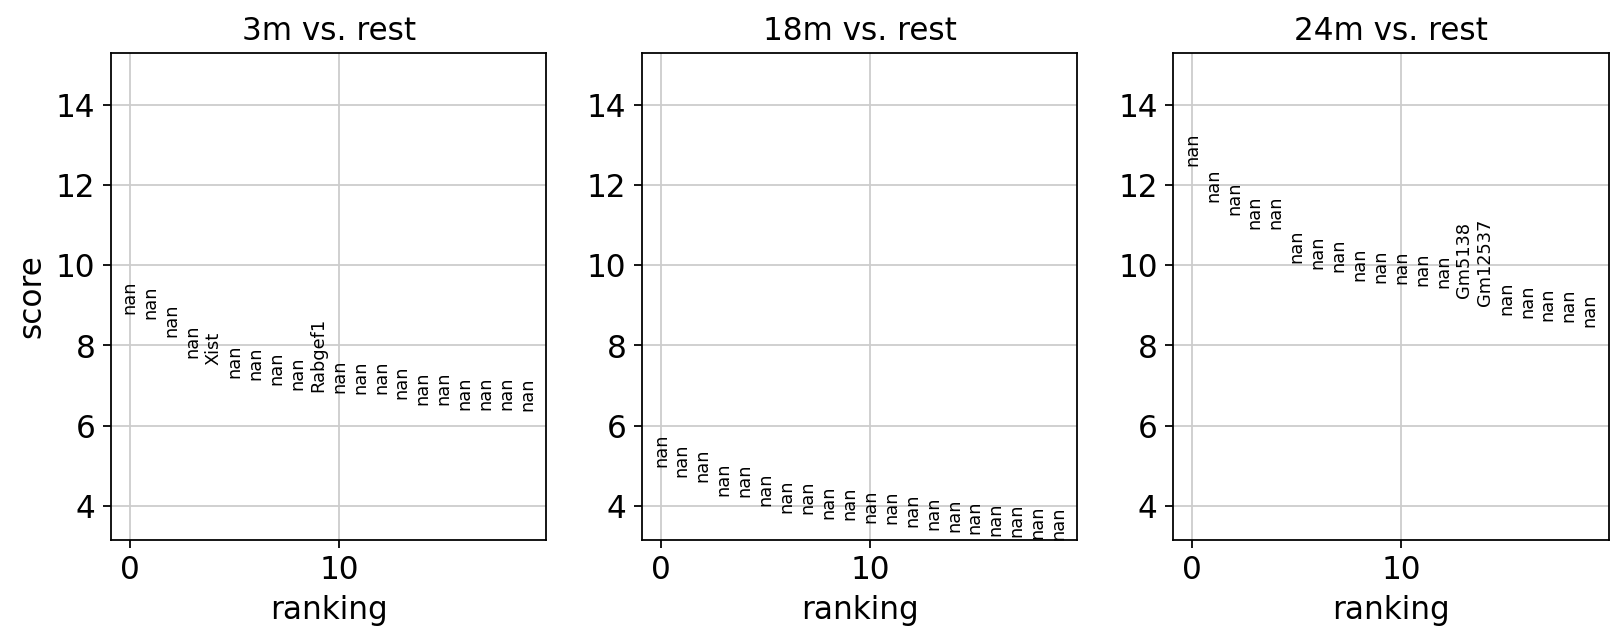

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_age']`


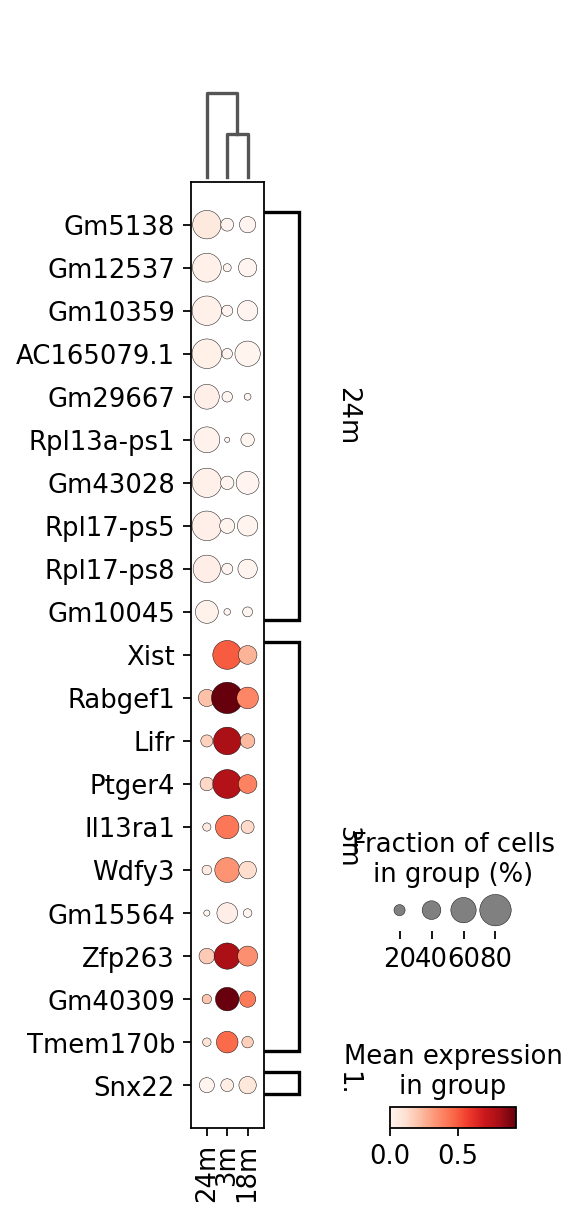

In [77]:
sc.tl.rank_genes_groups(trachea_macropahges, groupby = 'age', method = 'wilcoxon', pts = True)
sc.tl.filter_rank_genes_groups(trachea_macropahges, min_fold_change=2)
sc.pl.rank_genes_groups(trachea_macropahges, key='rank_genes_groups_filtered')
sc.pl.rank_genes_groups_dotplot(trachea_macropahges, key='rank_genes_groups_filtered', swap_axes=True)


## 3m

In [78]:
df = GSEA_DataFrame(trachea_macropahges, '3m')
df_adj = df[df['logfoldchanges']>=0.7]
trachea_3m_sig = list(df_adj['names'])
df_adj

names    scores         pvals     pvals_adj  logfoldchanges
0    Rps28  8.786422  1.543988e-18  4.185134e-14        1.371192
1    Rps29  8.660521  4.696164e-18  8.486281e-14        1.453712
2    Rps25  8.211597  2.182650e-16  1.972097e-12        1.341918
3    Csde1  7.701632  1.343399e-14  1.040405e-10        2.107671
4     Xist  7.504512  6.165768e-14  3.713984e-10        2.773908
..     ...       ...           ...           ...             ...
356  Nuak2  3.887696  1.012002e-04  1.318814e-02        1.133800
358   Krr1  3.886424  1.017316e-04  1.319396e-02        1.835019
359    Hfe  3.881337  1.038836e-04  1.340890e-02        1.180971
360   Tank  3.881337  1.038836e-04  1.340890e-02        1.145309
361  Rragc  3.873071  1.074725e-04  1.383919e-02        1.455241

[350 rows x 5 columns]

In [96]:
#macrophages
enr_trachea_3m = gp.enrichr(gene_list= trachea_3m_sig,
                 gene_sets=['WikiPathways_2019_Mouse',
                            'KEGG_2019_Mouse',
                            'GO_Cellular_Component_2021',
                            'GO_Biological_Process_2021',
                            'GO_Molecular_Function_2021',
                            'GTEx_Aging_Signatures_2021',
                            'Mouse_Gene_Atlas'],
                 organism='Mouse', # don't forget to set organism to the one you desired! e.g. Yeast
                 description='test_name',
                 outdir='test/enrichr_kegg',
                 no_plot=False,
                 cutoff=1.0 # test dataset, use lower value from range(0,1)
                )

df = enr_trachea_3m.results
df = df[df['Adjusted P-value'] <= 0.05].copy() 


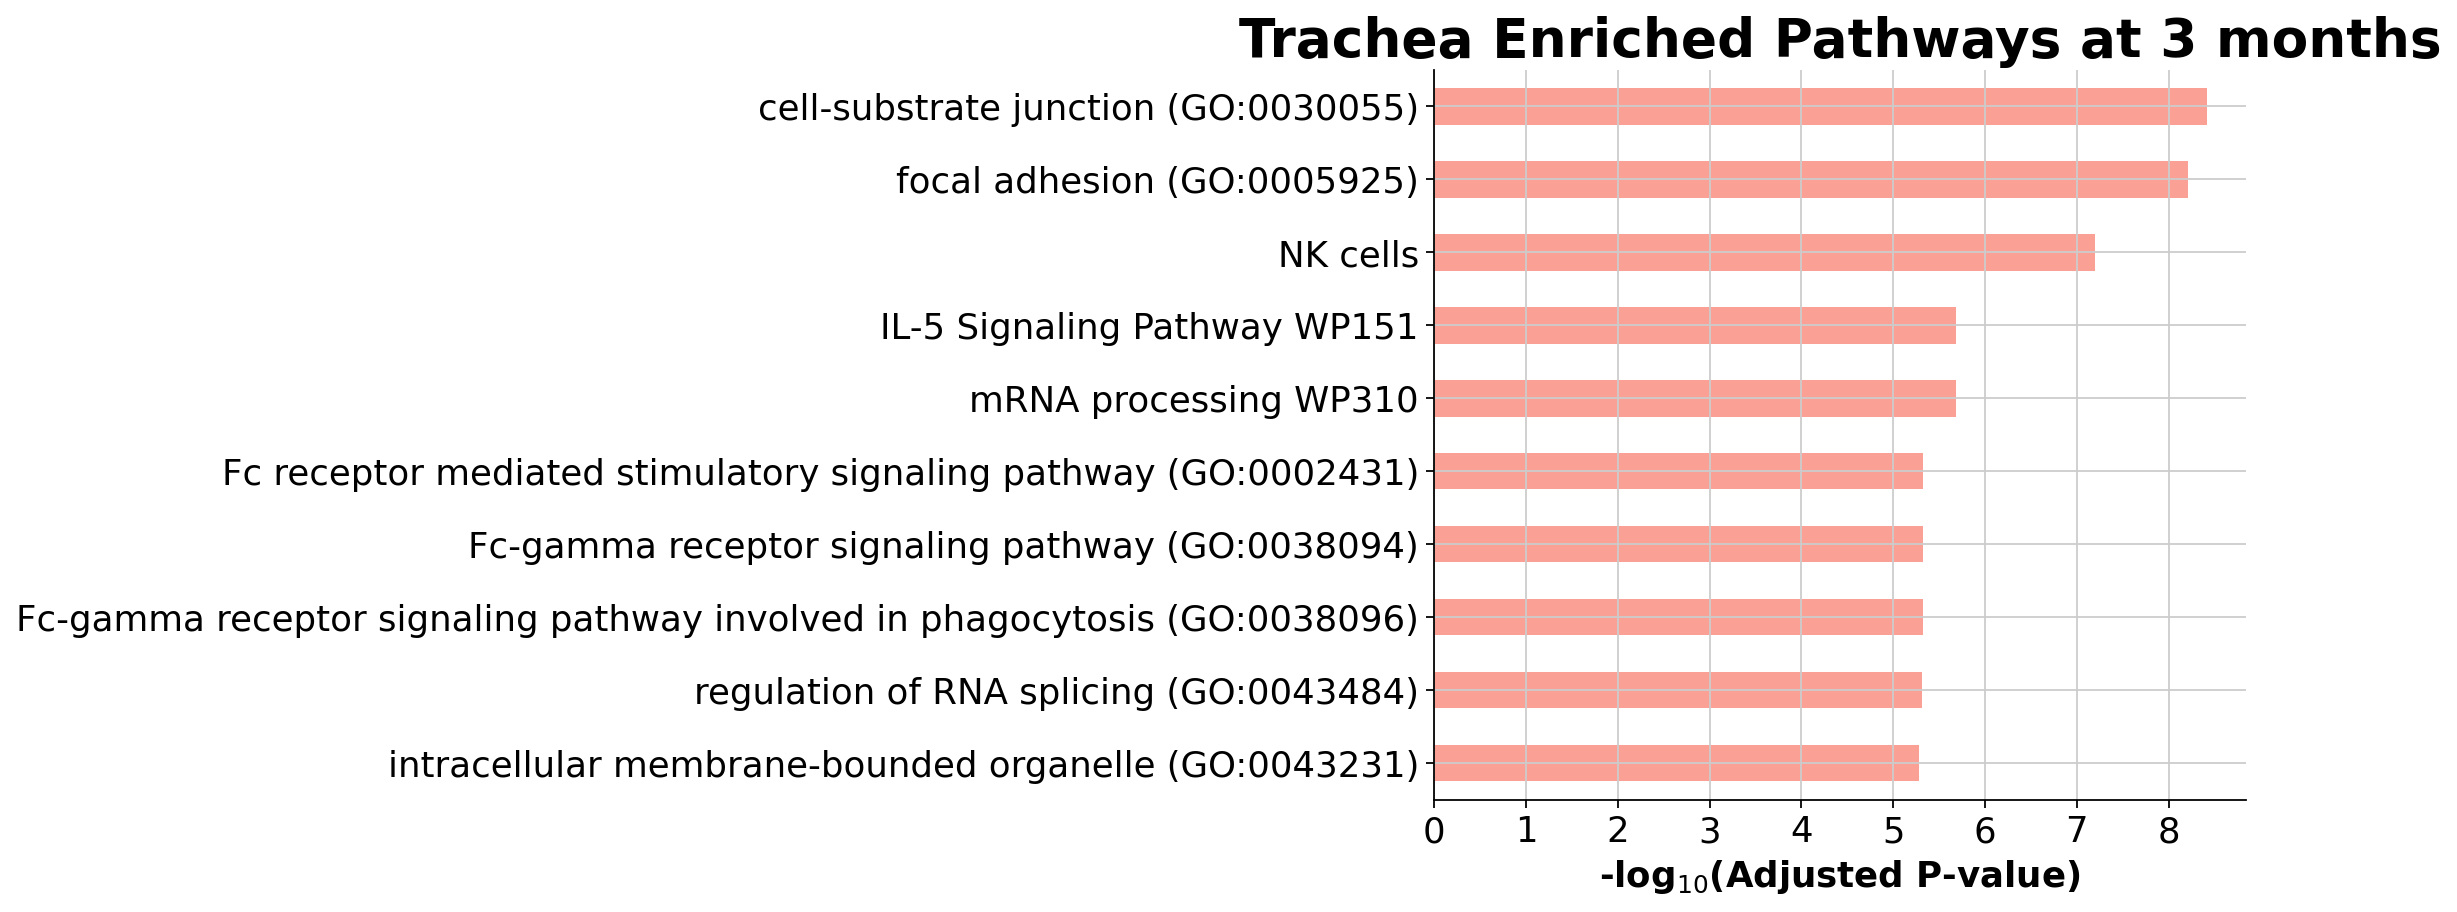

In [97]:
barplot(df,column='Adjusted P-value', cutoff = 1.0, title = 'Trachea Enriched Pathways at 3 months')
plt.savefig('/mnt/ibm_sm/home/lea.mcgeever/ms/notebooks/figures/trachea_GSEA_bar_3m_05262022', dpi=150,bbox_inches='tight')


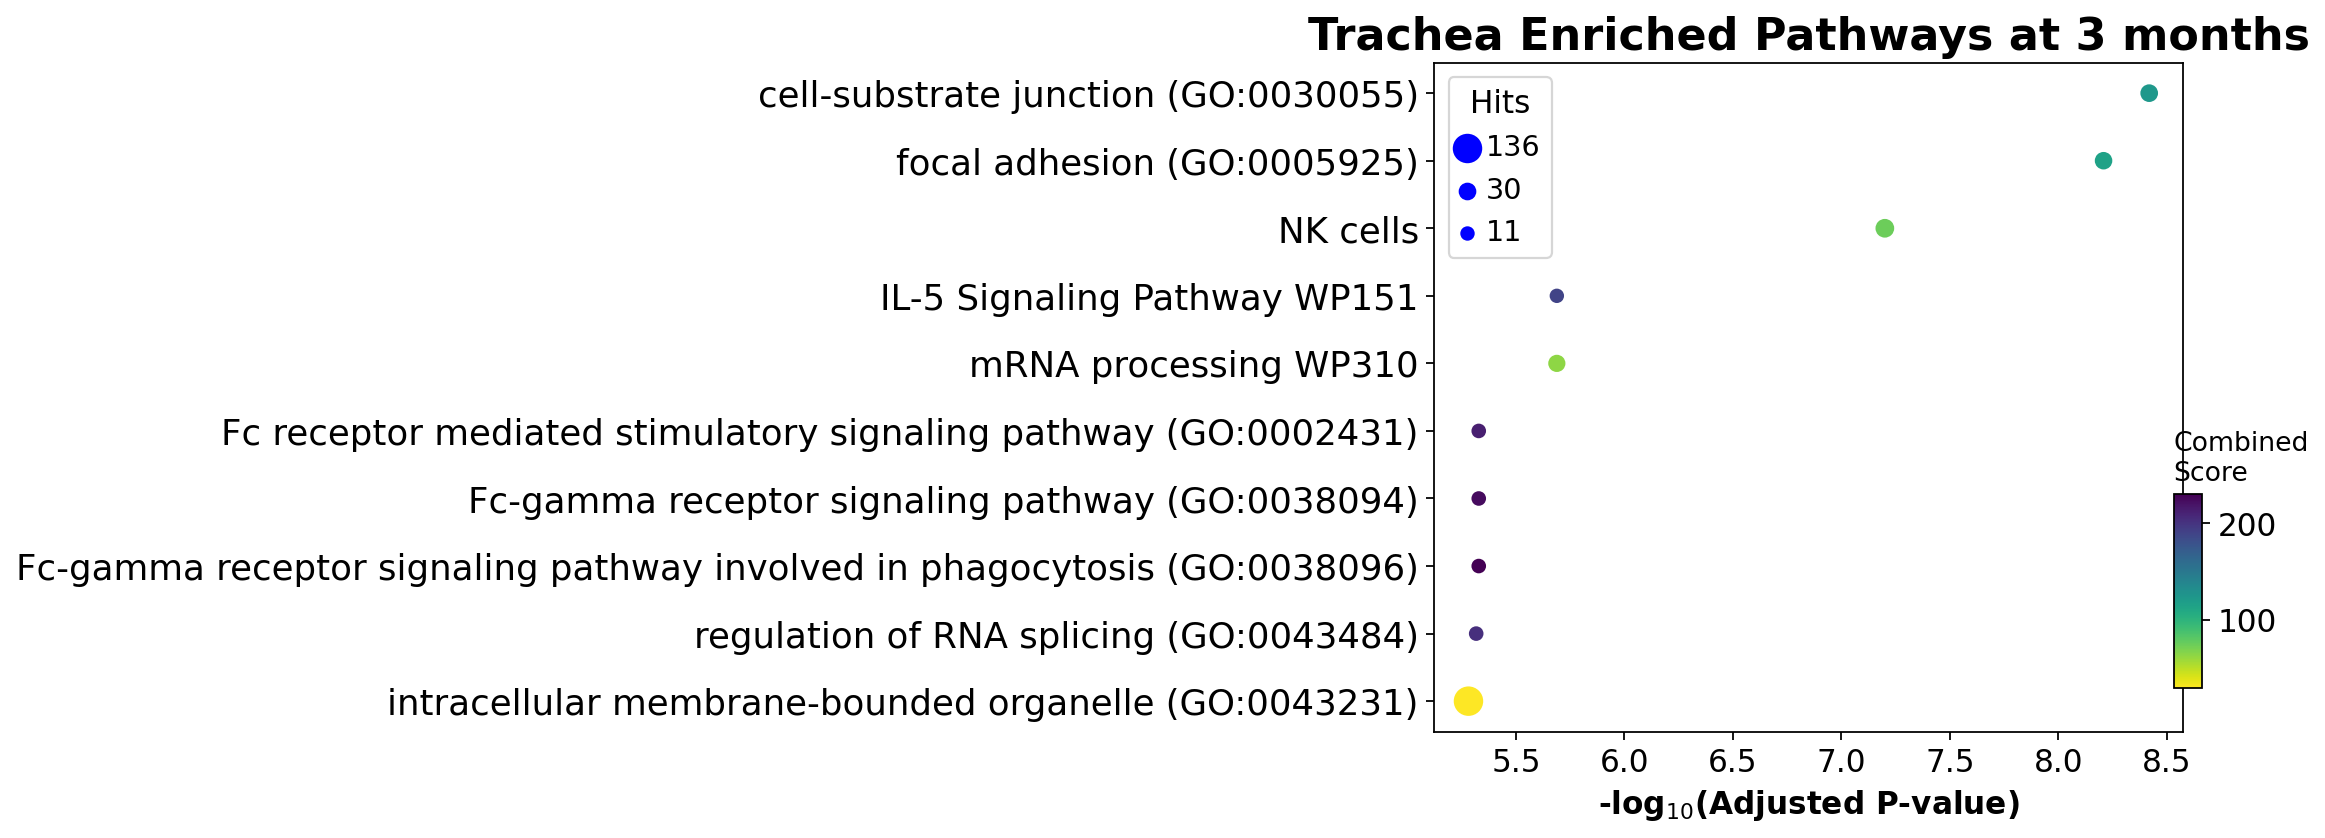

In [98]:

dotplot(df,column='Adjusted P-value', cutoff = 1.0, cmap='viridis_r',title = 'Trachea Enriched Pathways at 3 months')
plt.savefig('/mnt/ibm_sm/home/lea.mcgeever/ms/notebooks/figures/trachea_GSEA_dot_3m_05262022', dpi=150,bbox_inches='tight')


## 18m MT OXPHOS ENRICHED

In [99]:
df = GSEA_DataFrame(trachea_macropahges, '18m')
df_adj = df[df['logfoldchanges']>=0.7]
trachea_18m_sig = list(df_adj['names'])
df_adj

names    scores         pvals  pvals_adj  logfoldchanges
0      Tmsb10  4.977912  6.427365e-07   0.000536        1.329277
1      Cox6a1  4.720578  2.351759e-06   0.001771        0.827405
2      Gm6900  4.602702  4.170459e-06   0.002724        1.065341
4        Elob  4.226937  2.368941e-05   0.012002        0.952467
5       Serf2  4.005020  6.201227e-05   0.026958        0.709901
..        ...       ...           ...        ...             ...
350    Smim27  1.641964  1.005975e-01   1.000000        1.436207
353     Gtf3a  1.637537  1.015184e-01   1.000000        1.044124
356  Slc38a10  1.633663  1.023296e-01   1.000000        0.789292
358    Frmd4b  1.632556  1.025624e-01   1.000000        0.761105
360     Pcbd2  1.629236  1.032631e-01   1.000000        0.935209

[174 rows x 5 columns]

In [100]:
#macrophages
enr_trachea_18m = gp.enrichr(gene_list= trachea_18m_sig,
                 gene_sets=['WikiPathways_2019_Mouse',
                            'KEGG_2019_Mouse',
                            'GO_Cellular_Component_2021',
                            'GO_Biological_Process_2021',
                            'GO_Molecular_Function_2021',
                            'GTEx_Aging_Signatures_2021',
                            'Mouse_Gene_Atlas'],
                 organism='Mouse', # don't forget to set organism to the one you desired! e.g. Yeast
                 description='test_name',
                 outdir='test/enrichr_kegg',
                 no_plot=False,
                 cutoff=1.0 # test dataset, use lower value from range(0,1)
                )

df = enr_trachea_18m.results
df = df[df['Adjusted P-value'] <= 0.05].copy() 
df

Gene_set  \
0        WikiPathways_2019_Mouse   
51               KEGG_2019_Mouse   
52               KEGG_2019_Mouse   
53               KEGG_2019_Mouse   
54               KEGG_2019_Mouse   
55               KEGG_2019_Mouse   
56               KEGG_2019_Mouse   
57               KEGG_2019_Mouse   
193   GO_Cellular_Component_2021   
194   GO_Cellular_Component_2021   
195   GO_Cellular_Component_2021   
343   GO_Biological_Process_2021   
344   GO_Biological_Process_2021   
345   GO_Biological_Process_2021   
1623  GO_Molecular_Function_2021   

                                                   Term Overlap   P-value  \
0                        Electron Transport Chain WP295   7/103  0.000033   
51                            Oxidative phosphorylation   8/134  0.000023   
52                                        Thermogenesis  10/231  0.000036   
53                                    Parkinson disease   8/144  0.000038   
54            Non-alcoholic fatty liver disease (NAFLD)   7/151  0.000361   
55                                    Alzheimer disease   7/175  0.000868   
56                                   Huntington disease   7/192  0.001485   
57    Parathyroid hormone synthesis, secretion and a...   5/107  0.002448   
193           mitochondrial inner membrane (GO:0005743)  10/328  0.000618   
194                 mitochondrial membrane (GO:0031966)  12/469  0.000854   
195               organelle inner membrane (GO:0019866)  10/346  0.000929   
343       aerobic electron transport chain (GO:0019646)    7/70  0.000003   
344   mitochondrial ATP synthesis coupled electron t...    7/71  0.000003   
345   establishment of epithelial cell polarity (GO:...    4/20  0.000024   
1623  oxidoreduction-driven active transmembrane tra...    6/58  0.000011   

      Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0             0.001674            0                     0    8.614646   
51            0.001822            0                     0    7.534902   
52            0.001822            0                     0    5.409171   
53            0.001822            0                     0    6.977321   
54            0.012801            0                     0    5.729125   
55            0.024653            0                     0    4.904691   
56            0.035152            0                     0    4.450138   
57            0.049658            0                     0    5.721081   
193           0.046469            0                     0    3.740604   
194           0.046469            0                     0    3.139476   
195           0.046469            0                     0    3.536948   
343           0.001781            0                     0   13.149035   
344           0.001781            0                     0   12.942927   
345           0.010260            0                     0   29.132353   
1623          0.002091            0                     0   13.581044   

      Combined Score                                              Genes  
0          88.939538     NDUFS5;NDUFA3;ATP5K;NDUFC1;UQCR11;COX6A1;COX5B  
51         80.491851  NDUFS5;NDUFA3;ATP5K;NDUFC1;UQCR11;COX6A1;COX5B...  
52         55.355450  NDUFS5;NDUFA3;ATP5K;UQCR11;NDUFC1;COX6A1;COX5B...  
53         70.925974  PINK1;NDUFS5;NDUFA3;NDUFC1;UQCR11;COX6A1;COX5B...  
54         45.418995     NDUFS5;NDUFA3;NDUFC1;UQCR11;COX6A1;COX5B;COX7C  
55         34.574433     NDUFS5;NDUFA3;UQCR11;NDUFC1;COX6A1;COX5B;COX7C  
56         28.979981     NDUFS5;NDUFA3;UQCR11;NDUFC1;COX6A1;COX5B;COX7C  
57         34.398085                    ATF6B;ARHGEF1;ARRB2;ADCY7;MEF2D  
193        27.639980  PINK1;MRPL51;UQCC2;NDUFS5;NDUFA3;UQCR11;NDUFC1...  
194        22.183341  PINK1;MRPL51;UQCC2;NDUFS5;NDUFA3;UQCR11;NDUFC1...  
195        24.691446  PINK1;MRPL51;UQCC2;NDUFS5;NDUFA3;UQCR11;NDUFC1...  
343       169.474843     NDUFS5;NDUFA3;NDUFC1;UQCR11;COX6A1;COX5B;COX7C  
344       165.569384     NDUFS5;NDUFA3;NDUFC1;UQCR11;COX6A1;COX5B;COX7C  
345      

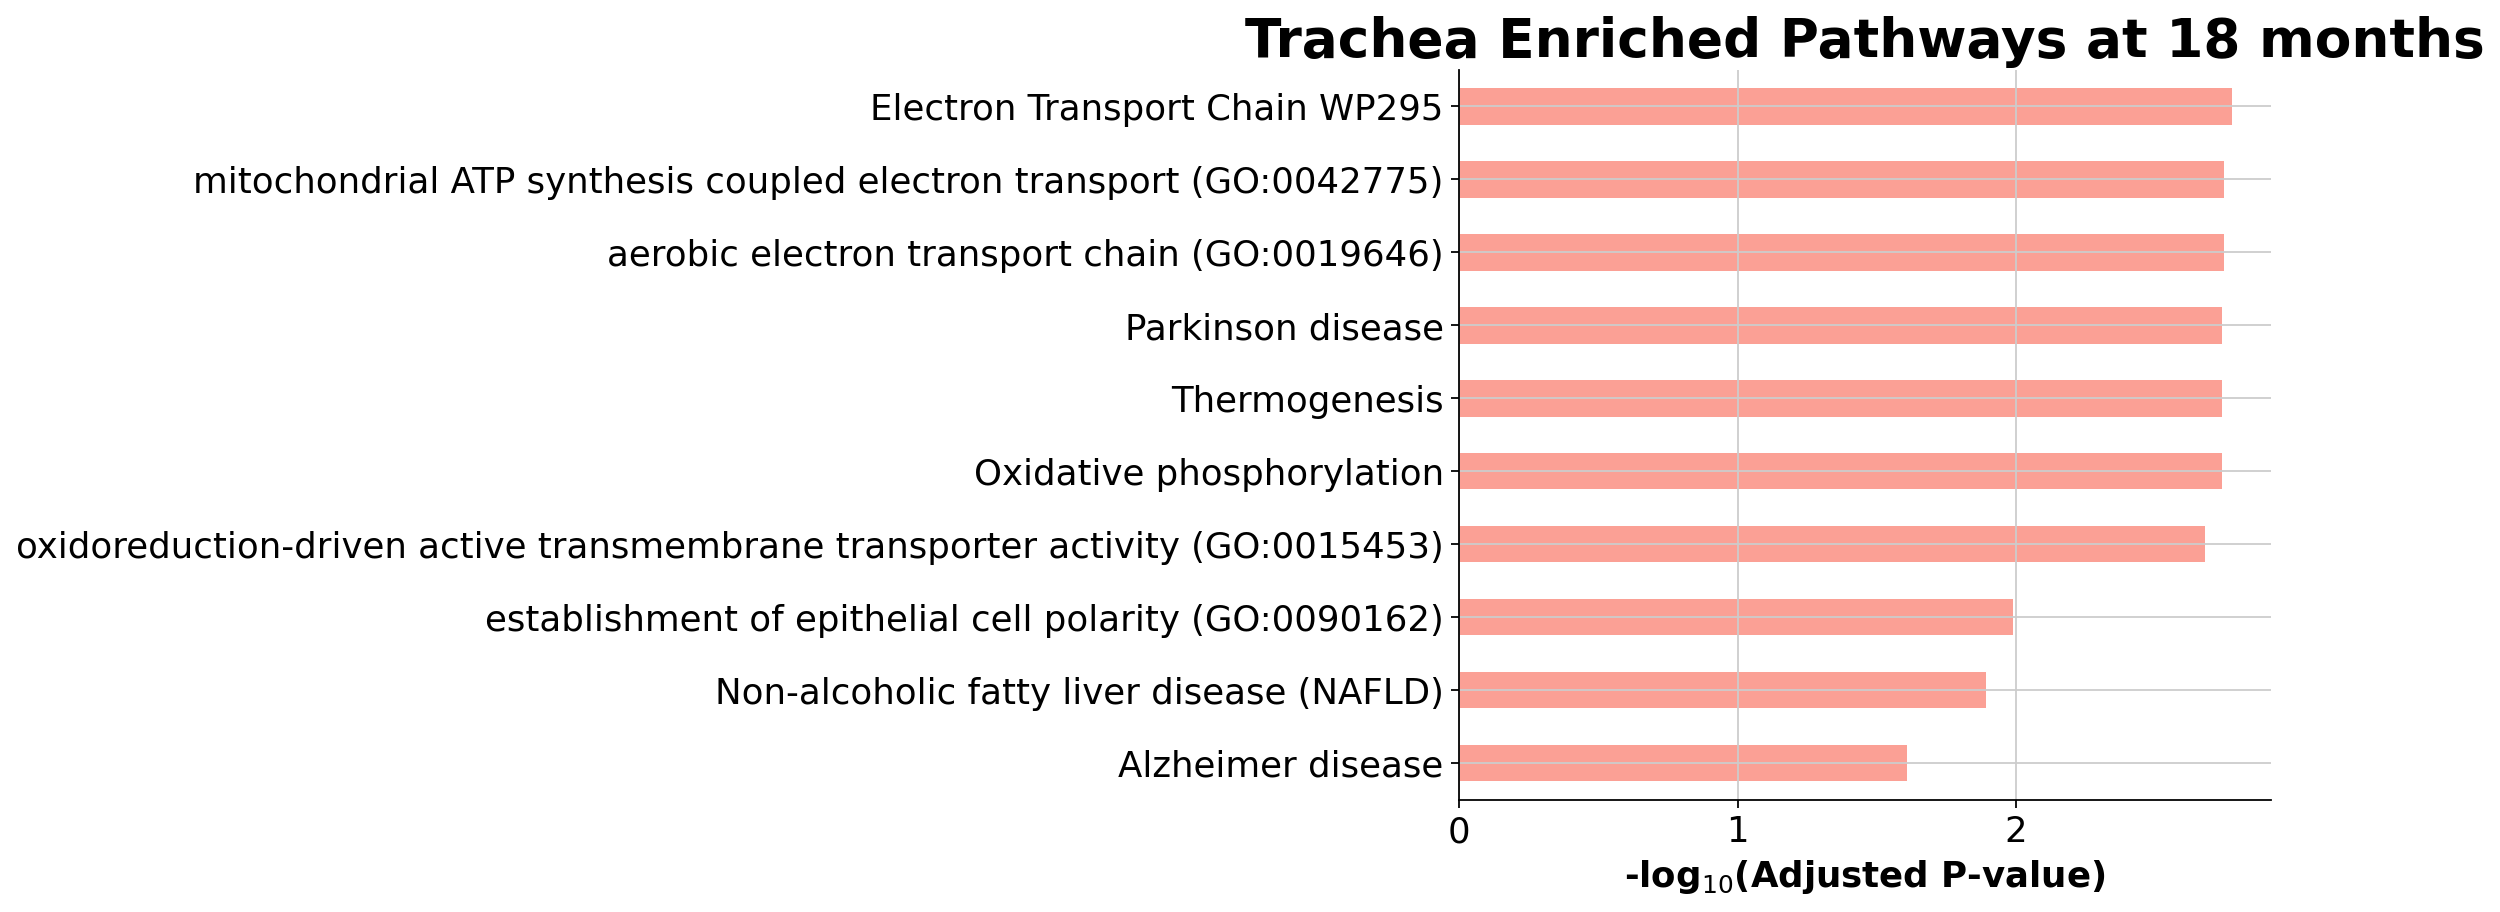

In [101]:
barplot(df,column='Adjusted P-value', cutoff = 1.0,title = 'Trachea Enriched Pathways at 18 months')
plt.savefig('/mnt/ibm_sm/home/lea.mcgeever/ms/notebooks/figures/trachea_GSEA_bar_18m_05262022', dpi=150,bbox_inches='tight')


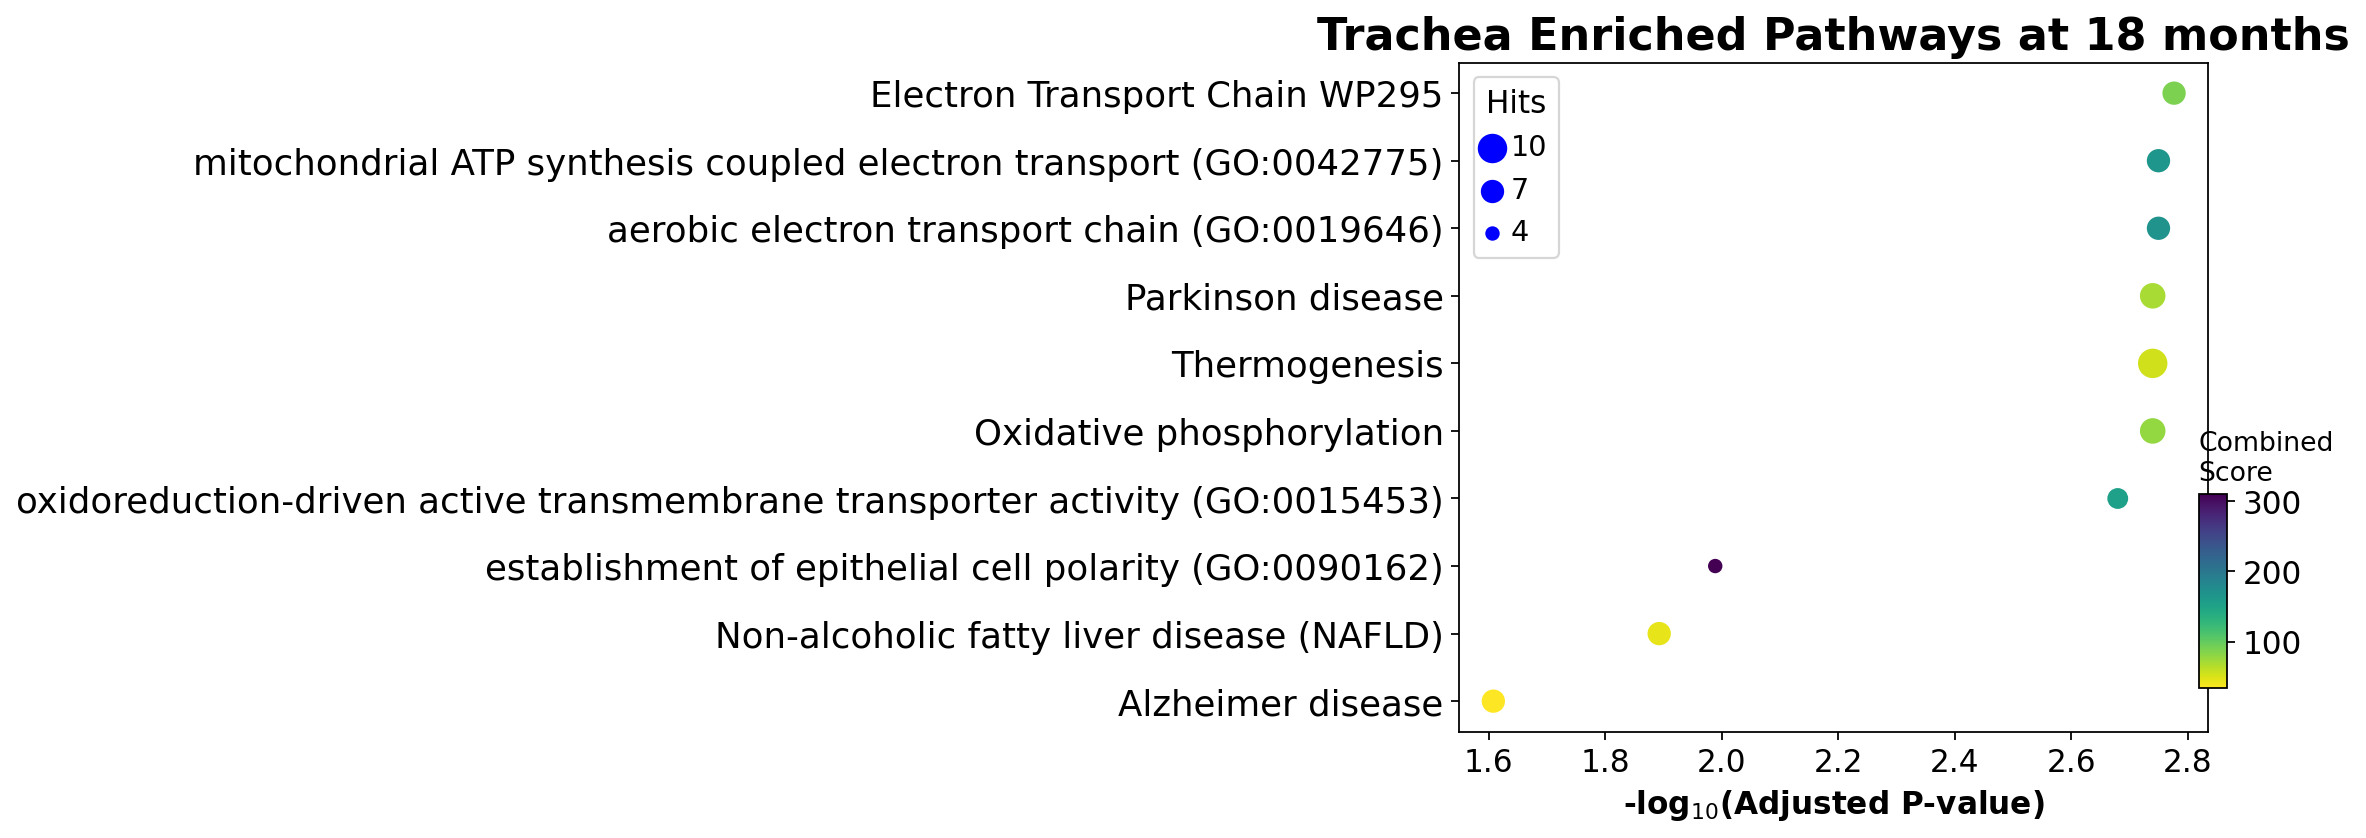

In [102]:

dotplot(df,column='Adjusted P-value', cutoff = 1.0, cmap='viridis_r', title = 'Trachea Enriched Pathways at 18 months')
plt.savefig('/mnt/ibm_sm/home/lea.mcgeever/ms/notebooks/figures/trachea_GSEA_dot_18m_05262022', dpi=150,bbox_inches='tight')


## 24m

In [103]:
df = GSEA_DataFrame(trachea_macropahges, '24m')
df_adj = df[df['logfoldchanges']>=0.7]
trachea_24m_sig = list(df_adj['names'])

In [104]:
#macrophages
enr_trachea_24m = gp.enrichr(gene_list= trachea_24m_sig,
                 gene_sets=['WikiPathways_2019_Mouse',
                            'KEGG_2019_Mouse',
                            'GO_Cellular_Component_2021',
                            'GO_Biological_Process_2021',
                            'GO_Molecular_Function_2021',
                            'GTEx_Aging_Signatures_2021',
                            'Mouse_Gene_Atlas'],
                 organism='Mouse', # don't forget to set organism to the one you desired! e.g. Yeast
                 description='test_name',
                 outdir='test/enrichr_kegg',
                 no_plot=False,
                 cutoff=1.0 # test dataset, use lower value from range(0,1)
                )

df = enr_trachea_24m.results
df = df[df['Adjusted P-value'] <= 0.05].copy() 


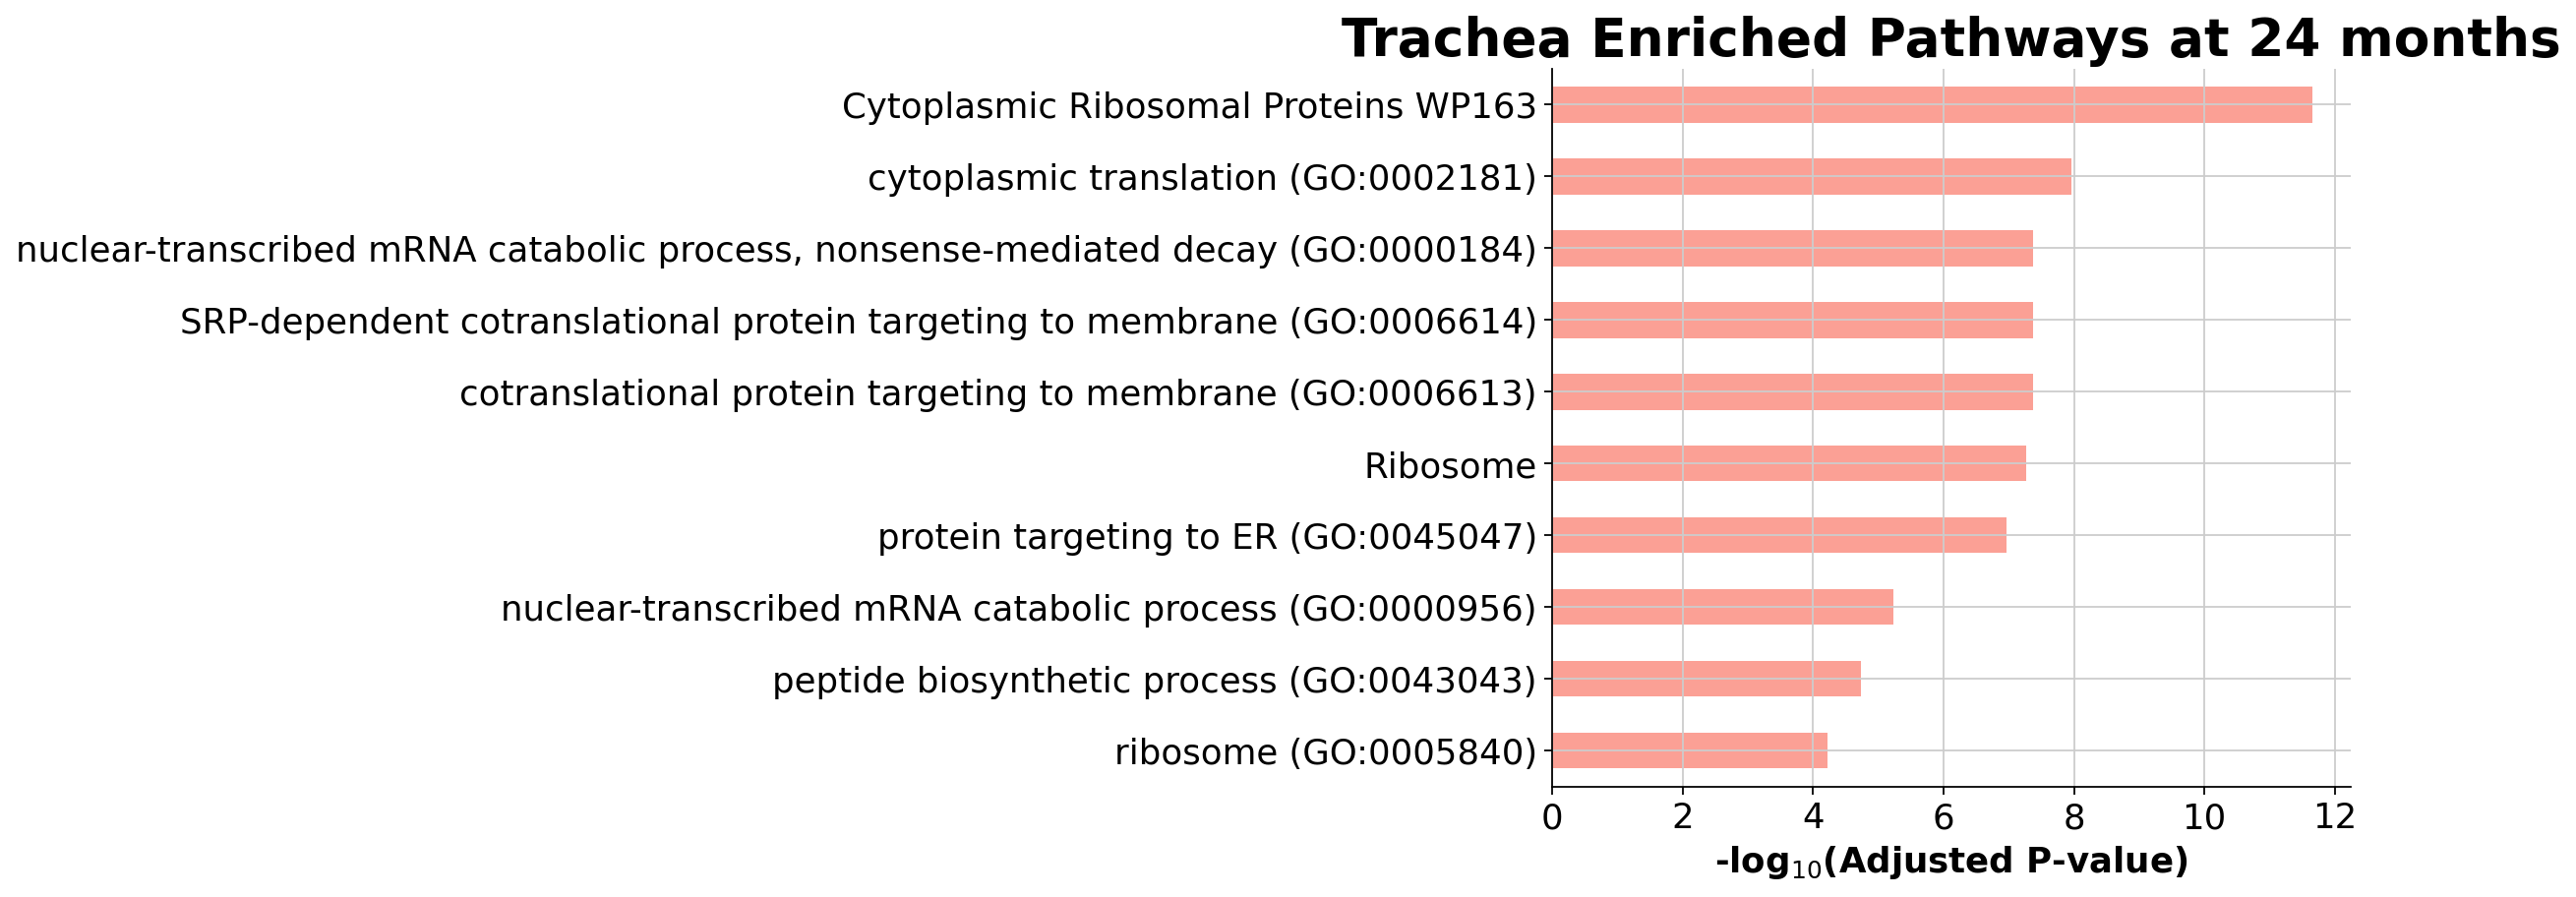

In [105]:
barplot(df,column='Adjusted P-value', cutoff = 1.0, title = 'Trachea Enriched Pathways at 24 months')
plt.savefig('/mnt/ibm_sm/home/lea.mcgeever/ms/notebooks/figures/trachea_GSEA_bar_24m_05262022', dpi=150,bbox_inches='tight')



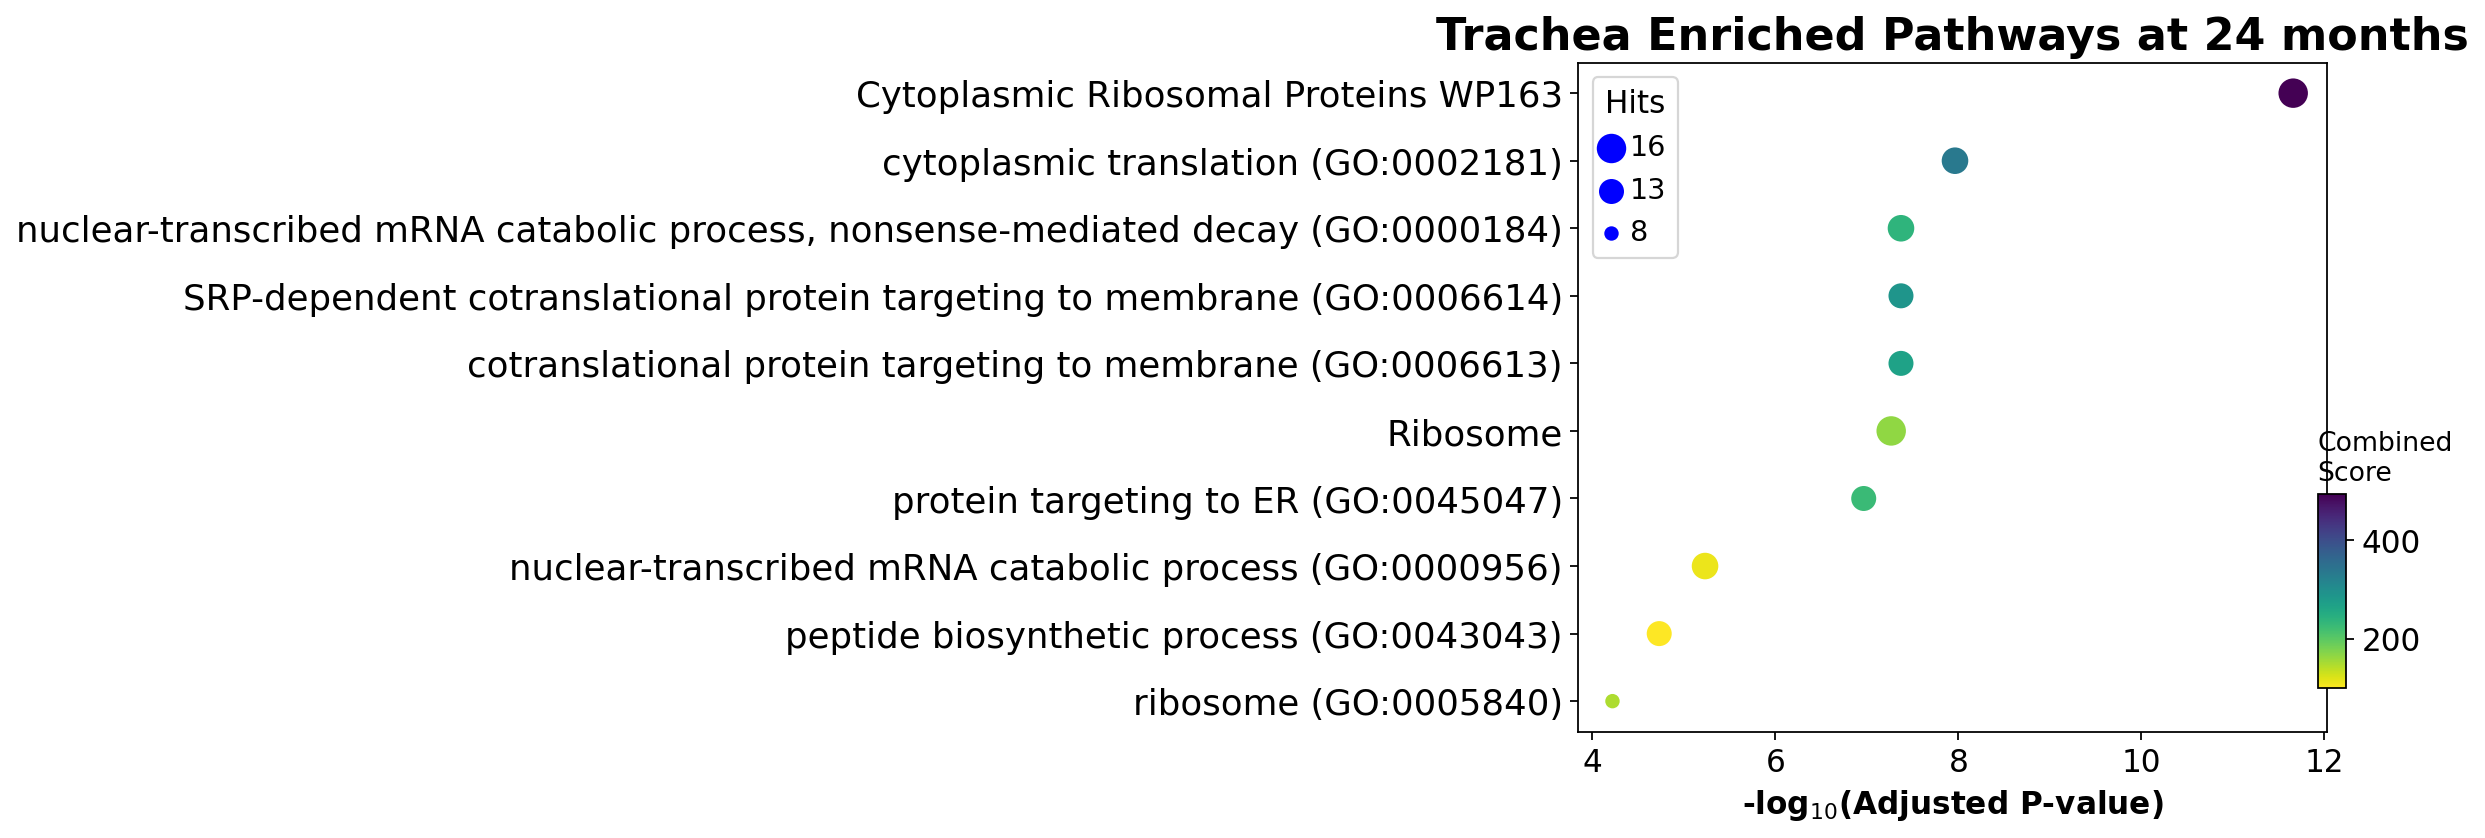

In [106]:
dotplot(df,column='Adjusted P-value', cutoff = 1.0, cmap='viridis_r', title = 'Trachea Enriched Pathways at 24 months')
plt.savefig('/mnt/ibm_sm/home/lea.mcgeever/ms/notebooks/figures/trachea_GSEA_dot_24m_05262022', dpi=150,bbox_inches='tight')


## statannot

In [24]:
oxphos


NameError: name 'oxphos' is not defined

In [23]:
adata_trachea1 = adata_trachea.copy()
sc.tl.score_genes(adata_trachea1, oxphos_genes, score_name = 'OXPHOS')
adata_trachea1 = remove_cats(adata_trachea1)

NameError: name 'oxphos_genes' is not defined

In [ ]:
def TRACHEA_gene_expression_df(adata, genelist):
    '''Takes adata object and a list of genes. 
    Returns a pandas dataframe where genes and their expression values are columns in dataframe of adata.'''
    df = adata.obs.copy()
    
    for g in genelist:
        df[g] = adata_trachea[:,g].X.toarray().flatten()
    return df 

adata_trachea_obs = gene_expression_obs(adata_trachea, trachea_18m_sig)
adata_trachea_obs = remove_cats(adata_trachea_obs)
trachea_df = TRACHEA_gene_expression_df(adata_trachea_obs, trachea_18m_sig)

In [ ]:
mt_trachea_obs = gene_expression_obs(adata_trachea, mt_genes)
mt_trachea_obs = remove_cats(mt_trachea_obs)
mt_trachea_df = TRACHEA_gene_expression_df(adata_trachea_obs, mt_genes)

In [ ]:
tracheaOXPHOS_obs = gene_expression_obs(adata_trachea1, oxphos_genes)
tracheaOXPHOS_obs = remove_cats(tracheaOXPHOS_obs)
tracheaOXPHOS = TRACHEA_gene_expression_df(tracheaOXPHOS_obs, oxphos_genes)

<ipython-input-208-5a0adf206e01>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["age_months"] = [int(e[:-1]) for e in df.age]


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

T cell_3m v.s. T cell_18m: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.553e+03
T cell_18m v.s. T cell_24m: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.839e-06 U_stat=8.439e+03
basal epithelial cell of tracheobronchial tree_3m v.s. basal epithelial cell of tracheobronchial tree_18m: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.307e-04 U_stat=8.338e+03
basal epithelial cell of tracheobronchial tree_18m v.s. basal epithelial cell of tracheobronchial tree_24m: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.323e+04
ciliated columnar cell of tracheobronchial tree_3m v.s. ciliated columnar cell of tracheobronchial tree_18m: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, 

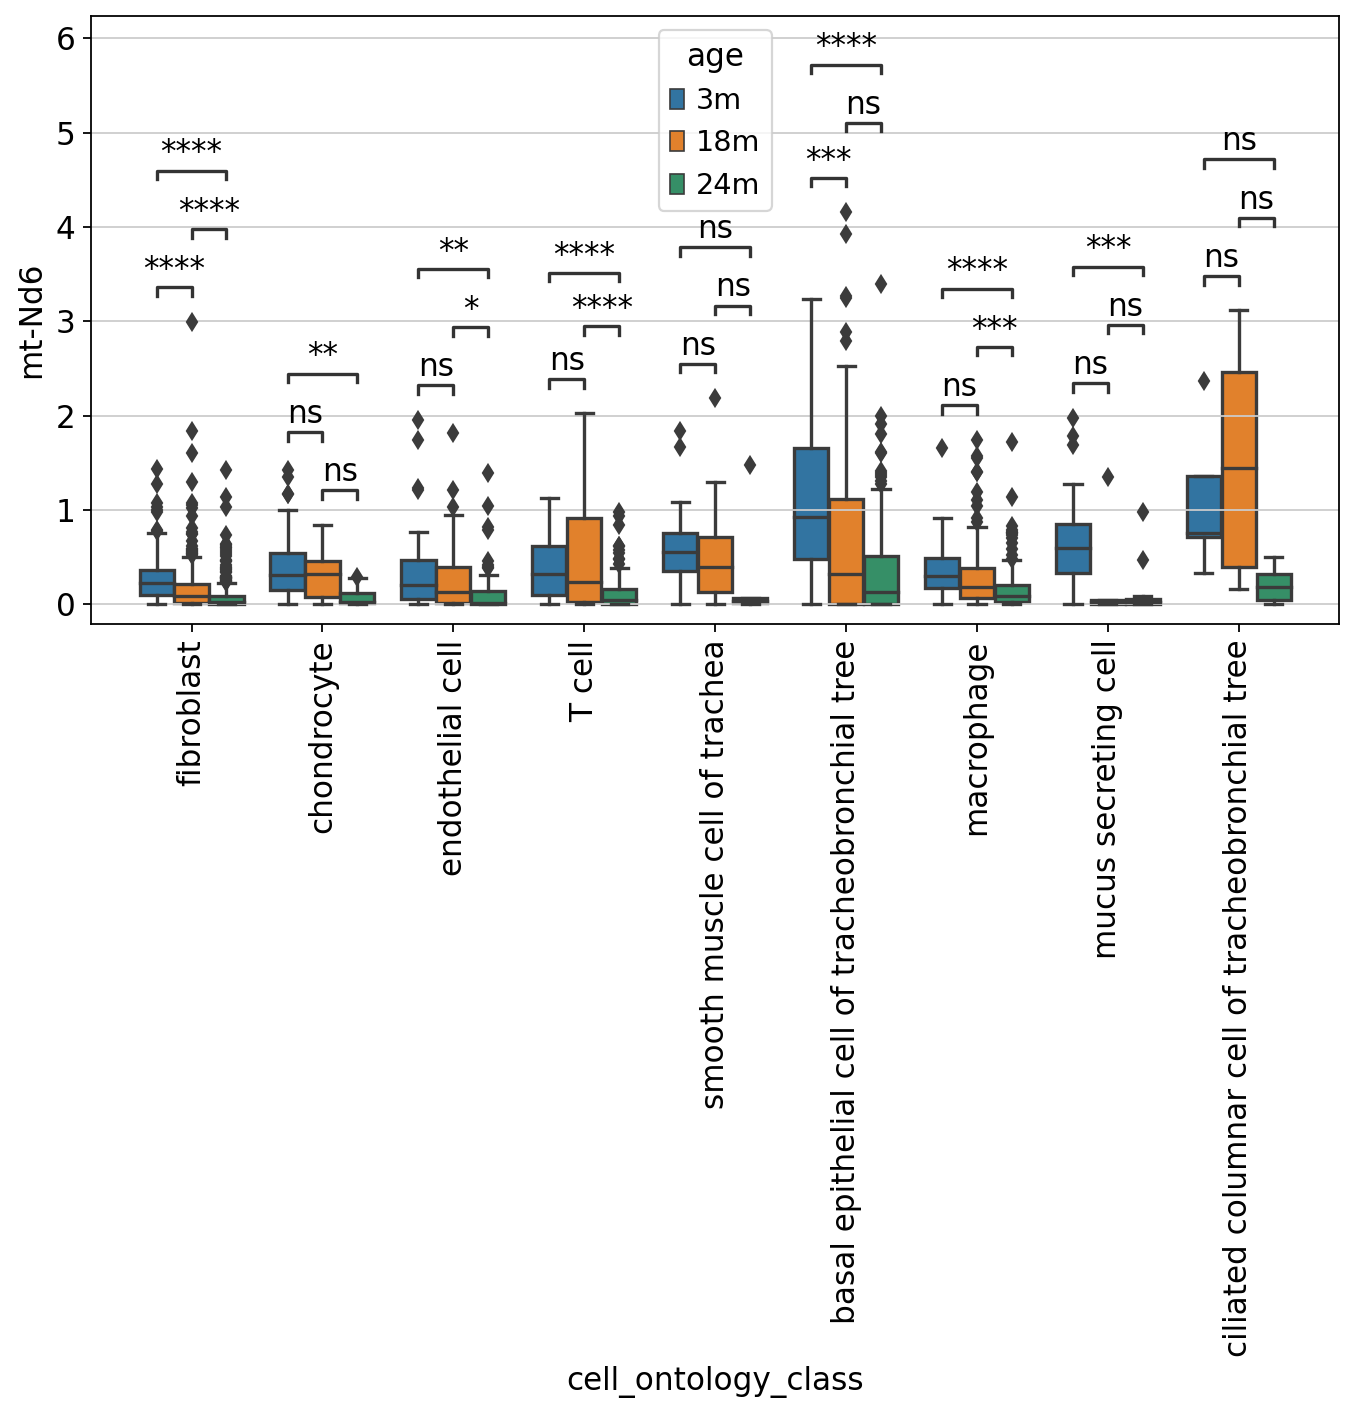

In [208]:
df = mt_trachea_df[['age','cell_ontology_class','mt-Nd6']]
df["age_months"] = [int(e[:-1]) for e in df.age]
df = df.sort_values("age_months")
mask = df['cell_ontology_class'].isin(['T cell',
 'basal epithelial cell of tracheobronchial tree',
 'chondrocyte',
 'ciliated columnar cell of tracheobronchial tree',
 'endothelial cell',
 'fibroblast',
 'macrophage',
 'mucus secreting cell',
 'smooth muscle cell of trachea'])
df = df[mask]

x = "cell_ontology_class" 
y = "mt-Nd6" 
hue = 'age'
hue_order = ['3m', '18m', '24m']

box_pairs=[
    (("T cell", "3m"), ("T cell", "18m")),
    (("T cell", "3m"), ("T cell", "24m")),
    (("T cell", "18m"), ("T cell", "24m")),
    
    (("basal epithelial cell of tracheobronchial tree", "3m"), ("basal epithelial cell of tracheobronchial tree", "18m")),
    (("basal epithelial cell of tracheobronchial tree", "3m"), ("basal epithelial cell of tracheobronchial tree", "24m")),
    (("basal epithelial cell of tracheobronchial tree", "18m"), ("basal epithelial cell of tracheobronchial tree", "24m")),
    
    (("ciliated columnar cell of tracheobronchial tree", "3m"), ("ciliated columnar cell of tracheobronchial tree", "18m")),
    (("ciliated columnar cell of tracheobronchial tree", "3m"), ("ciliated columnar cell of tracheobronchial tree", "24m")),
    (("ciliated columnar cell of tracheobronchial tree", "18m"), ("ciliated columnar cell of tracheobronchial tree", "24m")),
    
    (("endothelial cell", "3m"), ("endothelial cell", "18m")),
    (("endothelial cell", "3m"), ("endothelial cell", "24m")),
    (("endothelial cell", "18m"), ("endothelial cell", "24m")),
    
    (("fibroblast", "3m"), ("fibroblast", "18m")),
    (("fibroblast", "3m"), ("fibroblast", "24m")),
    (("fibroblast", "18m"), ("fibroblast", "24m")),
    
    (("macrophage", "3m"), ("macrophage", "18m")),
    (("macrophage", "3m"), ("macrophage", "24m")),
    (("macrophage", "18m"), ("macrophage", "24m")),
    
    (("mucus secreting cell", "3m"), ("mucus secreting cell", "18m")),
    (("mucus secreting cell", "3m"), ("mucus secreting cell", "24m")),
    (("mucus secreting cell", "18m"), ("mucus secreting cell", "24m")),
    
    (("chondrocyte", "3m"), ("chondrocyte", "18m")),
    (("chondrocyte", "3m"), ("chondrocyte", "24m")),
    (("chondrocyte", "18m"), ("chondrocyte", "24m")),
    
    (("smooth muscle cell of trachea", "3m"), ("smooth muscle cell of trachea", "18m")),
    (("smooth muscle cell of trachea", "3m"), ("smooth muscle cell of trachea", "24m")),
    (("smooth muscle cell of trachea", "18m"), ("smooth muscle cell of trachea", "24m"))
    ]
fig = plt.figure(figsize=(10, 5))
plt.legend(bbox_to_anchor=(.65, 1.25))
#plt.legend(bbox_to_anchor=(2, 2), loc='best', borderaxespad=0, facecolor = 'white')
plt.xticks(rotation=90)
ax = sns.boxplot(data=df, x=x, y=y, hue=hue)
add_stat_annotation(ax, data=df, x=x, y=y,hue=hue,box_pairs=box_pairs,
                    test='Mann-Whitney',loc='inside',verbose=2)

#plt.savefig('/mnt/ibm_sm/home/lea.mcgeever/ms/notebooks/figures/trachea_mt-Nd6_statannot_05262022', dpi=150,bbox_inches='tight')


<ipython-input-184-a0eb737e2a47>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["age_months"] = [int(e[:-1]) for e in df.age]


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

T cell_3m v.s. T cell_18m: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.443e+03
T cell_18m v.s. T cell_24m: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=5.330e+03
basal epithelial cell of tracheobronchial tree_3m v.s. basal epithelial cell of tracheobronchial tree_18m: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=6.340e+03
basal epithelial cell of tracheobronchial tree_18m v.s. basal epithelial cell of tracheobronchial tree_24m: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.467e-02 U_stat=1.365e+04
ciliated columnar cell of tracheobronchial tree_3m v.s. ciliated columnar cell of tracheobronchial tree_18m: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, 

(<AxesSubplot:xlabel='cell_ontology_class', ylabel='Rexo2'>,
  <statannot.StatResult.StatResult at 0x7f5f4515ebe0>])

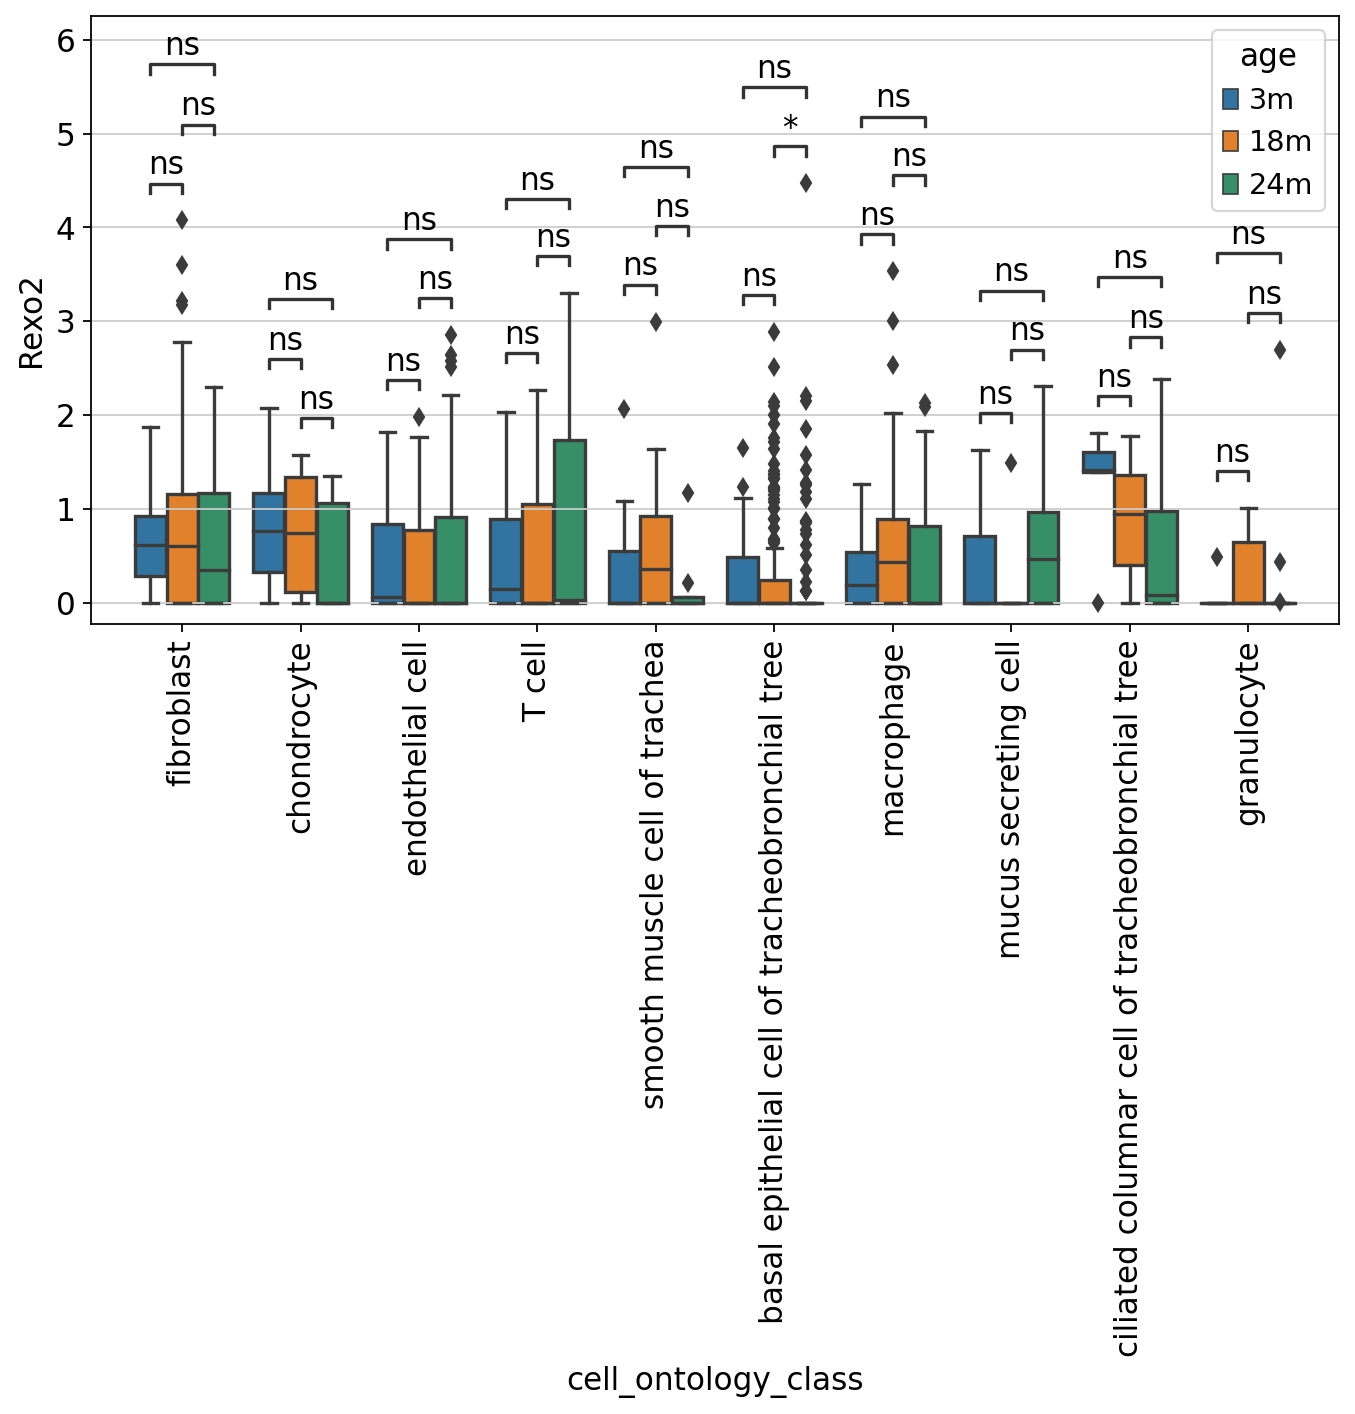

In [184]:
df = trachea_df[['age','cell_ontology_class','Rexo2']]
df["age_months"] = [int(e[:-1]) for e in df.age]
df = df.sort_values("age_months")
mask = df['cell_ontology_class'].isin(['T cell',
 'basal epithelial cell of tracheobronchial tree',
 'chondrocyte',
 'ciliated columnar cell of tracheobronchial tree',
 'endothelial cell',
 'fibroblast',
 'granulocyte',
 'macrophage',
 'mucus secreting cell',
 'smooth muscle cell of trachea'])
df = df[mask]

x = "cell_ontology_class" 
y = "Rexo2" 
hue = 'age'
hue_order = ['3m', '18m', '24m']

box_pairs=box_pairs=[
    (("T cell", "3m"), ("T cell", "18m")),
    (("T cell", "3m"), ("T cell", "24m")),
    (("T cell", "18m"), ("T cell", "24m")),
    
    (("basal epithelial cell of tracheobronchial tree", "3m"), ("basal epithelial cell of tracheobronchial tree", "18m")),
    (("basal epithelial cell of tracheobronchial tree", "3m"), ("basal epithelial cell of tracheobronchial tree", "24m")),
    (("basal epithelial cell of tracheobronchial tree", "18m"), ("basal epithelial cell of tracheobronchial tree", "24m")),
    
    (("ciliated columnar cell of tracheobronchial tree", "3m"), ("ciliated columnar cell of tracheobronchial tree", "18m")),
    (("ciliated columnar cell of tracheobronchial tree", "3m"), ("ciliated columnar cell of tracheobronchial tree", "24m")),
    (("ciliated columnar cell of tracheobronchial tree", "18m"), ("ciliated columnar cell of tracheobronchial tree", "24m")),
    
    (("granulocyte", "3m"), ("granulocyte", "18m")),
    (("granulocyte", "3m"), ("granulocyte", "24m")),
    (("granulocyte", "18m"), ("granulocyte", "24m")),
    
    (("endothelial cell", "3m"), ("endothelial cell", "18m")),
    (("endothelial cell", "3m"), ("endothelial cell", "24m")),
    (("endothelial cell", "18m"), ("endothelial cell", "24m")),
    
    (("fibroblast", "3m"), ("fibroblast", "18m")),
    (("fibroblast", "3m"), ("fibroblast", "24m")),
    (("fibroblast", "18m"), ("fibroblast", "24m")),
    
    (("macrophage", "3m"), ("macrophage", "18m")),
    (("macrophage", "3m"), ("macrophage", "24m")),
    (("macrophage", "18m"), ("macrophage", "24m")),
    
    (("mucus secreting cell", "3m"), ("mucus secreting cell", "18m")),
    (("mucus secreting cell", "3m"), ("mucus secreting cell", "24m")),
    (("mucus secreting cell", "18m"), ("mucus secreting cell", "24m")),
    
    (("chondrocyte", "3m"), ("chondrocyte", "18m")),
    (("chondrocyte", "3m"), ("chondrocyte", "24m")),
    (("chondrocyte", "18m"), ("chondrocyte", "24m")),
    
    (("smooth muscle cell of trachea", "3m"), ("smooth muscle cell of trachea", "18m")),
    (("smooth muscle cell of trachea", "3m"), ("smooth muscle cell of trachea", "24m")),
    (("smooth muscle cell of trachea", "18m"), ("smooth muscle cell of trachea", "24m"))
    ]
fig = plt.figure(figsize=(10, 5))
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
plt.xticks(rotation=90)
ax = sns.boxplot(data=df, x=x, y=y, hue=hue)
add_stat_annotation(ax, data=df, x=x, y=y,hue=hue,box_pairs=box_pairs,
                    test='Mann-Whitney',loc='inside',verbose=2)

#plt.savefig('/mnt/ibm_sm/home/lea.mcgeever/ms/notebooks/figures/trachea_Atp5k_statannot_05262022', dpi=150,bbox_inches='tight')


In [ ]:
df = trachea_df[['age','cell_ontology_class','Rpl17-ps5']]
df["age_months"] = [int(e[:-1]) for e in df.age]
df = df.sort_values("age_months")
mask = df['cell_ontology_class'].isin(['T cell','basal epithelial cell of tracheobronchial tree','chondrocyte',
                                      'endothelial cell','fibroblast','macrophage','granulocyte',
                                       'ciliated columnar cell of tracheobronchial tree',
                                      'mucus secreting cell','smooth muscle cell of trachea'])
df = df[mask]

x = "cell_ontology_class" 
y = "Rpl17-ps5" 
hue = 'age'
hue_order = ['3m', '18m', '24m']

box_pairs=[
    (("T cell", "3m"), ("T cell", "18m")),
    (("T cell", "3m"), ("T cell", "24m")),
    (("T cell", "18m"), ("T cell", "24m")),
    
    (("basal epithelial cell of tracheobronchial tree", "3m"), ("basal epithelial cell of tracheobronchial tree", "18m")),
    (("basal epithelial cell of tracheobronchial tree", "3m"), ("basal epithelial cell of tracheobronchial tree", "24m")),
    (("basal epithelial cell of tracheobronchial tree", "18m"), ("basal epithelial cell of tracheobronchial tree", "24m")),
    
    (("chondrocyte", "3m"), ("chondrocyte", "18m")),
    (("chondrocyte", "3m"), ("chondrocyte", "24m")),
    (("chondrocyte", "18m"), ("chondrocyte", "24m")),
    
    (("ciliated columnar cell of tracheobronchial tree", "3m"), ("ciliated columnar cell of tracheobronchial tree", "18m")),
    (("ciliated columnar cell of tracheobronchial tree", "3m"), ("ciliated columnar cell of tracheobronchial tree", "24m")),
    (("ciliated columnar cell of tracheobronchial tree", "18m"), ("ciliated columnar cell of tracheobronchial tree", "24m")),
    
    (("endothelial cell", "3m"), ("endothelial cell", "18m")),
    (("endothelial cell", "3m"), ("endothelial cell", "24m")),
    (("endothelial cell", "18m"), ("endothelial cell", "24m")),
    
    (("fibroblast", "3m"), ("fibroblast", "18m")),
    (("fibroblast", "3m"), ("fibroblast", "24m")),
    (("fibroblast", "18m"), ("fibroblast", "24m")),
    
    (("granulocyte", "3m"), ("granulocyte", "18m")),
    (("granulocyte", "3m"), ("granulocyte", "24m")),
    (("granulocyte", "18m"), ("granulocyte", "24m")),
    
    (("macrophage", "3m"), ("macrophage", "18m")),
    (("macrophage", "3m"), ("macrophage", "24m")),
    (("macrophage", "18m"), ("macrophage", "24m")),
    
    (("mucus secreting cell", "3m"), ("mucus secreting cell", "18m")),
    (("mucus secreting cell", "3m"), ("mucus secreting cell", "24m")),
    (("mucus secreting cell", "18m"), ("mucus secreting cell", "24m")),
    
    (("smooth muscle cell of trachea", "3m"), ("smooth muscle cell of trachea", "18m")),
    (("smooth muscle cell of trachea", "3m"), ("smooth muscle cell of trachea", "24m")),
    (("smooth muscle cell of trachea", "18m"), ("smooth muscle cell of trachea", "24m")),
    ]
fig = plt.figure(figsize=(10, 5))
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
plt.xticks(rotation=90)
ax = sns.boxplot(data=df, x=x, y=y, hue=hue)
add_stat_annotation(ax, data=df, x=x, y=y,hue=hue,box_pairs=box_pairs,
                    test='Mann-Whitney',loc='inside',verbose=2)

In [ ]:
df = trachea_df[['age','cell_ontology_class','Gm43028']]
df["age_months"] = [int(e[:-1]) for e in df.age]
df = df.sort_values("age_months")
mask = df['cell_ontology_class'].isin(['T cell','basal epithelial cell of tracheobronchial tree','chondrocyte',
                                      'endothelial cell','fibroblast','macrophage',
                                      'ciliated columnar cell of tracheobronchial tree','smooth muscle cell of trachea'])
df = df[mask]

x = "cell_ontology_class" 
y = "Gm43028" 
hue = 'age'
hue_order = ['3m', '18m', '24m']

box_pairs=[
    (("T cell", "3m"), ("T cell", "18m")),
    (("T cell", "3m"), ("T cell", "24m")),
    (("T cell", "18m"), ("T cell", "24m")),
    
    (("basal epithelial cell of tracheobronchial tree", "3m"), ("basal epithelial cell of tracheobronchial tree", "18m")),
    (("basal epithelial cell of tracheobronchial tree", "3m"), ("basal epithelial cell of tracheobronchial tree", "24m")),
    (("basal epithelial cell of tracheobronchial tree", "18m"), ("basal epithelial cell of tracheobronchial tree", "24m")),
    
    (("chondrocyte", "3m"), ("chondrocyte", "18m")),
    (("chondrocyte", "3m"), ("chondrocyte", "24m")),
    (("chondrocyte", "18m"), ("chondrocyte", "24m")),
    
    (("ciliated columnar cell of tracheobronchial tree", "3m"), ("ciliated columnar cell of tracheobronchial tree", "18m")),
    (("ciliated columnar cell of tracheobronchial tree", "3m"), ("ciliated columnar cell of tracheobronchial tree", "24m")),
    (("ciliated columnar cell of tracheobronchial tree", "18m"), ("ciliated columnar cell of tracheobronchial tree", "24m")),
    
    (("endothelial cell", "3m"), ("endothelial cell", "18m")),
    (("endothelial cell", "3m"), ("endothelial cell", "24m")),
    (("endothelial cell", "18m"), ("endothelial cell", "24m")),
    
    (("fibroblast", "3m"), ("fibroblast", "18m")),
    (("fibroblast", "3m"), ("fibroblast", "24m")),
    (("fibroblast", "18m"), ("fibroblast", "24m")),
    
    (("macrophage", "3m"), ("macrophage", "18m")),
    (("macrophage", "3m"), ("macrophage", "24m")),
    (("macrophage", "18m"), ("macrophage", "24m")),
    
    (("smooth muscle cell of trachea", "3m"), ("smooth muscle cell of trachea", "18m")),
    (("smooth muscle cell of trachea", "3m"), ("smooth muscle cell of trachea", "24m")),
    (("smooth muscle cell of trachea", "18m"), ("smooth muscle cell of trachea", "24m")),
    ]
fig = plt.figure(figsize=(10, 5))
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
plt.xticks(rotation=90)
ax = sns.boxplot(data=df, x=x, y=y, hue=hue)
add_stat_annotation(ax, data=df, x=x, y=y,hue=hue,box_pairs=box_pairs,
                    test='Mann-Whitney',loc='inside',verbose=2)

In [ ]:
df = trachea_df[['age','cell_ontology_class','Rpl13a-ps1']]
df["age_months"] = [int(e[:-1]) for e in df.age]
df = df.sort_values("age_months")
mask = df['cell_ontology_class'].isin(['T cell','basal epithelial cell of tracheobronchial tree','chondrocyte',
                                      'endothelial cell','fibroblast','macrophage',
                                      'mucus secreting cell','smooth muscle cell of trachea'])
df = df[mask]

x = "cell_ontology_class" 
y = "Rpl13a-ps1" 
hue = 'age'
hue_order = ['3m', '18m', '24m']

box_pairs=[
    (("T cell", "3m"), ("T cell", "18m")),
    (("T cell", "3m"), ("T cell", "24m")),
    (("T cell", "18m"), ("T cell", "24m")),
    
    (("basal epithelial cell of tracheobronchial tree", "3m"), ("basal epithelial cell of tracheobronchial tree", "18m")),
    (("basal epithelial cell of tracheobronchial tree", "3m"), ("basal epithelial cell of tracheobronchial tree", "24m")),
    (("basal epithelial cell of tracheobronchial tree", "18m"), ("basal epithelial cell of tracheobronchial tree", "24m")),
    
    (("chondrocyte", "3m"), ("chondrocyte", "18m")),
    (("chondrocyte", "3m"), ("chondrocyte", "24m")),
    (("chondrocyte", "18m"), ("chondrocyte", "24m")),
   
    (("endothelial cell", "3m"), ("endothelial cell", "18m")),
    (("endothelial cell", "3m"), ("endothelial cell", "24m")),
    (("endothelial cell", "18m"), ("endothelial cell", "24m")),
    
    (("fibroblast", "3m"), ("fibroblast", "18m")),
    (("fibroblast", "3m"), ("fibroblast", "24m")),
    (("fibroblast", "18m"), ("fibroblast", "24m")),
    
    (("macrophage", "3m"), ("macrophage", "18m")),
    (("macrophage", "3m"), ("macrophage", "24m")),
    (("macrophage", "18m"), ("macrophage", "24m")),
    
    (("mucus secreting cell", "3m"), ("mucus secreting cell", "18m")),
    (("mucus secreting cell", "3m"), ("mucus secreting cell", "24m")),
    (("mucus secreting cell", "18m"), ("mucus secreting cell", "24m")),
    
    (("smooth muscle cell of trachea", "3m"), ("smooth muscle cell of trachea", "18m")),
    (("smooth muscle cell of trachea", "3m"), ("smooth muscle cell of trachea", "24m")),
    (("smooth muscle cell of trachea", "18m"), ("smooth muscle cell of trachea", "24m")),
    ]
fig = plt.figure(figsize=(10, 5))
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1),title = "Kidney Ages")
plt.xticks(rotation=90)
ax = sns.boxplot(data=df, x=x, y=y, hue=hue)
add_stat_annotation(ax, data=df, x=x, y=y,hue=hue,box_pairs=box_pairs,
                    test='Mann-Whitney',loc='inside',verbose=2)

In [ ]:
df = trachea_df[['age','cell_ontology_class','Gm29667']]
df["age_months"] = [int(e[:-1]) for e in df.age]
df = df.sort_values("age_months")
mask = df['cell_ontology_class'].isin(['T cell','basal epithelial cell of tracheobronchial tree','chondrocyte',
                                      'endothelial cell','fibroblast','macrophage',
                                      'mucus secreting cell','smooth muscle cell of trachea'])
df = df[mask]

x = "cell_ontology_class" 
y = "Gm29667" 
hue = 'age'
hue_order = ['3m', '18m', '24m']

box_pairs=[
    (("T cell", "3m"), ("T cell", "18m")),
    (("T cell", "3m"), ("T cell", "24m")),
    (("T cell", "18m"), ("T cell", "24m")),
    
    (("basal epithelial cell of tracheobronchial tree", "3m"), ("basal epithelial cell of tracheobronchial tree", "18m")),
    (("basal epithelial cell of tracheobronchial tree", "3m"), ("basal epithelial cell of tracheobronchial tree", "24m")),
    (("basal epithelial cell of tracheobronchial tree", "18m"), ("basal epithelial cell of tracheobronchial tree", "24m")),
    
    (("chondrocyte", "3m"), ("chondrocyte", "18m")),
    (("chondrocyte", "3m"), ("chondrocyte", "24m")),
    (("chondrocyte", "18m"), ("chondrocyte", "24m")),
    
    (("endothelial cell", "3m"), ("endothelial cell", "18m")),
    (("endothelial cell", "3m"), ("endothelial cell", "24m")),
    (("endothelial cell", "18m"), ("endothelial cell", "24m")),
    
    (("fibroblast", "3m"), ("fibroblast", "18m")),
    (("fibroblast", "3m"), ("fibroblast", "24m")),
    (("fibroblast", "18m"), ("fibroblast", "24m")),
    
    (("macrophage", "3m"), ("macrophage", "18m")),
    (("macrophage", "3m"), ("macrophage", "24m")),
    (("macrophage", "18m"), ("macrophage", "24m")),
    
    (("mucus secreting cell", "3m"), ("mucus secreting cell", "18m")),
    (("mucus secreting cell", "3m"), ("mucus secreting cell", "24m")),
    (("mucus secreting cell", "18m"), ("mucus secreting cell", "24m")),
    
    (("smooth muscle cell of trachea", "3m"), ("smooth muscle cell of trachea", "18m")),
    (("smooth muscle cell of trachea", "3m"), ("smooth muscle cell of trachea", "24m")),
    (("smooth muscle cell of trachea", "18m"), ("smooth muscle cell of trachea", "24m")),
    ]
fig = plt.figure(figsize=(10, 5))
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
plt.xticks(rotation=90)
ax = sns.boxplot(data=df, x=x, y=y, hue=hue)
add_stat_annotation(ax, data=df, x=x, y=y,hue=hue,box_pairs=box_pairs,
                    test='Mann-Whitney',loc='inside',verbose=2)

In [ ]:
df = trachea_df[['age','cell_ontology_class','AC165079.1']]
df["age_months"] = [int(e[:-1]) for e in df.age]
df = df.sort_values("age_months")
mask = df['cell_ontology_class'].isin(['T cell','basal epithelial cell of tracheobronchial tree','chondrocyte',
                                      'ciliated columnar cell of tracheobronchial tree','endothelial cell','fibroblast','granulocyte','macrophage',
                                      'mucus secreting cell','smooth muscle cell of trachea'])
df = df[mask]

x = "cell_ontology_class" 
y = "AC165079.1" 
hue = 'age'
hue_order = ['3m', '18m', '24m']

box_pairs=[
    (("T cell", "3m"), ("T cell", "18m")),
    (("T cell", "3m"), ("T cell", "24m")),
    (("T cell", "18m"), ("T cell", "24m")),
    
    (("basal epithelial cell of tracheobronchial tree", "3m"), ("basal epithelial cell of tracheobronchial tree", "18m")),
    (("basal epithelial cell of tracheobronchial tree", "3m"), ("basal epithelial cell of tracheobronchial tree", "24m")),
    (("basal epithelial cell of tracheobronchial tree", "18m"), ("basal epithelial cell of tracheobronchial tree", "24m")),
    
    (("chondrocyte", "3m"), ("chondrocyte", "18m")),
    (("chondrocyte", "3m"), ("chondrocyte", "24m")),
    (("chondrocyte", "18m"), ("chondrocyte", "24m")),
    
    (("ciliated columnar cell of tracheobronchial tree", "3m"), ("ciliated columnar cell of tracheobronchial tree", "18m")),
    (("ciliated columnar cell of tracheobronchial tree", "3m"), ("ciliated columnar cell of tracheobronchial tree", "24m")),
    (("ciliated columnar cell of tracheobronchial tree", "18m"), ("ciliated columnar cell of tracheobronchial tree", "24m")),
   
    (("endothelial cell", "3m"), ("endothelial cell", "18m")),
    (("endothelial cell", "3m"), ("endothelial cell", "24m")),
    (("endothelial cell", "18m"), ("endothelial cell", "24m")),
    
    (("fibroblast", "3m"), ("fibroblast", "18m")),
    (("fibroblast", "3m"), ("fibroblast", "24m")),
    (("fibroblast", "18m"), ("fibroblast", "24m")),
    
    (("granulocyte", "3m"), ("granulocyte", "18m")),
    (("granulocyte", "3m"), ("granulocyte", "24m")),
    (("granulocyte", "18m"), ("granulocyte", "24m")),
    
    (("macrophage", "3m"), ("macrophage", "18m")),
    (("macrophage", "3m"), ("macrophage", "24m")),
    (("macrophage", "18m"), ("macrophage", "24m")),
    
    (("mucus secreting cell", "3m"), ("mucus secreting cell", "18m")),
    (("mucus secreting cell", "3m"), ("mucus secreting cell", "24m")),
    (("mucus secreting cell", "18m"), ("mucus secreting cell", "24m")),
    
    (("smooth muscle cell of trachea", "3m"), ("smooth muscle cell of trachea", "18m")),
    (("smooth muscle cell of trachea", "3m"), ("smooth muscle cell of trachea", "24m")),
    (("smooth muscle cell of trachea", "18m"), ("smooth muscle cell of trachea", "24m")),
    ]
fig = plt.figure(figsize=(10, 5))
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
plt.xticks(rotation=90)
ax = sns.boxplot(data=df, x=x, y=y, hue=hue)
add_stat_annotation(ax, data=df, x=x, y=y,hue=hue,box_pairs=box_pairs,
                    test='Mann-Whitney',loc='inside',verbose=2)

In [ ]:
df = trachea_df[['age','cell_ontology_class','Gm12537']]
df["age_months"] = [int(e[:-1]) for e in df.age]
df = df.sort_values("age_months")
mask = df['cell_ontology_class'].isin(['T cell','basal epithelial cell of tracheobronchial tree','chondrocyte',
                                      'endothelial cell','fibroblast','granulocyte','macrophage',
                                      'mucus secreting cell','smooth muscle cell of trachea'])
df = df[mask]

x = "cell_ontology_class" 
y = "Gm12537" 
hue = 'age'
hue_order = ['3m', '18m', '24m']

box_pairs=[
    (("T cell", "3m"), ("T cell", "18m")),
    (("T cell", "3m"), ("T cell", "24m")),
    (("T cell", "18m"), ("T cell", "24m")),
    
    (("basal epithelial cell of tracheobronchial tree", "3m"), ("basal epithelial cell of tracheobronchial tree", "18m")),
    (("basal epithelial cell of tracheobronchial tree", "3m"), ("basal epithelial cell of tracheobronchial tree", "24m")),
    (("basal epithelial cell of tracheobronchial tree", "18m"), ("basal epithelial cell of tracheobronchial tree", "24m")),
    
    (("chondrocyte", "3m"), ("chondrocyte", "18m")),
    (("chondrocyte", "3m"), ("chondrocyte", "24m")),
    (("chondrocyte", "18m"), ("chondrocyte", "24m")),
    
    (("endothelial cell", "3m"), ("endothelial cell", "18m")),
    (("endothelial cell", "3m"), ("endothelial cell", "24m")),
    (("endothelial cell", "18m"), ("endothelial cell", "24m")),
    
    (("fibroblast", "3m"), ("fibroblast", "18m")),
    (("fibroblast", "3m"), ("fibroblast", "24m")),
    (("fibroblast", "18m"), ("fibroblast", "24m")),
    
    (("granulocyte", "3m"), ("granulocyte", "18m")),
    (("granulocyte", "3m"), ("granulocyte", "24m")),
    (("granulocyte", "18m"), ("granulocyte", "24m")),
       
    (("macrophage", "3m"), ("macrophage", "18m")),
    (("macrophage", "3m"), ("macrophage", "24m")),
    (("macrophage", "18m"), ("macrophage", "24m")),
    
    (("mucus secreting cell", "3m"), ("mucus secreting cell", "18m")),
    (("mucus secreting cell", "3m"), ("mucus secreting cell", "24m")),
    (("mucus secreting cell", "18m"), ("mucus secreting cell", "24m")),
    
    (("smooth muscle cell of trachea", "3m"), ("smooth muscle cell of trachea", "18m")),
    (("smooth muscle cell of trachea", "3m"), ("smooth muscle cell of trachea", "24m")),
    (("smooth muscle cell of trachea", "18m"), ("smooth muscle cell of trachea", "24m")),
    ]
fig = plt.figure(figsize=(10, 5))
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
plt.xticks(rotation=90)
ax = sns.boxplot(data=df, x=x, y=y, hue=hue)
add_stat_annotation(ax, data=df, x=x, y=y,hue=hue,box_pairs=box_pairs,
                    test='Mann-Whitney',loc='inside',verbose=2)

In [ ]:
df = trachea_df[['age','cell_ontology_class','Gm10359']]
df["age_months"] = [int(e[:-1]) for e in df.age]
df = df.sort_values("age_months")
mask = df['cell_ontology_class'].isin(['T cell','basal epithelial cell of tracheobronchial tree','chondrocyte',
                                      'endothelial cell','fibroblast','granulocyte','macrophage',
                                      'mucus secreting cell','smooth muscle cell of trachea'])
df = df[mask]

x = "cell_ontology_class" 
y = "Gm10359" 
hue = 'age'
hue_order = ['3m', '18m', '24m']

box_pairs=[
    (("T cell", "3m"), ("T cell", "18m")),
    (("T cell", "3m"), ("T cell", "24m")),
    (("T cell", "18m"), ("T cell", "24m")),
    
    (("basal epithelial cell of tracheobronchial tree", "3m"), ("basal epithelial cell of tracheobronchial tree", "18m")),
    (("basal epithelial cell of tracheobronchial tree", "3m"), ("basal epithelial cell of tracheobronchial tree", "24m")),
    (("basal epithelial cell of tracheobronchial tree", "18m"), ("basal epithelial cell of tracheobronchial tree", "24m")),
    
    (("chondrocyte", "3m"), ("chondrocyte", "18m")),
    (("chondrocyte", "3m"), ("chondrocyte", "24m")),
    (("chondrocyte", "18m"), ("chondrocyte", "24m")),
    
    (("endothelial cell", "3m"), ("endothelial cell", "18m")),
    (("endothelial cell", "3m"), ("endothelial cell", "24m")),
    (("endothelial cell", "18m"), ("endothelial cell", "24m")),
    
    (("fibroblast", "3m"), ("fibroblast", "18m")),
    (("fibroblast", "3m"), ("fibroblast", "24m")),
    (("fibroblast", "18m"), ("fibroblast", "24m")),
    
    (("granulocyte", "3m"), ("granulocyte", "18m")),
    (("granulocyte", "3m"), ("granulocyte", "24m")),
    (("granulocyte", "18m"), ("granulocyte", "24m")),
    
    (("macrophage", "3m"), ("macrophage", "18m")),
    (("macrophage", "3m"), ("macrophage", "24m")),
    (("macrophage", "18m"), ("macrophage", "24m")),
    
    (("mucus secreting cell", "3m"), ("mucus secreting cell", "18m")),
    (("mucus secreting cell", "3m"), ("mucus secreting cell", "24m")),
    (("mucus secreting cell", "18m"), ("mucus secreting cell", "24m")),
    
    (("smooth muscle cell of trachea", "3m"), ("smooth muscle cell of trachea", "18m")),
    (("smooth muscle cell of trachea", "3m"), ("smooth muscle cell of trachea", "24m")),
    (("smooth muscle cell of trachea", "18m"), ("smooth muscle cell of trachea", "24m")),
    ]
fig = plt.figure(figsize=(10, 5))
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
plt.xticks(rotation=90)
ax = sns.boxplot(data=df, x=x, y=y, hue=hue)
add_stat_annotation(ax, data=df, x=x, y=y,hue=hue,box_pairs=box_pairs,
                    test='Mann-Whitney',loc='inside',verbose=2)

In [ ]:
df = trachea_df[['age','cell_ontology_class','Gm5138']]
df["age_months"] = [int(e[:-1]) for e in df.age]
df = df.sort_values("age_months")
mask = df['cell_ontology_class'].isin(['T cell','basal epithelial cell of tracheobronchial tree','chondrocyte',
                                      'endothelial cell','fibroblast','granulocyte','macrophage',
                                      'mucus secreting cell','smooth muscle cell of trachea'])
df = df[mask]

x = "cell_ontology_class" 
y = "Gm5138" 
hue = 'age'
hue_order = ['3m', '18m', '24m']

box_pairs=[
    (("T cell", "3m"), ("T cell", "18m")),
    (("T cell", "3m"), ("T cell", "24m")),
    (("T cell", "18m"), ("T cell", "24m")),
    
    (("basal epithelial cell of tracheobronchial tree", "3m"), ("basal epithelial cell of tracheobronchial tree", "18m")),
    (("basal epithelial cell of tracheobronchial tree", "3m"), ("basal epithelial cell of tracheobronchial tree", "24m")),
    (("basal epithelial cell of tracheobronchial tree", "18m"), ("basal epithelial cell of tracheobronchial tree", "24m")),
    
    (("chondrocyte", "3m"), ("chondrocyte", "18m")),
    (("chondrocyte", "3m"), ("chondrocyte", "24m")),
    (("chondrocyte", "18m"), ("chondrocyte", "24m")),
   
    (("endothelial cell", "3m"), ("endothelial cell", "18m")),
    (("endothelial cell", "3m"), ("endothelial cell", "24m")),
    (("endothelial cell", "18m"), ("endothelial cell", "24m")),
    
    (("fibroblast", "3m"), ("fibroblast", "18m")),
    (("fibroblast", "3m"), ("fibroblast", "24m")),
    (("fibroblast", "18m"), ("fibroblast", "24m")),
    
    (("granulocyte", "3m"), ("granulocyte", "18m")),
    (("granulocyte", "3m"), ("granulocyte", "24m")),
    (("granulocyte", "18m"), ("granulocyte", "24m")),
    
    (("macrophage", "3m"), ("macrophage", "18m")),
    (("macrophage", "3m"), ("macrophage", "24m")),
    (("macrophage", "18m"), ("macrophage", "24m")),
    
    (("mucus secreting cell", "3m"), ("mucus secreting cell", "18m")),
    (("mucus secreting cell", "3m"), ("mucus secreting cell", "24m")),
    (("mucus secreting cell", "18m"), ("mucus secreting cell", "24m")),
    
    (("smooth muscle cell of trachea", "3m"), ("smooth muscle cell of trachea", "18m")),
    (("smooth muscle cell of trachea", "3m"), ("smooth muscle cell of trachea", "24m")),
    (("smooth muscle cell of trachea", "18m"), ("smooth muscle cell of trachea", "24m")),
    ]
fig = plt.figure(figsize=(10, 5))
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
plt.xticks(rotation=90)
ax = sns.boxplot(data=df, x=x, y=y, hue=hue)
add_stat_annotation(ax, data=df, x=x, y=y,hue=hue,box_pairs=box_pairs,
                    test='Mann-Whitney',loc='inside',verbose=2)

# Kidney 

## Processing

In [11]:
#kidney_tissue = adata[adata.obs['tissue'] == "Kidney"].copy()
#sc.pp.pca(kidney_tissue)
#sc.pp.neighbors(kidney_tissue, n_pcs=9)
#sc.tl.leiden(kidney_tissue) 
#sc.tl.umap(kidney_tissue)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 9
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
running Leiden clustering
    finished: found 18 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)


In [12]:
kidney_macropahges = tissue[tissue.obs['cell_ontology_class'] == "macrophage"].copy()
sc.pp.pca(kidney_macropahges)
sc.pp.neighbors(kidney_macropahges, n_pcs=9)
sc.tl.leiden(kidney_macropahges) 
sc.tl.umap(kidney_macropahges)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 9
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)


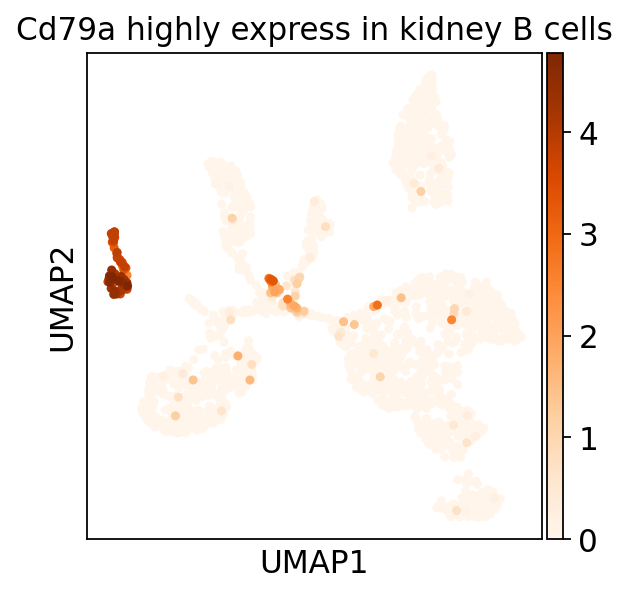

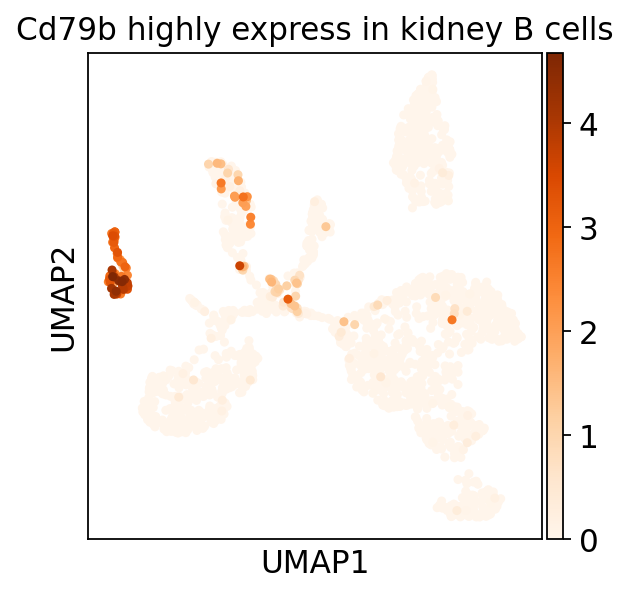

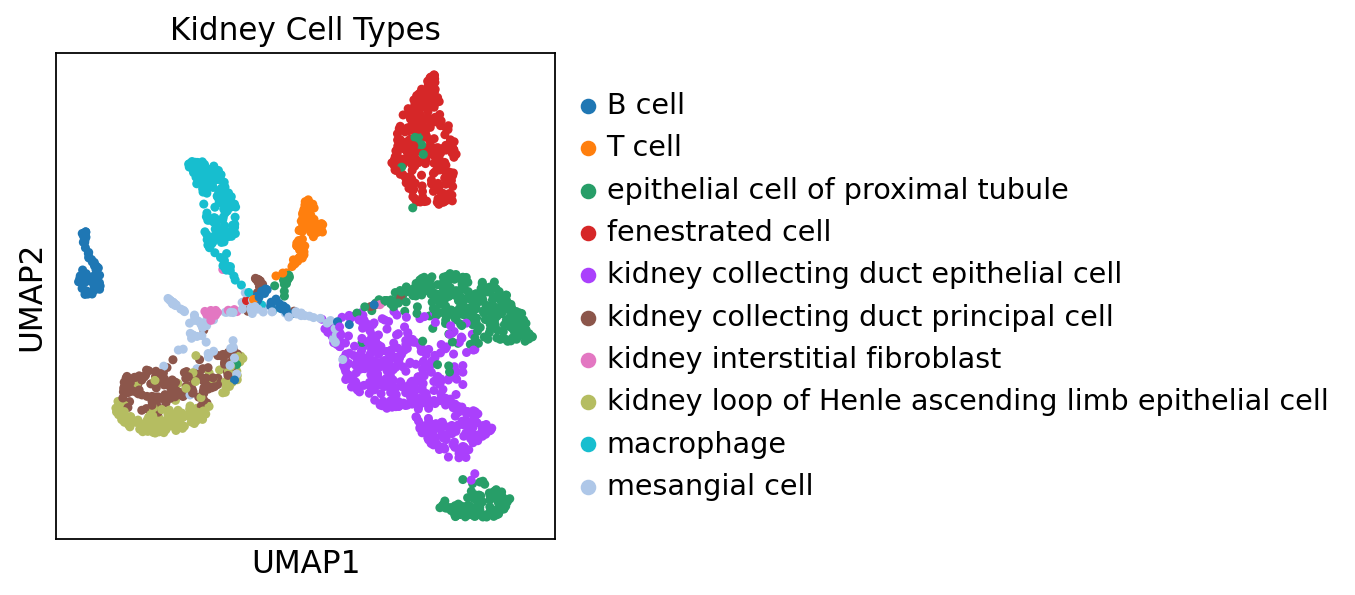

In [21]:
#sc.pl.umap(tissue, color = ['leiden'], wspace=1.0,color_map= 'Oranges', ncols=2, legend_loc='on data')
sc.pl.umap(tissue, color = ['Cd79a'], wspace=1.0,color_map= 'Oranges', ncols=2,
          title = 'Cd79a highly express in kidney B cells', save = '_kidney_cd79a_05302022.png')

sc.pl.umap(tissue, color = ['Cd79b'], wspace=1.0,color_map= 'Oranges', ncols=2,
          title = 'Cd79b highly express in kidney B cells', save = '_kidney_cd79b_05302022.png')

sc.pl.umap(tissue, color = ['cell_ontology_class'], wspace=1.0,color_map= 'Oranges', ncols=2,
          title = 'Kidney Cell Types', save = '_kidney_celltypes_05302022.png')

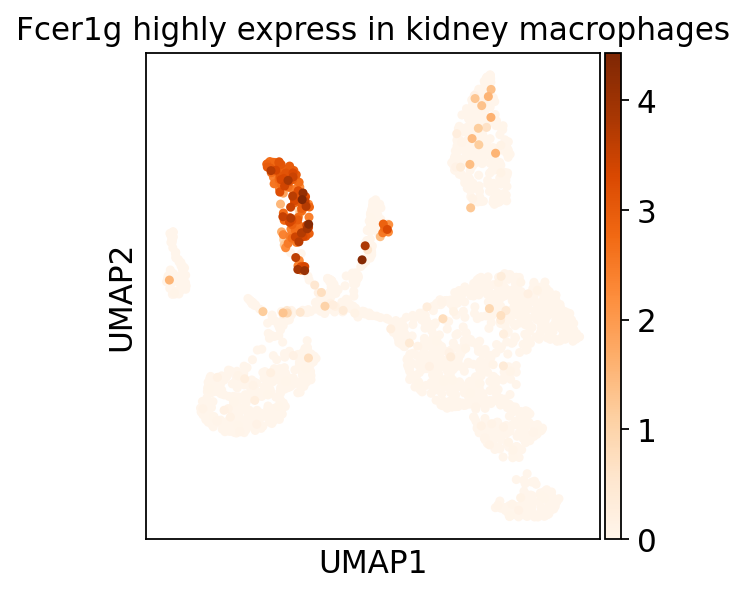

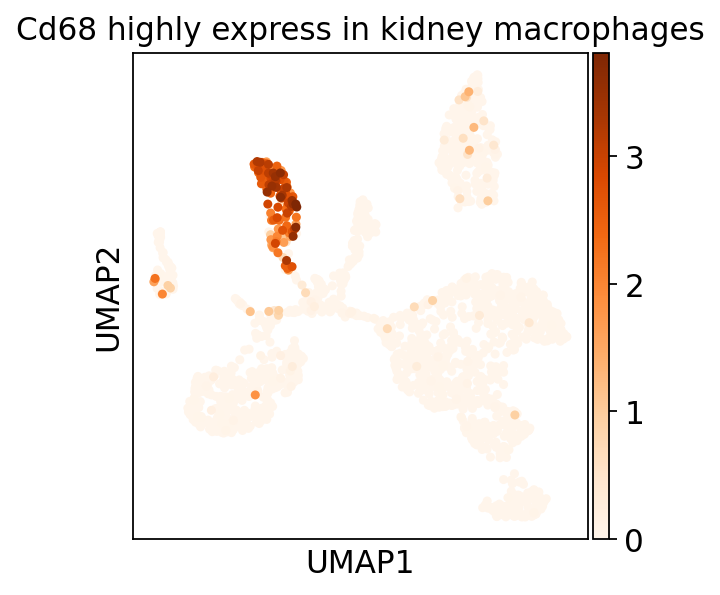

In [22]:
#sc.pl.umap(tissue, color = ['Fcer1g','Cd68','cell_ontology_class'], wspace=1.0,color_map= 'Oranges', ncols=2)
sc.pl.umap(tissue, color = ['Fcer1g'], wspace=1.0,color_map= 'Oranges', ncols=2,
          title = 'Fcer1g highly express in kidney macrophages', save = '_kidney_Fcer1g_05302022.png')

sc.pl.umap(tissue, color = ['Cd68'], wspace=1.0,color_map= 'Oranges', ncols=2,
          title = 'Cd68 highly express in kidney macrophages', save = '_kidney_Cd68_05302022.png')

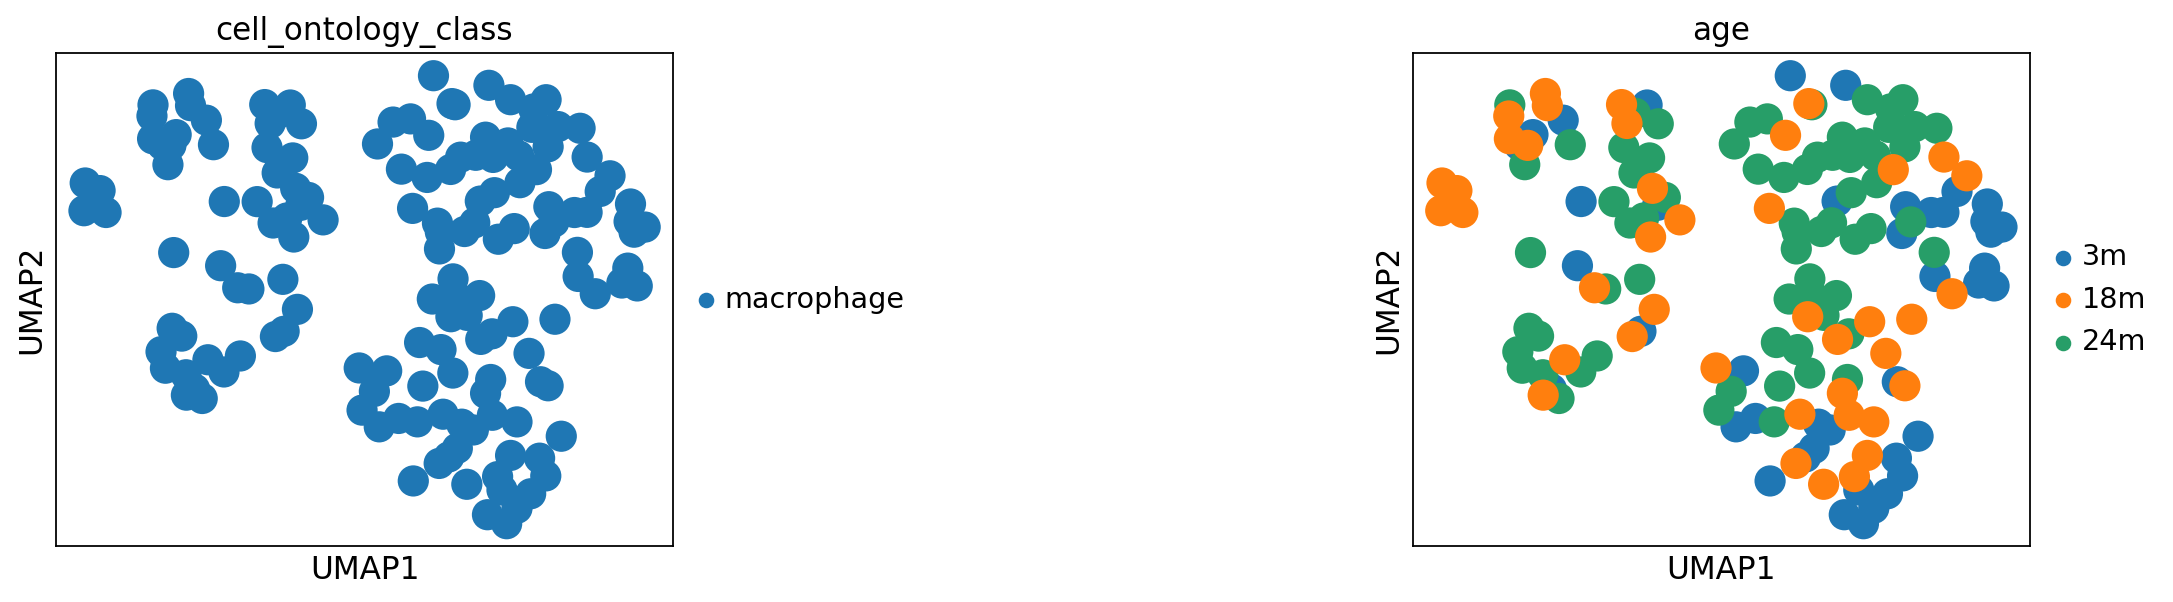

In [14]:
sc.pl.umap(kidney_macropahges, color = ['cell_ontology_class', 'age'], wspace=1.0,color_map= 'Oranges', ncols=2)


## rank_genes

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)
Filtering genes using: min_in_group_fraction: 0.25 min_fold_change: 0.7, max_out_group_fraction: 0.5


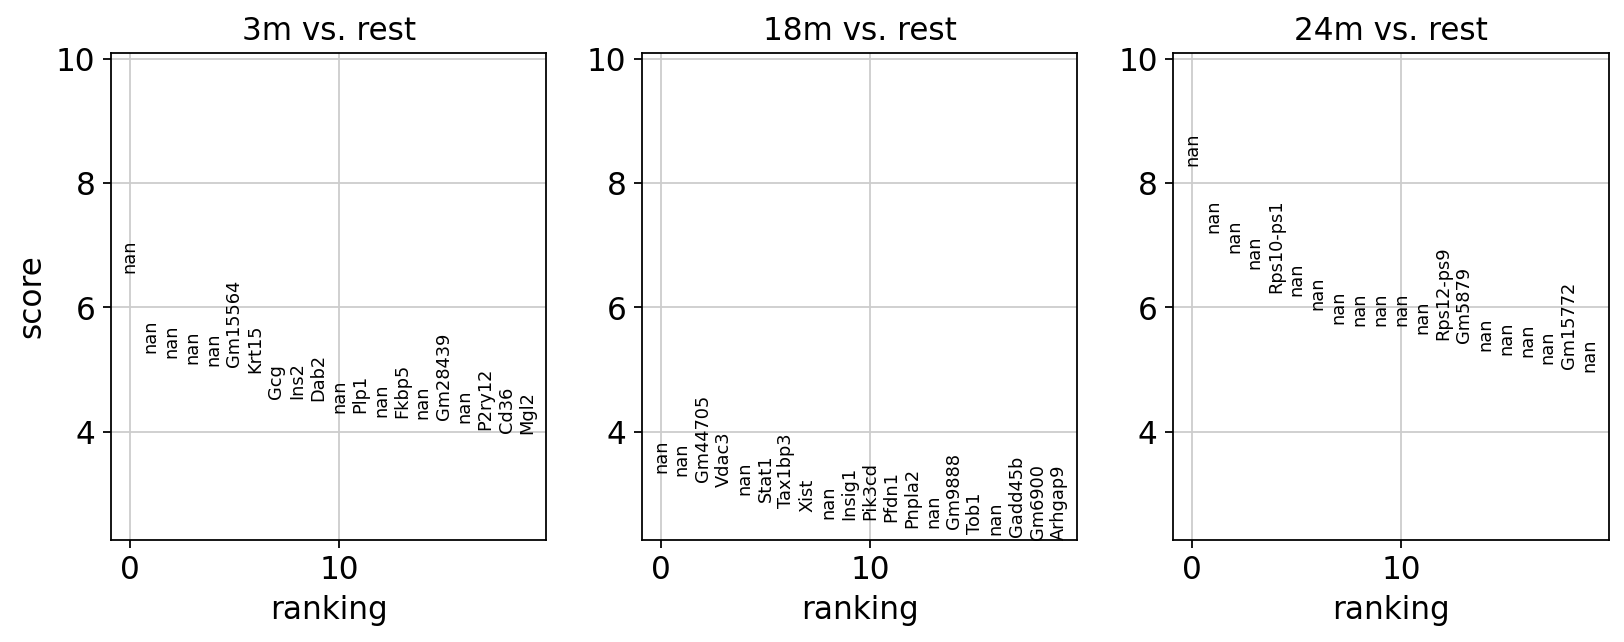

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_age']`


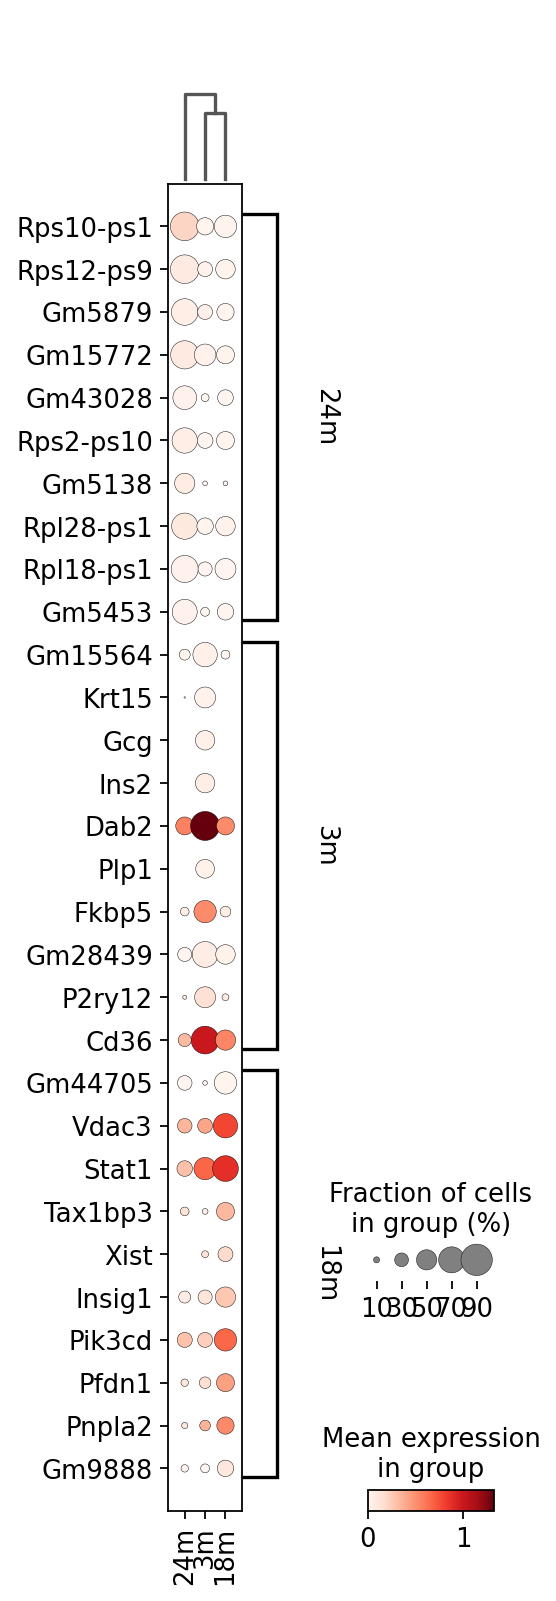

In [15]:
sc.tl.rank_genes_groups(kidney_macropahges, groupby = 'age', method = 'wilcoxon', pts = True)
sc.tl.filter_rank_genes_groups(kidney_macropahges, min_fold_change=0.7)
sc.pl.rank_genes_groups(kidney_macropahges, key='rank_genes_groups_filtered')
sc.pl.rank_genes_groups_dotplot(kidney_macropahges, key='rank_genes_groups_filtered', swap_axes=True)


Make a dictionary of adata and turn into a pd.DataFrame? 

In [16]:
pd.DataFrame(tissue.uns['rank_genes_groups']['names']).head(10)
#names
#scores
#pvals
#pvals_adj
#logfoldchanges
pd.DataFrame(tissue.uns['rank_genes_groups']['pvals_adj']).head(10)
tissue.uns['rank_genes_groups']['names'][0]

('Cd79a', 'P2ry12', 'C1qa', 'Serpinf1', 'Fabp4', 'Lsp1', 'Fbln1', 'Cmtm7', 'Lgals7', 'Trbc2', 'Krt15', 'Nkg7', 'Gpx3', 'Lyz2', 'Calcrl', 'Ngp', 'Anxa8', 'Acta2', 'Bsg', 'S100a9', 'Tm4sf20', 'Plp1', 'Cd79b', 'Agr2', 'Igfbp6', 'mt-Rnr2', 'mt-Rnr2', 'Lypd8', 'Gsta4', 'Ins1', 'Wfdc2', 'Cd8b1', 'C230004F18Rik', 'Cald1', 'Alb', 'Pcsk2', 'Aldob', 'Cavin2', 'Trbc2', 'Dnase1l3', 'Cela1', 'Col1a1', 'Plet1', 'Inmt', 'Aldoc', 'Muc2', 'Mug1', 'Bst2', 'Lars2', 'Mgp', 'Clu', 'Cox6a2', 'Gpr37l1', 'Cd79a', 'Sfn', 'Chga', 'Upk1a', 'Gcg', 'Tpsb2', 'Tnp1', 'Retnlg', 'Krt14', 'Mbp', 'Krt15', 'Mmp3', 'Gja4', 'Igkv4-72', 'Spock3', 'Aspn')

In [17]:
def GSEA_DataFrame(adata, age):
    ''' Input is adata object. Output is a pandas DataFrame 
    of names, scores, pvals, pvals_adj, logfoldchanges. 
    For inputting the age: 3m = 0, 18m = 1 or 24m = 2'''
    
    names = [] 
    scores = [] 
    pvals = []
    pvals_adj = []
    logfoldchanges = []
      
    for i,l in enumerate(list(adata.obs.index)):
        n = adata.uns['rank_genes_groups']['names'][i][age]
        s = adata.uns['rank_genes_groups']['scores'][i][age]
        p = adata.uns['rank_genes_groups']['pvals'][i][age]
        pa = adata.uns['rank_genes_groups']['pvals_adj'][i][age]
        l = adata.uns['rank_genes_groups']['logfoldchanges'][i][age]

        names.append(n)
        scores.append(s)
        pvals.append(p)
        pvals_adj.append(pa)
        logfoldchanges.append(l)
        
    dictionary = {'names':names,
                    'scores':scores,
                    'pvals': pvals,
                    'pvals_adj': pvals_adj,
                    'logfoldchanges': logfoldchanges
                 }
    df = pd.DataFrame(dictionary)
    return df

### 3m

In [107]:
df = GSEA_DataFrame(kidney_macropahges, '3m')
#df_adj = df[df['pvals_adj']<=0.05]
df_adj = df[df['logfoldchanges']>=0.7]
kidney_3m_sig = list(df_adj['names'])
df_adj


names    scores         pvals  pvals_adj  logfoldchanges
0    Serinc3  6.551203  5.707548e-11   0.000002        2.817528
1      Rps29  5.275984  1.320453e-07   0.001790        1.205923
2       Lcp1  5.189459  2.109058e-07   0.002249        1.331998
3    Gm28437  5.100873  3.380892e-07   0.002618        1.057673
4      Csf1r  5.059671  4.199803e-07   0.002758        2.142492
..       ...       ...           ...        ...             ...
147     Apoe  2.426829  1.523142e-02   1.000000        1.397645
148    Eps15  2.422709  1.540526e-02   1.000000        1.998339
149  Pla2g4a  2.408288  1.602753e-02   1.000000        1.923537
150     Wnk1  2.404168  1.620933e-02   1.000000        0.970059
151     Ugcg  2.402108  1.630091e-02   1.000000        0.857929

[145 rows x 5 columns]

In [108]:
enr_KID_mac_3m = gp.enrichr(gene_list= kidney_3m_sig,
                 gene_sets=['WikiPathways_2019_Mouse',
                            'KEGG_2019_Mouse',
                            'GO_Cellular_Component_2021',
                            'GO_Biological_Process_2021',
                            'GO_Molecular_Function_2021',
                            'GTEx_Aging_Signatures_2021',
                            'Mouse_Gene_Atlas'],
                 organism='Mouse', # don't forget to set organism to the one you desired! e.g. Yeast
                 description='test_name',
                 outdir='test/enrichr_kegg',
                 no_plot=False,
                 cutoff=1.0 # test dataset, use lower value from range(0,1)
                )

df = enr_KID_mac_3m.results
df = df[df['Adjusted P-value'] <= 0.05].copy() 
df

Gene_set  \
0        WikiPathways_2019_Mouse   
1        WikiPathways_2019_Mouse   
2        WikiPathways_2019_Mouse   
3        WikiPathways_2019_Mouse   
4        WikiPathways_2019_Mouse   
...                          ...   
441   GO_Biological_Process_2021   
1920  GO_Molecular_Function_2021   
1921  GO_Molecular_Function_2021   
1922  GO_Molecular_Function_2021   
1923  GO_Molecular_Function_2021   

                                                   Term Overlap   P-value  \
0                                 mRNA processing WP310  11/457  0.000511   
1                  Cytoplasmic Ribosomal Proteins WP163    5/92  0.000554   
2     ApoE and miR-146 in inflammation and atheroscl...     2/8  0.001420   
3                             Macrophage markers WP2271    2/10  0.002261   
4                              Adipogenesis genes WP447   5/134  0.002953   
...                                                 ...     ...       ...   
441   hematopoietic progenitor cell differentiation ...    3/32  0.001587   
1920                  amyloid-beta binding (GO:0001540)    5/80  0.000290   
1921       C-C chemokine receptor activity (GO:0016493)    3/23  0.000594   
1922                 C-C chemokine binding (GO:0019957)    3/24  0.000676   
1923           chemokine receptor activity (GO:0004950)    3/26  0.000859   

      Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0             0.018560            0                     0    3.572368   
1             0.018560            0                     0    8.114943   
2             0.031722            0                     0   46.268065   
3             0.037874            0                     0   34.697552   
4             0.039564            0                     0    5.461240   
...                ...          ...                   ...         ...   
441           0.049454            0                     0   14.443419   
1920          0.044224            0                     0    9.419048   
1921          0.044224            0                     0   20.952465   
1922          0.044224            0                     0   19.953722   
1923          0.044224            0                     0   18.216779   

      Combined Score                                              Genes  
0          27.075053  RPS28;MBNL1;HNRNPK;RPS27;RPS29;NCL;CSDE1;PRPF4...  
1          60.848068                      RPS28;RPS27;RPS29;RPL39;RPS21  
2         303.371631                                          APOE;TLR2  
3         211.373563                                          CD74;CD14  
4          31.812265                         INS1;MBNL1;NCOR1;INS2;LIFR  
...              ...                                                ...  
441        93.101463                                   CSF1R;PTPRC;PLEK  
1920       76.713690                           CD74;IAPP;CD36;APOE;TLR2  
1921      155.637509                                  CX3CR1;CXCR4;CCR5  
1922      145.660126                                  CX3CR1;CXCR4;CCR5  
1923      128.611662                                  CX3CR1;CXCR4;CCR5  

[104 rows x 10 columns]

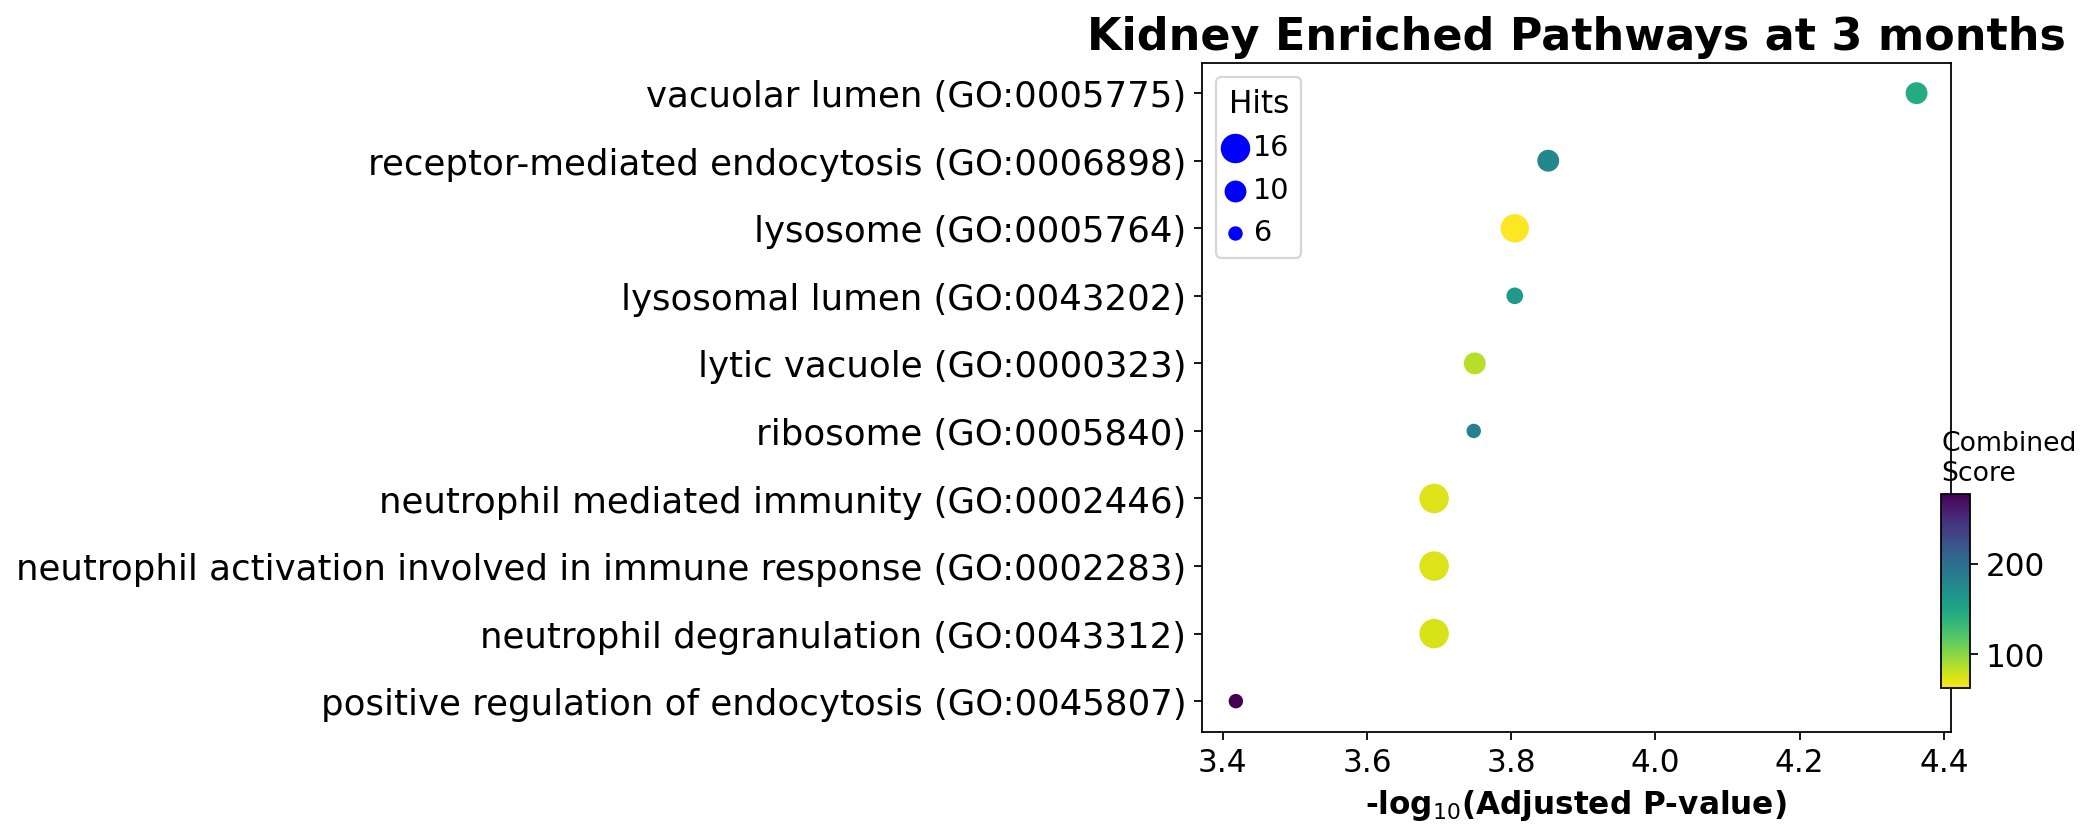

In [109]:
dotplot(df,column='Adjusted P-value', cutoff = 1.0, cmap='viridis_r',title = 'Kidney Enriched Pathways at 3 months')
plt.savefig('/mnt/ibm_sm/home/lea.mcgeever/ms/notebooks/figures/kidney_GSEA_dot_3m_05292022', dpi=150,bbox_inches='tight')


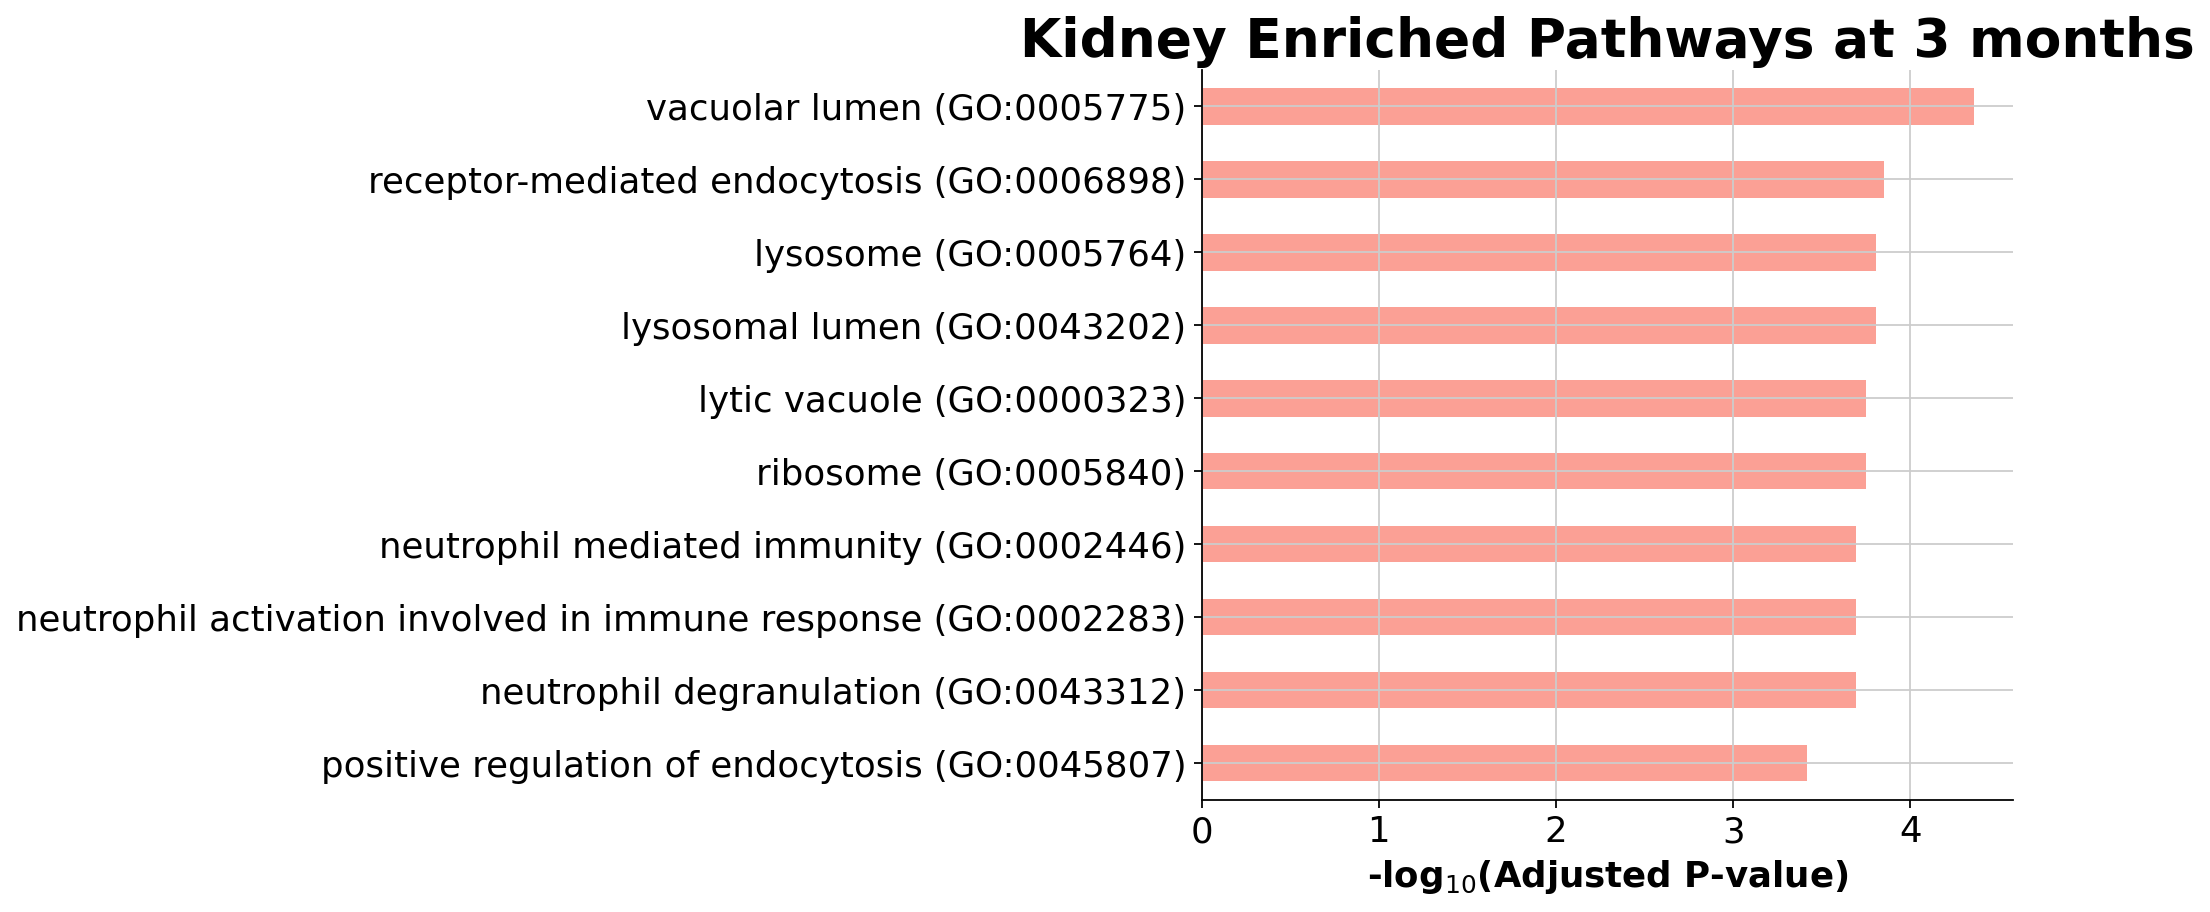

In [110]:
barplot(df,column='Adjusted P-value', cutoff = 1.0, title = 'Kidney Enriched Pathways at 3 months')
plt.savefig('/mnt/ibm_sm/home/lea.mcgeever/ms/notebooks/figures/kidney_GSEA_bar_3m_05292022', dpi=150,bbox_inches='tight')


### 18m

In [111]:
df = GSEA_DataFrame(kidney_macropahges, '18m')
#df_adj = df[df['pvals_adj']<=0.05]
df_adj = df[df['logfoldchanges']>=0.7]
kidney_18m_sig = list(df_adj['names'])


In [112]:
enr_KID_mac_18m = gp.enrichr(gene_list= kidney_18m_sig,
                 gene_sets=['WikiPathways_2019_Mouse',
                            'KEGG_2019_Mouse',
                            'GO_Cellular_Component_2021',
                            'GO_Biological_Process_2021',
                            'GO_Molecular_Function_2021',
                            'GTEx_Aging_Signatures_2021',
                            'Mouse_Gene_Atlas'
                           ],
                 organism='Mouse', # don't forget to set organism to the one you desired! e.g. Yeast
                 description='test_name',
                 outdir='test/enrichr_kegg',
                 no_plot=False,
                 cutoff=1.0 # test dataset, use lower value from range(0,1)
                )

df = enr_KID_mac_18m.results
df = df[df['Adjusted P-value'] <= 0.05].copy() 


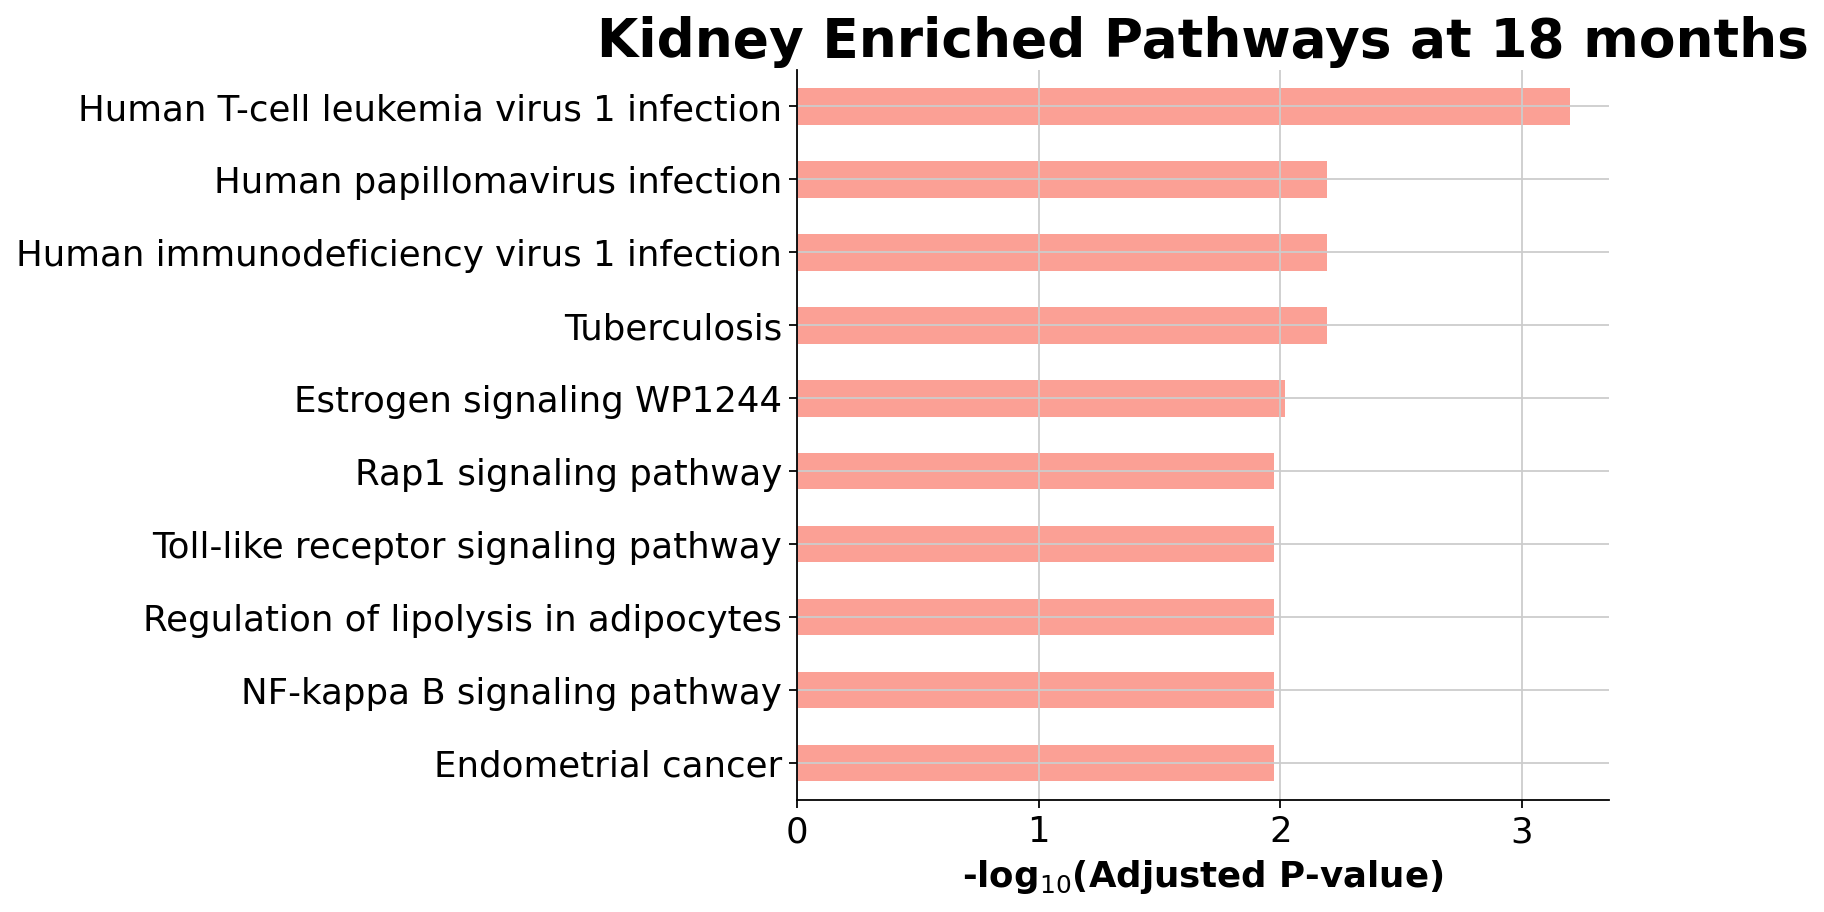

In [113]:
barplot(df,column='Adjusted P-value', cutoff = 0.7, title = 'Kidney Enriched Pathways at 18 months')
plt.savefig('/mnt/ibm_sm/home/lea.mcgeever/ms/notebooks/figures/kidney_GSEA_bar_18m_05292022', dpi=150,bbox_inches='tight')


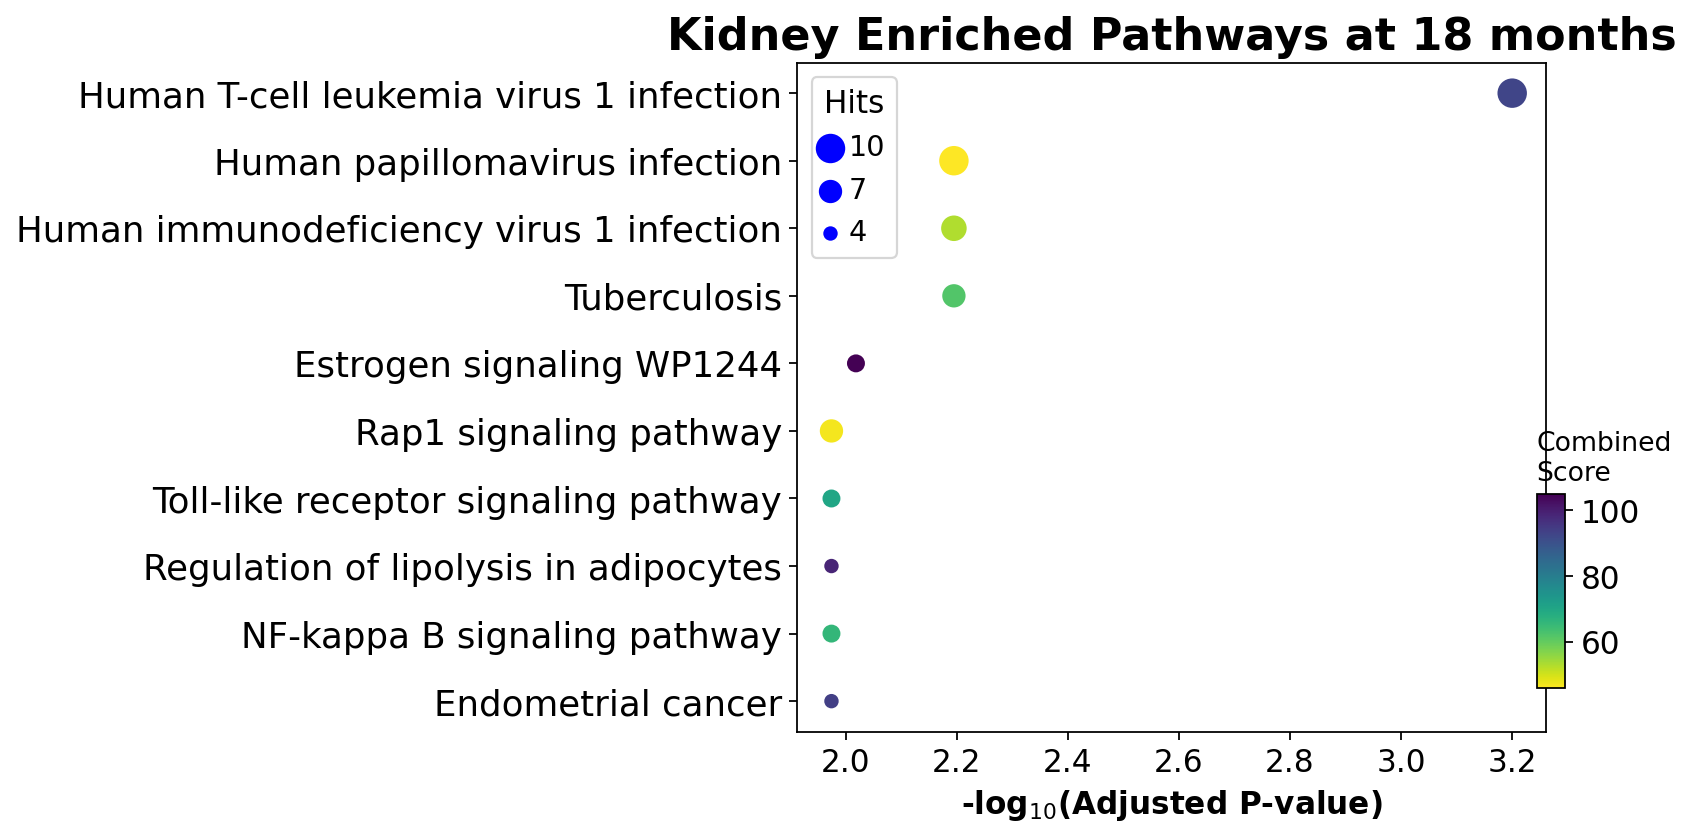

In [114]:
dotplot(df,column='Adjusted P-value', cutoff = 0.7, cmap='viridis_r', title = 'Kidney Enriched Pathways at 18 months')
plt.savefig('/mnt/ibm_sm/home/lea.mcgeever/ms/notebooks/figures/kidney_GSEA_dot_18m_05292022', dpi=150,bbox_inches='tight')


### 24m

In [115]:
df = GSEA_DataFrame(kidney_macropahges, '24m')
#df_adj = df[df['pvals_adj']<=0.05]
df_adj = df[df['logfoldchanges']>=0.7]
kidney_24m_sig = list(df_adj['names'])

In [116]:
enr_KID_mac_24m = gp.enrichr(gene_list= kidney_24m_sig,
                 gene_sets=['WikiPathways_2019_Mouse',
                            'KEGG_2019_Mouse',
                            'GO_Cellular_Component_2021',
                            'GO_Biological_Process_2021',
                            'GO_Molecular_Function_2021',
                            'GTEx_Aging_Signatures_2021',
                            'Mouse_Gene_Atlas'],
                 organism='Mouse', # don't forget to set organism to the one you desired! e.g. Yeast
                 description='test_name',
                 outdir='test/enrichr_kegg',
                 no_plot=False,
                 cutoff=1.0 # test dataset, use lower value from range(0,1)
                )

df = enr_KID_mac_24m.results
df = df[df['Adjusted P-value'] <= 0.05].copy() 
#df


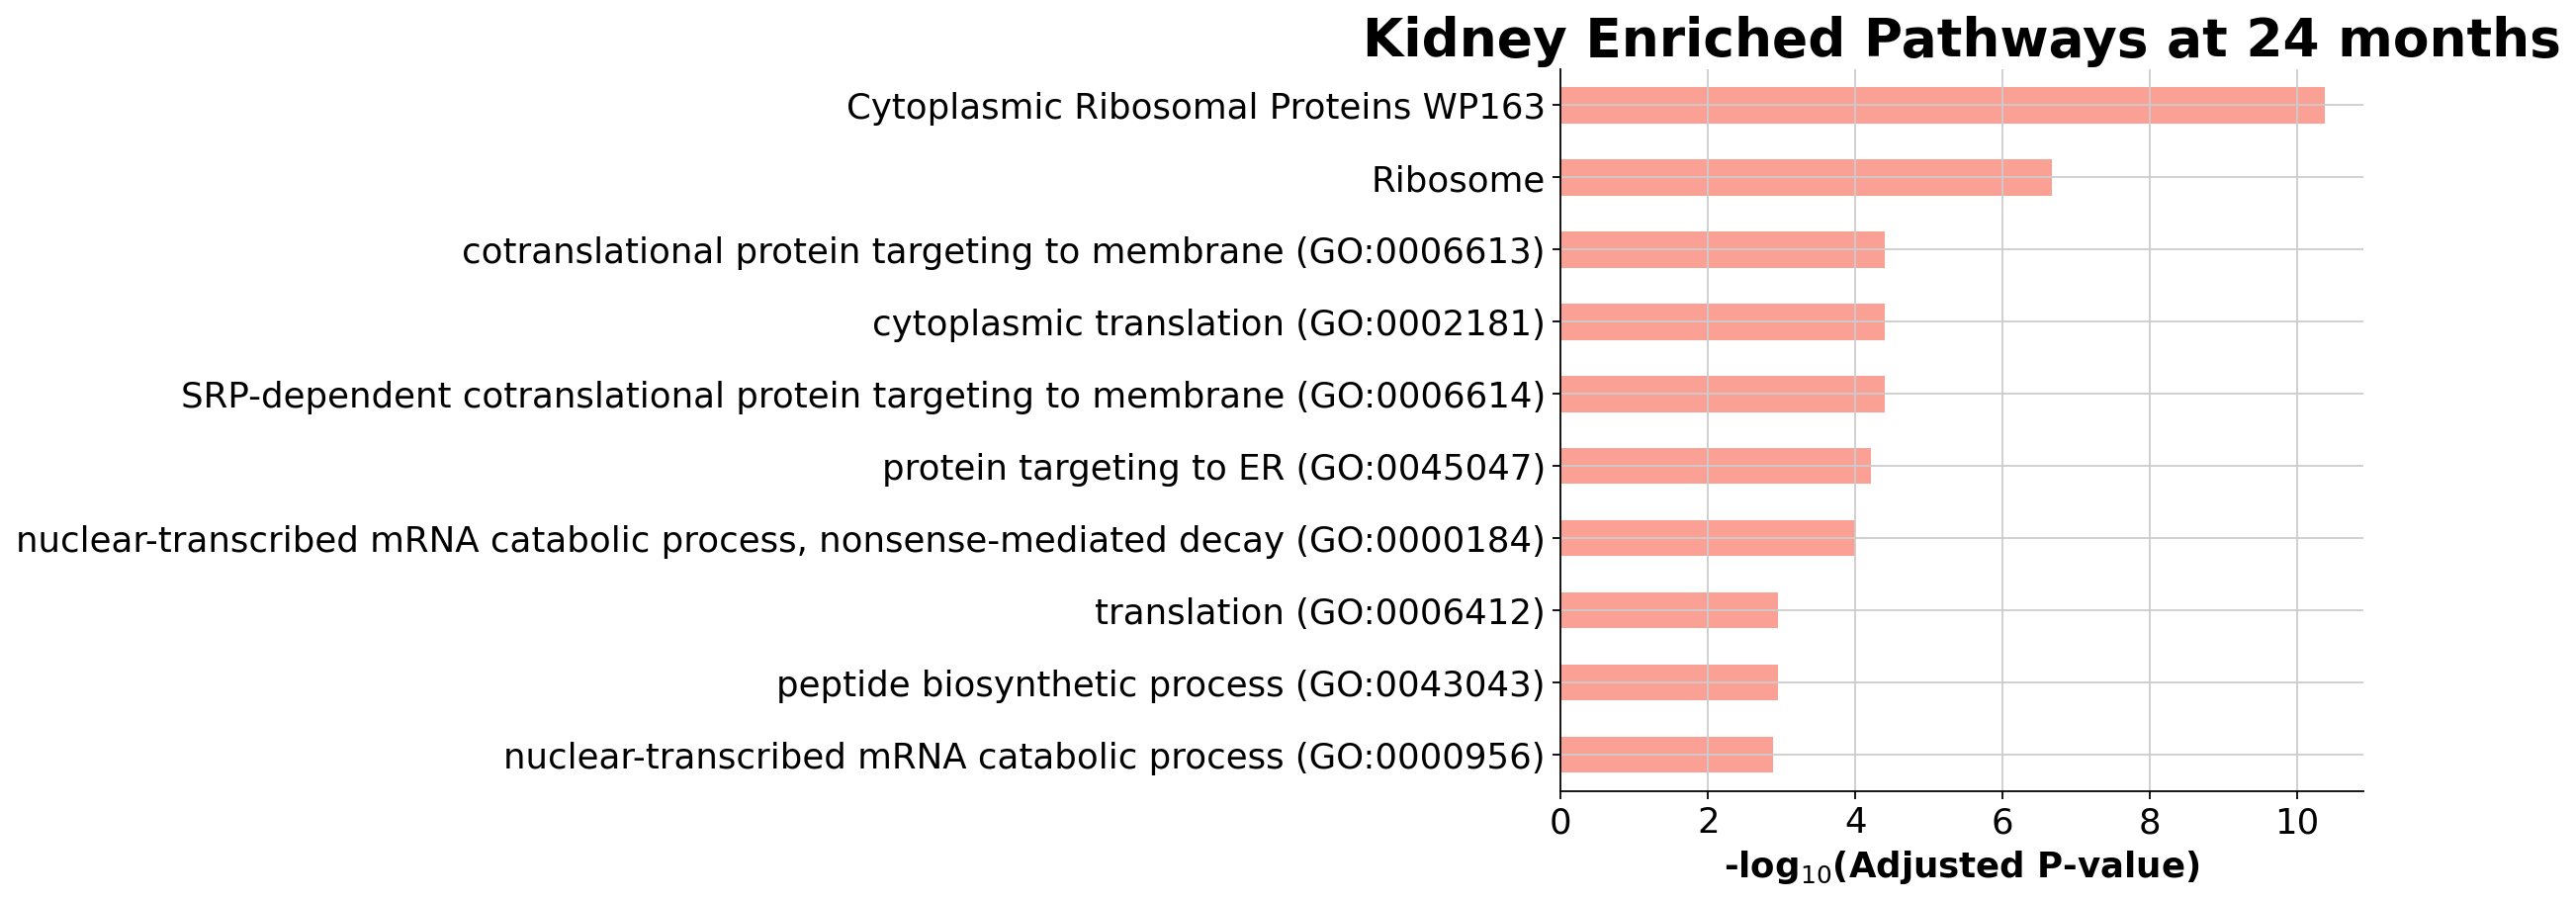

In [117]:
barplot(df,column='Adjusted P-value', cutoff = 0.7, title='Kidney Enriched Pathways at 24 months')
plt.savefig('/mnt/ibm_sm/home/lea.mcgeever/ms/notebooks/figures/kidney_GSEA_bar_24m_05292022', dpi=150,bbox_inches='tight')



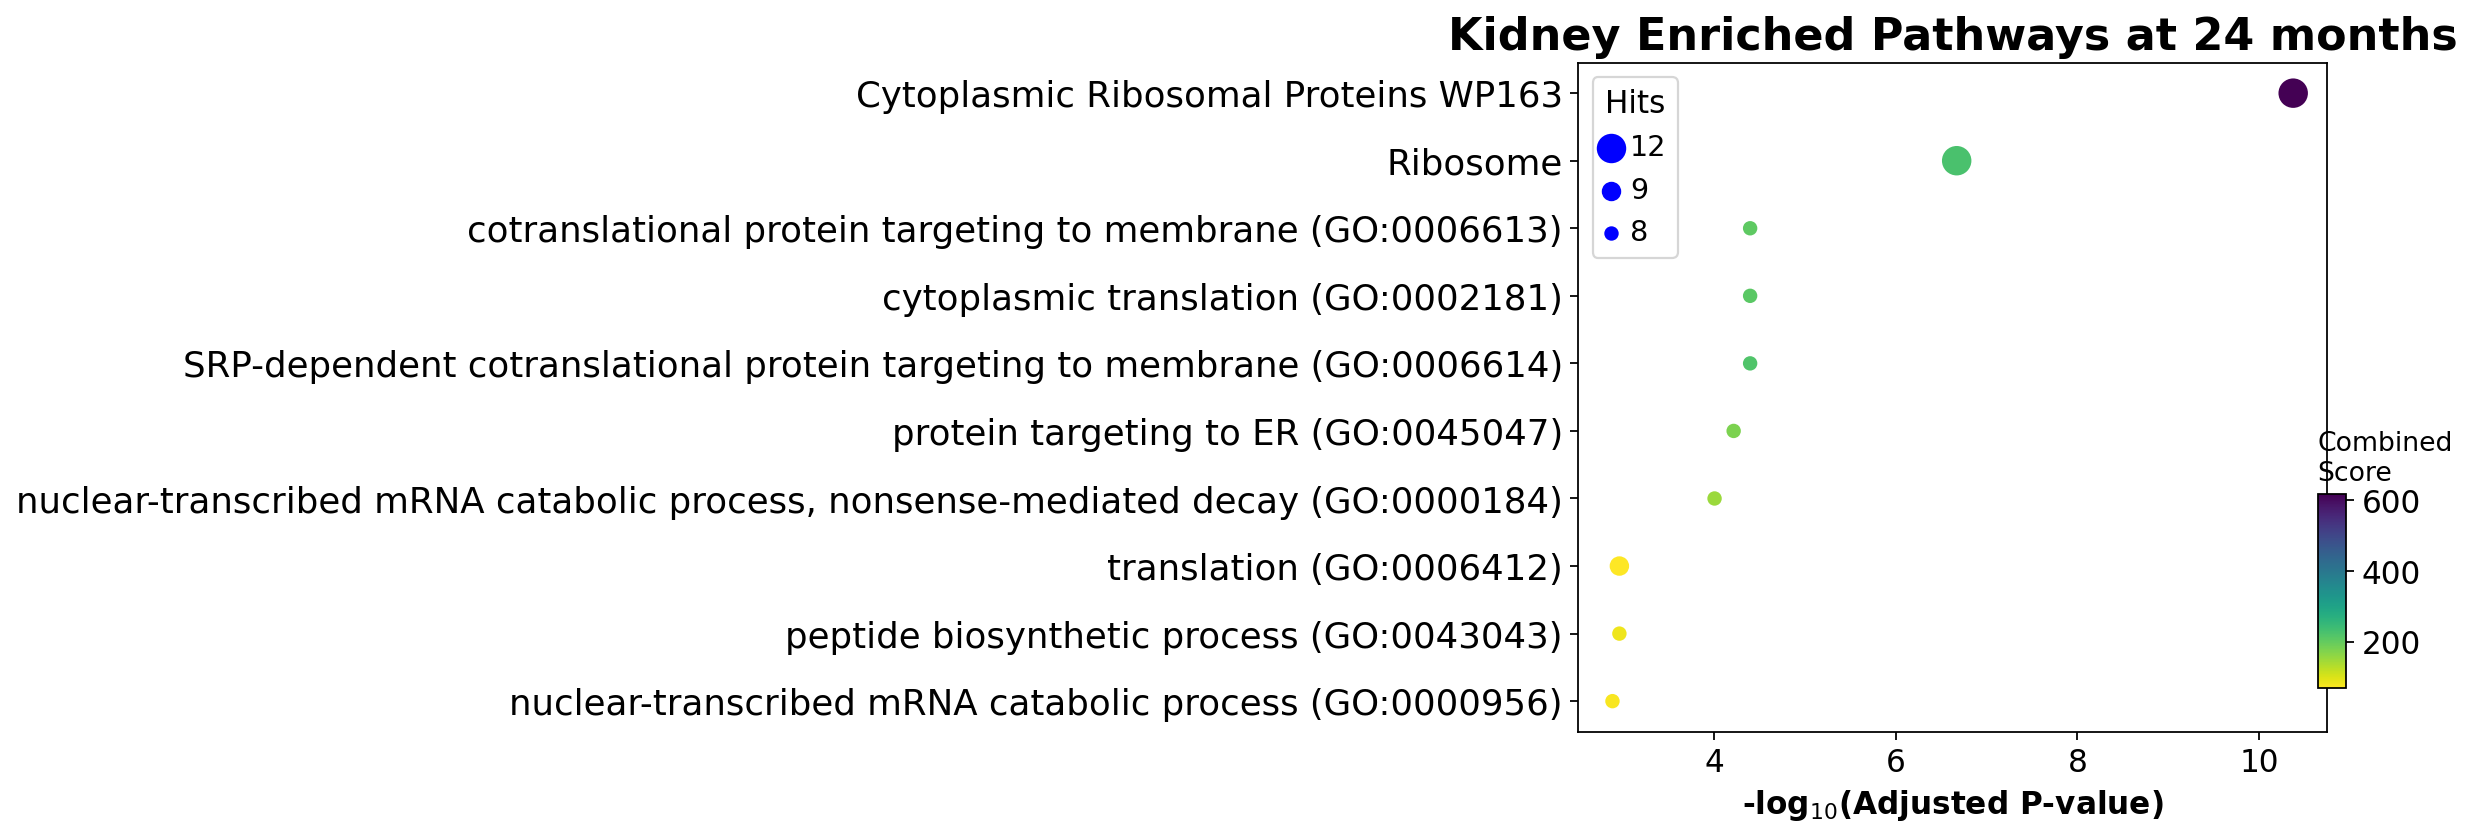

In [118]:
dotplot(df,column='Adjusted P-value', cutoff = 0.7, cmap='viridis_r',title='Kidney Enriched Pathways at 24 months')
plt.savefig('/mnt/ibm_sm/home/lea.mcgeever/ms/notebooks/figures/kidney_GSEA_dot_24m_05292022', dpi=150,bbox_inches='tight')



## stat_annot

In [34]:
def KIDNEY_gene_expression_df(adata, genelist):
    '''Takes adata object and a list of genes. 
    Returns a pandas dataframe where genes and their expression values are columns in dataframe of adata.'''
    df = adata.obs.copy()
    
    for g in genelist:
        df[g] = kidney_tissue[:,g].X.toarray().flatten()
    return df 

In [35]:
OXPHOS = ['CYC1','SDHB','SDHA','UQCRC1','COX5A','UQCRFS1',
          'ATP5F1A','UQCRC2','SDHD','UQCRQ','NDUFS1','ATP5F1E','ATP5F1B',
          'UQCR10','UQCRH','ATP5PO','COX6A1','NDUFS7','ATP5ME','NDUFV2',
          'ATP5PF','NDUFB8','NDUFS8','NDUFS2','NDUFV1','SDHC','NDUFB5',
          'COX6C','NDUFB9','NDUFA6','COX6B1','NDUFS4','NDUFA9','ATP5F1C',
          'COX4I1','NDUFS6','COX5B','NDUFA5','NDUFB6','NDUFB10','NDUFA2',
          'NDUFS5','CYCS','COX7A2','HCCS','NDUFA7','NDUFB2','ATP5IF1','ATP5PB',
          'COX7C','COX7A1','NDUFA12','NDUFA10','NDUFC2','NDUFA8','NDUFB11',
          'NDUFV3','UQCRB','ATP5PD','ATP5MG','ATP5MC3','COX6A2','NDUFAB1',
          'NDUFS3','NDUFB7','COX8A','NDUFC1','NDUFA3','NDUFB3','NDUFA4',
          'NDUFA13','COX7B','NDUFA11','ATP5MPL','COX6B2','COX4I2','ATP5MF',
          'COX8C','NDUFB4','UQCR11','NDUFA1','COX7A2L','ATP5MC1','ATP5MC2',
          'DMAC2L','ATP5MD','COX7B2','NDUFB1']
oxphos = []
for o in OXPHOS:
    p = o.lower()
    q = p.title()
    oxphos.append(q)
    
missed = ['Cox5A', 'Atp5F1A', 'Atp5F1E', 'Atp5F1B', 'Atp5Po', 'Cox6A1', 'Atp5Me', 
          'Atp5Pf', 'Cox6C', 'Cox6B1', 'Atp5F1C', 'Cox4I1', 'Cox5B', 'Cox7A2', 
          'Atp5If1', 'Atp5Pb', 'Cox7C', 'Cox7A1', 'Atp5Pd', 'Atp5Mg', 'Atp5Mc3', 
          'Cox6A2', 'Cox8A', 'Cox7B', 'Atp5Mpl', 'Cox6B2', 'Cox4I2', 'Atp5Mf', 'Cox8C', 
          'Cox7A2L', 'Atp5Mc1', 'Atp5Mc2', 'Dmac2L', 'Atp5Md', 'Cox7B2', 'Ndufb1']

for m in missed:
    oxphos.remove(m)

In [36]:
tissue_copy=kidney_tissue.copy()
sc.tl.score_genes(tissue_copy, oxphos, score_name = 'OXPHOS')
tissue_copy1 = remove_cats(tissue_copy)

computing score 'OXPHOS'
    finished: added
    'OXPHOS', score of gene set (adata.obs).
    99 total control genes are used. (0:00:00)


In [37]:
adata_kidney_obs = gene_expression_obs(tissue_copy1, oxphos)
adata_kidney_obs = remove_cats(adata_kidney_obs)
kidney_df = KIDNEY_gene_expression_df(adata_kidney_obs, oxphos)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

B cell_3m v.s. B cell_18m: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.290e-01 U_stat=5.400e+01
B cell_18m v.s. B cell_24m: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=4.940e+02
T cell_3m v.s. T cell_18m: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=8.800e+01
T cell_18m v.s. T cell_24m: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=4.400e+02
epithelial cell of proximal tubule_18m v.s. epithelial cell of proximal tubule_24m: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.127e-08 U_stat=1.937e+04
kidney collecting duct epithelial cell_3m v.s. kidney collecting duct epithelial cell_18m: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correcti

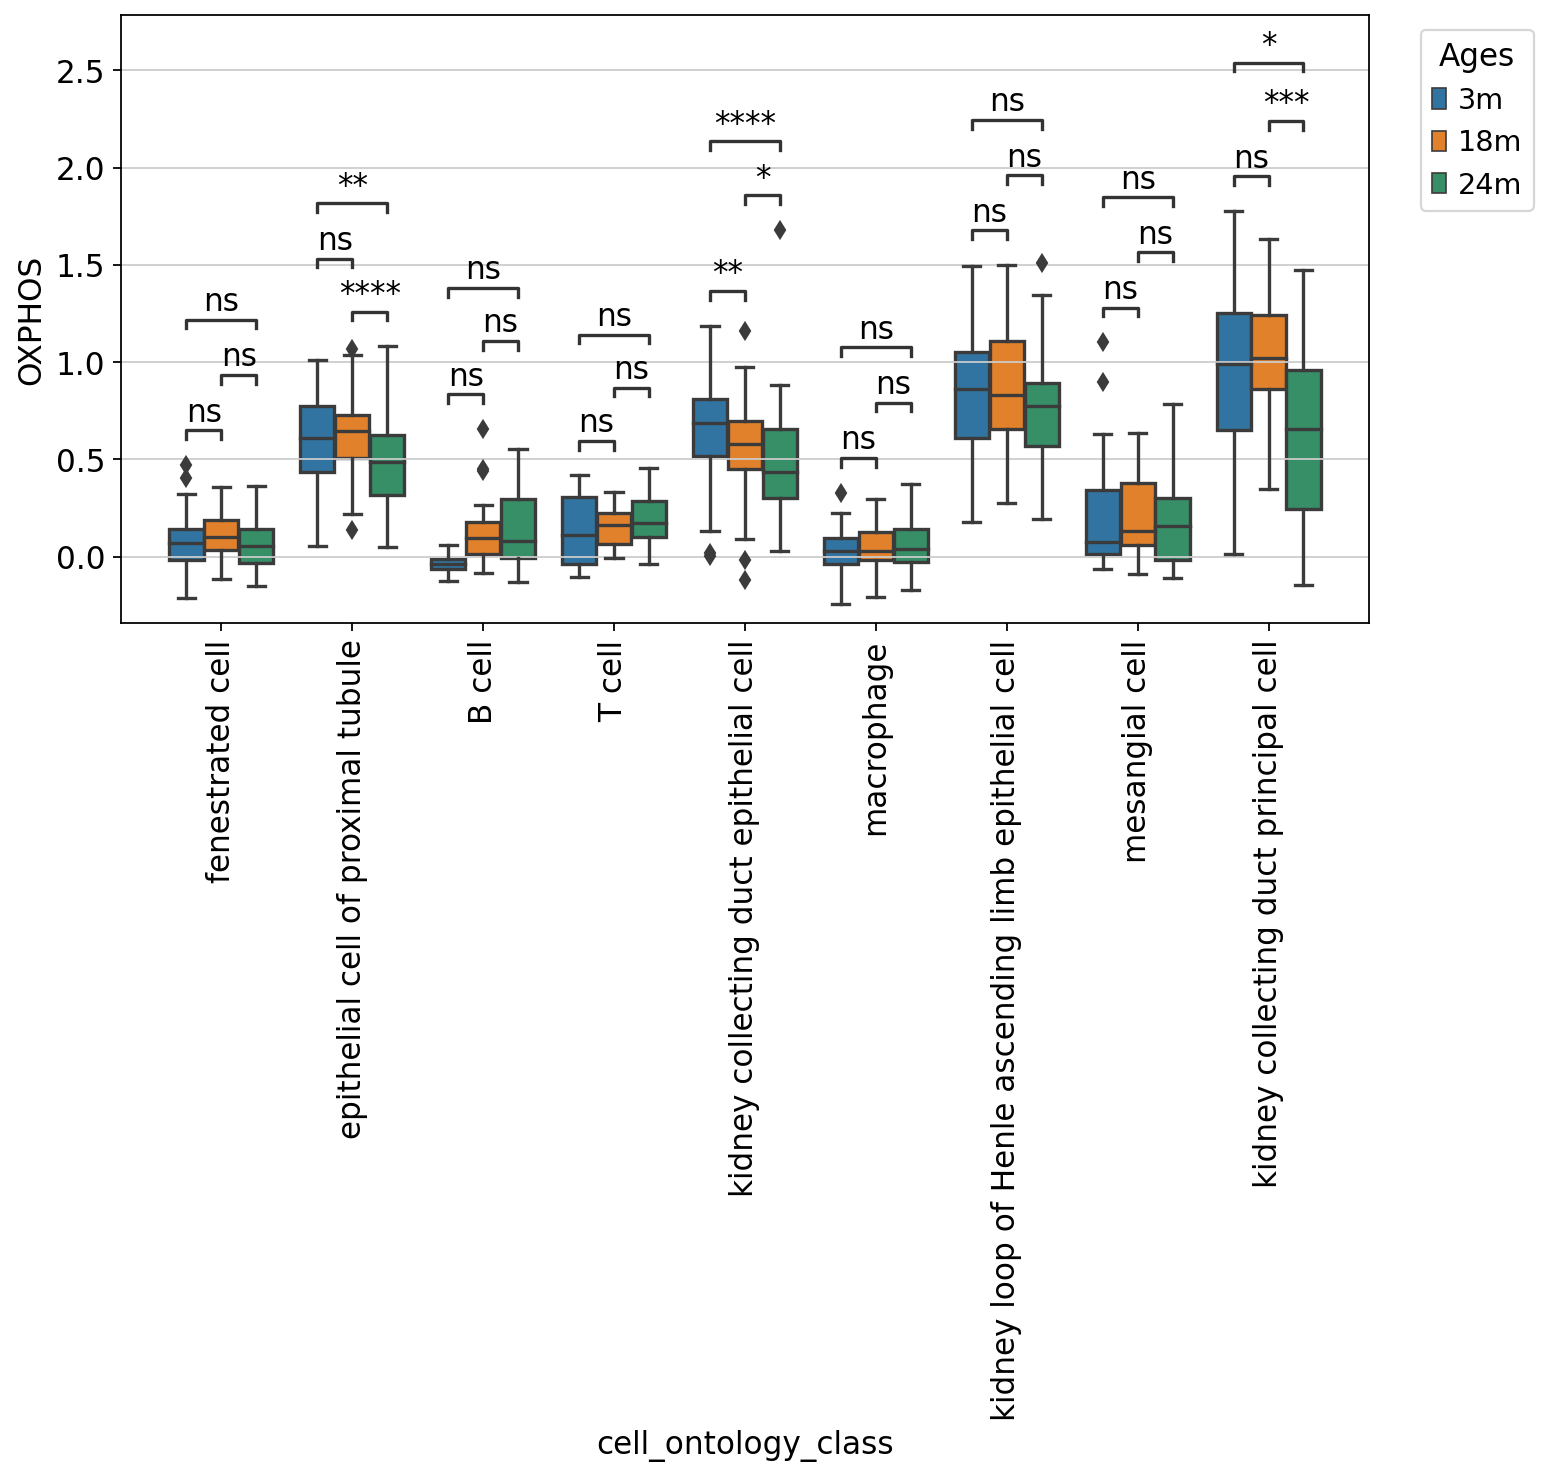

In [38]:
df = kidney_df
df[[ 'age','cell_ontology_class','OXPHOS']]
df["age_months"] = [int(e[:-1]) for e in df.age]
df = df.sort_values("age_months")
mask = df['cell_ontology_class'].isin(['B cell','T cell','epithelial cell of proximal tubule','fenestrated cell','kidney collecting duct epithelial cell','kidney collecting duct principal cell','kidney loop of Henle ascending limb epithelial cell','macrophage', 'mesangial cell'])
df = df[mask]

x = "cell_ontology_class" 
y = "OXPHOS" 
hue_order = ['3m', '18m', '24m']
hue = 'age'


box_pairs=[
    (("B cell", "3m"), ("B cell", "18m")),
    (("B cell", "3m"), ("B cell", "24m")),
    (("B cell", "18m"), ("B cell", "24m")),
    
    (("T cell", "3m"), ("T cell", "18m")),
    (("T cell", "3m"), ("T cell", "24m")),
    (("T cell", "18m"), ("T cell", "24m")),
    
    (("epithelial cell of proximal tubule", "3m"), ("epithelial cell of proximal tubule", "18m")),
    (("epithelial cell of proximal tubule", "3m"), ("epithelial cell of proximal tubule", "24m")),
    (("epithelial cell of proximal tubule", "18m"), ("epithelial cell of proximal tubule", "24m")),
    
    (("fenestrated cell", "3m"), ("fenestrated cell", "18m")),
    (("fenestrated cell", "3m"), ("fenestrated cell", "24m")),
    (("fenestrated cell", "18m"), ("fenestrated cell", "24m")),
    
    (("kidney collecting duct epithelial cell", "3m"), ("kidney collecting duct epithelial cell", "18m")),
    (("kidney collecting duct epithelial cell", "3m"), ("kidney collecting duct epithelial cell", "24m")),
    (("kidney collecting duct epithelial cell", "18m"), ("kidney collecting duct epithelial cell", "24m")),
    
    (("kidney collecting duct principal cell", "3m"), ("kidney collecting duct principal cell", "18m")),
    (("kidney collecting duct principal cell", "3m"), ("kidney collecting duct principal cell", "24m")),
    (("kidney collecting duct principal cell", "18m"), ("kidney collecting duct principal cell", "24m")),
    
    (("kidney loop of Henle ascending limb epithelial cell", "3m"), ("kidney loop of Henle ascending limb epithelial cell", "18m")),
    (("kidney loop of Henle ascending limb epithelial cell", "3m"), ("kidney loop of Henle ascending limb epithelial cell", "24m")),
    (("kidney loop of Henle ascending limb epithelial cell", "18m"), ("kidney loop of Henle ascending limb epithelial cell", "24m")),
    
    (("macrophage", "3m"), ("macrophage", "18m")),
    (("macrophage", "3m"), ("macrophage", "24m")),
    (("macrophage", "18m"), ("macrophage", "24m")),
       
    (("mesangial cell", "3m"), ("mesangial cell", "18m")),
    (("mesangial cell", "3m"), ("mesangial cell", "24m")),
    (("mesangial cell", "18m"), ("mesangial cell", "24m"))
    ]
fig = plt.figure(figsize=(10, 5))
plt.xticks(rotation=90)

ax = sns.boxplot(data=df, x=x, y=y, hue=hue)
add_stat_annotation(ax, data=df, x=x, y=y,hue=hue,box_pairs=box_pairs,
                    test='Mann-Whitney',loc='inside',verbose=2)
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1), title = "Ages")


# curious about Trachea (kidney 24m mac genes)

In [ ]:
df = trachea_df[['age','cell_ontology_class','Rpl28-ps1']]
df["age_months"] = [int(e[:-1]) for e in df.age]
df = df.sort_values("age_months")
#mask = df['cell_ontology_class'].isin(['B cell','T cell','epithelial cell of proximal tubule','fenestrated cell','kidney collecting duct epithelial cell','kidney collecting duct principal cell','kidney loop of Henle ascending limb epithelial cell','macrophage', 'mesangial cell'])
#df = df[mask]

x = "cell_ontology_class" 
y = "Rp128-ps1" 
hue = 'age'
hue_order = ['3m', '18m', '24m']

box_pairs=[
    (("keratinocyte", "3m"), ("keratinocyte", "18m")),
    (("keratinocyte", "3m"), ("keratinocyte", "24m")),
    (("keratinocyte", "18m"), ("keratinocyte", "24m")),
    
    (("mucus secreting cell", "3m"), ("mucus secreting cell", "18m")),
    (("mucus secreting cell", "3m"), ("mucus secreting cell", "24m")),
    (("mucus secreting cell", "18m"), ("mucus secreting cell", "24m")),
    
    (("smooth muscle cell of trachea", "3m"), ("smooth muscle cell of trachea", "18m")),
    (("smooth muscle cell of trachea", "3m"), ("smooth muscle cell of trachea", "24m")),
    (("smooth muscle cell of trachea", "18m"), ("smooth muscle cell of trachea", "24m")),
    
    (("T cell", "3m"), ("T cell", "18m")),
    (("T cell", "3m"), ("T cell", "24m")),
    (("T cell", "18m"), ("T cell", "24m")),
    
    (("basal epithelial cell of tracheobronchial tree", "3m"), ("basal epithelial cell of tracheobronchial tree", "18m")),
    (("basal epithelial cell of tracheobronchial tree", "3m"), ("basal epithelial cell of tracheobronchial tree", "24m")),
    (("basal epithelial cell of tracheobronchial tree", "18m"), ("basal epithelial cell of tracheobronchial tree", "24m")),
    
    (("chondrocyte", "3m"), ("chondrocyte", "18m")),
    (("chondrocyte", "3m"), ("chondrocyte", "24m")),
    (("chondrocyte", "18m"), ("chondrocyte", "24m")),
    
    (("ciliated columnar cell of tracheobronchial tree", "3m"), ("ciliated columnar cell of tracheobronchial tree", "18m")),
    (("ciliated columnar cell of tracheobronchial tree", "3m"), ("ciliated columnar cell of tracheobronchial tree", "24m")),
    (("ciliated columnar cell of tracheobronchial tree", "18m"), ("ciliated columnar cell of tracheobronchial tree", "24m")),
    
    (("fibroblast", "3m"), ("fibroblast", "18m")),
    (("fibroblast", "3m"), ("fibroblast", "24m")),
    (("fibroblast", "18m"), ("fibroblast", "24m")),
    
    (("granulocyte", "3m"), ("granulocyte", "18m")),
    (("granulocyte", "3m"), ("granulocyte", "24m")),
    (("granulocyte", "18m"), ("granulocyte", "24m")),
    
    (("macrophage", "3m"), ("macrophage", "18m")),
    (("macrophage", "3m"), ("macrophage", "24m")),
    (("macrophage", "18m"), ("macrophage", "24m")),
       
    (("endothelial cell", "3m"), ("endothelial cell", "18m")),
    (("endothelial cell", "3m"), ("endothelial cell", "24m")),
    (("endothelial cell", "18m"), ("endothelial cell", "24m")),  
    ]
fig = plt.figure(figsize=(10, 5))
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
plt.xticks(rotation=90)
ax = sns.boxplot(data=df, x=x, y=y, hue=hue)
add_stat_annotation(ax, data=df, x=x, y=y,hue=hue,box_pairs=box_pairs,
                    test='Mann-Whitney',loc='inside',verbose=2)

In [ ]:
df = trachea_df[['age','cell_ontology_class','Gm12537']]
df["age_months"] = [int(e[:-1]) for e in df.age]
df = df.sort_values("age_months")
#mask = df['cell_ontology_class'].isin(['B cell','T cell','epithelial cell of proximal tubule','fenestrated cell','kidney collecting duct epithelial cell','kidney collecting duct principal cell','kidney loop of Henle ascending limb epithelial cell','macrophage', 'mesangial cell'])
#df = df[mask]

x = "cell_ontology_class" 
y = "Gm12537" 
hue = 'age'
hue_order = ['3m', '18m', '24m']

box_pairs=[
    (("keratinocyte", "3m"), ("keratinocyte", "18m")),
    (("keratinocyte", "3m"), ("keratinocyte", "24m")),
    (("keratinocyte", "18m"), ("keratinocyte", "24m")),
    
    (("mucus secreting cell", "3m"), ("mucus secreting cell", "18m")),
    (("mucus secreting cell", "3m"), ("mucus secreting cell", "24m")),
    (("mucus secreting cell", "18m"), ("mucus secreting cell", "24m")),
    
    (("smooth muscle cell of trachea", "3m"), ("smooth muscle cell of trachea", "18m")),
    (("smooth muscle cell of trachea", "3m"), ("smooth muscle cell of trachea", "24m")),
    (("smooth muscle cell of trachea", "18m"), ("smooth muscle cell of trachea", "24m")),
    
    (("T cell", "3m"), ("T cell", "18m")),
    (("T cell", "3m"), ("T cell", "24m")),
    (("T cell", "18m"), ("T cell", "24m")),
    
    (("basal epithelial cell of tracheobronchial tree", "3m"), ("basal epithelial cell of tracheobronchial tree", "18m")),
    (("basal epithelial cell of tracheobronchial tree", "3m"), ("basal epithelial cell of tracheobronchial tree", "24m")),
    (("basal epithelial cell of tracheobronchial tree", "18m"), ("basal epithelial cell of tracheobronchial tree", "24m")),
    
    (("chondrocyte", "3m"), ("chondrocyte", "18m")),
    (("chondrocyte", "3m"), ("chondrocyte", "24m")),
    (("chondrocyte", "18m"), ("chondrocyte", "24m")),
    
    (("ciliated columnar cell of tracheobronchial tree", "3m"), ("ciliated columnar cell of tracheobronchial tree", "18m")),
    (("ciliated columnar cell of tracheobronchial tree", "3m"), ("ciliated columnar cell of tracheobronchial tree", "24m")),
    (("ciliated columnar cell of tracheobronchial tree", "18m"), ("ciliated columnar cell of tracheobronchial tree", "24m")),
    
    (("fibroblast", "3m"), ("fibroblast", "18m")),
    (("fibroblast", "3m"), ("fibroblast", "24m")),
    (("fibroblast", "18m"), ("fibroblast", "24m")),
    
    (("granulocyte", "3m"), ("granulocyte", "18m")),
    (("granulocyte", "3m"), ("granulocyte", "24m")),
    (("granulocyte", "18m"), ("granulocyte", "24m")),
    
    (("macrophage", "3m"), ("macrophage", "18m")),
    (("macrophage", "3m"), ("macrophage", "24m")),
    (("macrophage", "18m"), ("macrophage", "24m")),
       
    (("endothelial cell", "3m"), ("endothelial cell", "18m")),
    (("endothelial cell", "3m"), ("endothelial cell", "24m")),
    (("endothelial cell", "18m"), ("endothelial cell", "24m")),  
    ]
fig = plt.figure(figsize=(10, 5))
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
plt.xticks(rotation=90)
ax = sns.boxplot(data=df, x=x, y=y, hue=hue)
add_stat_annotation(ax, data=df, x=x, y=y,hue=hue,box_pairs=box_pairs,
                    test='Mann-Whitney',loc='inside',verbose=2)

In [ ]:
df = trachea_df[['age','cell_ontology_class','Gm10045']]
df["age_months"] = [int(e[:-1]) for e in df.age]
df = df.sort_values("age_months")
#mask = df['cell_ontology_class'].isin(['B cell','T cell','epithelial cell of proximal tubule','fenestrated cell','kidney collecting duct epithelial cell','kidney collecting duct principal cell','kidney loop of Henle ascending limb epithelial cell','macrophage', 'mesangial cell'])
#df = df[mask]

x = "cell_ontology_class" 
y = "Gm10045" 
hue = 'age'
hue_order = ['3m', '18m', '24m']

box_pairs=[
    (("keratinocyte", "3m"), ("keratinocyte", "18m")),
    (("keratinocyte", "3m"), ("keratinocyte", "24m")),
    (("keratinocyte", "18m"), ("keratinocyte", "24m")),
    
    (("mucus secreting cell", "3m"), ("mucus secreting cell", "18m")),
    (("mucus secreting cell", "3m"), ("mucus secreting cell", "24m")),
    (("mucus secreting cell", "18m"), ("mucus secreting cell", "24m")),
    
    (("smooth muscle cell of trachea", "3m"), ("smooth muscle cell of trachea", "18m")),
    (("smooth muscle cell of trachea", "3m"), ("smooth muscle cell of trachea", "24m")),
    (("smooth muscle cell of trachea", "18m"), ("smooth muscle cell of trachea", "24m")),
    
    (("T cell", "3m"), ("T cell", "18m")),
    (("T cell", "3m"), ("T cell", "24m")),
    (("T cell", "18m"), ("T cell", "24m")),
    
    (("basal epithelial cell of tracheobronchial tree", "3m"), ("basal epithelial cell of tracheobronchial tree", "18m")),
    (("basal epithelial cell of tracheobronchial tree", "3m"), ("basal epithelial cell of tracheobronchial tree", "24m")),
    (("basal epithelial cell of tracheobronchial tree", "18m"), ("basal epithelial cell of tracheobronchial tree", "24m")),
    
    (("chondrocyte", "3m"), ("chondrocyte", "18m")),
    (("chondrocyte", "3m"), ("chondrocyte", "24m")),
    (("chondrocyte", "18m"), ("chondrocyte", "24m")),
    
    (("ciliated columnar cell of tracheobronchial tree", "3m"), ("ciliated columnar cell of tracheobronchial tree", "18m")),
    (("ciliated columnar cell of tracheobronchial tree", "3m"), ("ciliated columnar cell of tracheobronchial tree", "24m")),
    (("ciliated columnar cell of tracheobronchial tree", "18m"), ("ciliated columnar cell of tracheobronchial tree", "24m")),
    
    (("fibroblast", "3m"), ("fibroblast", "18m")),
    (("fibroblast", "3m"), ("fibroblast", "24m")),
    (("fibroblast", "18m"), ("fibroblast", "24m")),
    
    (("granulocyte", "3m"), ("granulocyte", "18m")),
    (("granulocyte", "3m"), ("granulocyte", "24m")),
    (("granulocyte", "18m"), ("granulocyte", "24m")),
    
    (("macrophage", "3m"), ("macrophage", "18m")),
    (("macrophage", "3m"), ("macrophage", "24m")),
    (("macrophage", "18m"), ("macrophage", "24m")),
       
    (("endothelial cell", "3m"), ("endothelial cell", "18m")),
    (("endothelial cell", "3m"), ("endothelial cell", "24m")),
    (("endothelial cell", "18m"), ("endothelial cell", "24m")),  
    ]
fig = plt.figure(figsize=(10, 5))
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
plt.xticks(rotation=90)
ax = sns.boxplot(data=df, x=x, y=y, hue=hue)
add_stat_annotation(ax, data=df, x=x, y=y,hue=hue,box_pairs=box_pairs,
                    test='Mann-Whitney',loc='inside',verbose=2)

In [ ]:
df = trachea_df[['age','cell_ontology_class','Gm10275']]
df["age_months"] = [int(e[:-1]) for e in df.age]
df = df.sort_values("age_months")
#mask = df['cell_ontology_class'].isin(['B cell','T cell','epithelial cell of proximal tubule','fenestrated cell','kidney collecting duct epithelial cell','kidney collecting duct principal cell','kidney loop of Henle ascending limb epithelial cell','macrophage', 'mesangial cell'])
#df = df[mask]

x = "cell_ontology_class" 
y = "Gm10275" 
hue = 'age'
hue_order = ['3m', '18m', '24m']

box_pairs=[
    (("keratinocyte", "3m"), ("keratinocyte", "18m")),
    (("keratinocyte", "3m"), ("keratinocyte", "24m")),
    (("keratinocyte", "18m"), ("keratinocyte", "24m")),
    
    (("mucus secreting cell", "3m"), ("mucus secreting cell", "18m")),
    (("mucus secreting cell", "3m"), ("mucus secreting cell", "24m")),
    (("mucus secreting cell", "18m"), ("mucus secreting cell", "24m")),
    
    (("smooth muscle cell of trachea", "3m"), ("smooth muscle cell of trachea", "18m")),
    (("smooth muscle cell of trachea", "3m"), ("smooth muscle cell of trachea", "24m")),
    (("smooth muscle cell of trachea", "18m"), ("smooth muscle cell of trachea", "24m")),
    
    (("T cell", "3m"), ("T cell", "18m")),
    (("T cell", "3m"), ("T cell", "24m")),
    (("T cell", "18m"), ("T cell", "24m")),
    
    (("basal epithelial cell of tracheobronchial tree", "3m"), ("basal epithelial cell of tracheobronchial tree", "18m")),
    (("basal epithelial cell of tracheobronchial tree", "3m"), ("basal epithelial cell of tracheobronchial tree", "24m")),
    (("basal epithelial cell of tracheobronchial tree", "18m"), ("basal epithelial cell of tracheobronchial tree", "24m")),
    
    (("chondrocyte", "3m"), ("chondrocyte", "18m")),
    (("chondrocyte", "3m"), ("chondrocyte", "24m")),
    (("chondrocyte", "18m"), ("chondrocyte", "24m")),
    
    (("ciliated columnar cell of tracheobronchial tree", "3m"), ("ciliated columnar cell of tracheobronchial tree", "18m")),
    (("ciliated columnar cell of tracheobronchial tree", "3m"), ("ciliated columnar cell of tracheobronchial tree", "24m")),
    (("ciliated columnar cell of tracheobronchial tree", "18m"), ("ciliated columnar cell of tracheobronchial tree", "24m")),
    
    (("fibroblast", "3m"), ("fibroblast", "18m")),
    (("fibroblast", "3m"), ("fibroblast", "24m")),
    (("fibroblast", "18m"), ("fibroblast", "24m")),
    
    (("granulocyte", "3m"), ("granulocyte", "18m")),
    (("granulocyte", "3m"), ("granulocyte", "24m")),
    (("granulocyte", "18m"), ("granulocyte", "24m")),
    
    (("macrophage", "3m"), ("macrophage", "18m")),
    (("macrophage", "3m"), ("macrophage", "24m")),
    (("macrophage", "18m"), ("macrophage", "24m")),
       
    (("endothelial cell", "3m"), ("endothelial cell", "18m")),
    (("endothelial cell", "3m"), ("endothelial cell", "24m")),
    (("endothelial cell", "18m"), ("endothelial cell", "24m")),  
    ]
fig = plt.figure(figsize=(10, 5))
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
plt.xticks(rotation=90)
ax = sns.boxplot(data=df, x=x, y=y, hue=hue)
add_stat_annotation(ax, data=df, x=x, y=y,hue=hue,box_pairs=box_pairs,
                    test='Mann-Whitney',loc='inside',verbose=2)

In [ ]:
df = trachea_df[['age','cell_ontology_class','Gm5138']]
df["age_months"] = [int(e[:-1]) for e in df.age]
df = df.sort_values("age_months")
#mask = df['cell_ontology_class'].isin(['B cell','T cell','epithelial cell of proximal tubule','fenestrated cell','kidney collecting duct epithelial cell','kidney collecting duct principal cell','kidney loop of Henle ascending limb epithelial cell','macrophage', 'mesangial cell'])
#df = df[mask]

x = "cell_ontology_class" 
y = "Gm5138" 
hue = 'age'
hue_order = ['3m', '18m', '24m']

box_pairs=[
    (("keratinocyte", "3m"), ("keratinocyte", "18m")),
    (("keratinocyte", "3m"), ("keratinocyte", "24m")),
    (("keratinocyte", "18m"), ("keratinocyte", "24m")),
    
    (("mucus secreting cell", "3m"), ("mucus secreting cell", "18m")),
    (("mucus secreting cell", "3m"), ("mucus secreting cell", "24m")),
    (("mucus secreting cell", "18m"), ("mucus secreting cell", "24m")),
    
    (("smooth muscle cell of trachea", "3m"), ("smooth muscle cell of trachea", "18m")),
    (("smooth muscle cell of trachea", "3m"), ("smooth muscle cell of trachea", "24m")),
    (("smooth muscle cell of trachea", "18m"), ("smooth muscle cell of trachea", "24m")),
    
    (("T cell", "3m"), ("T cell", "18m")),
    (("T cell", "3m"), ("T cell", "24m")),
    (("T cell", "18m"), ("T cell", "24m")),
    
    (("basal epithelial cell of tracheobronchial tree", "3m"), ("basal epithelial cell of tracheobronchial tree", "18m")),
    (("basal epithelial cell of tracheobronchial tree", "3m"), ("basal epithelial cell of tracheobronchial tree", "24m")),
    (("basal epithelial cell of tracheobronchial tree", "18m"), ("basal epithelial cell of tracheobronchial tree", "24m")),
    
    (("chondrocyte", "3m"), ("chondrocyte", "18m")),
    (("chondrocyte", "3m"), ("chondrocyte", "24m")),
    (("chondrocyte", "18m"), ("chondrocyte", "24m")),
    
    (("ciliated columnar cell of tracheobronchial tree", "3m"), ("ciliated columnar cell of tracheobronchial tree", "18m")),
    (("ciliated columnar cell of tracheobronchial tree", "3m"), ("ciliated columnar cell of tracheobronchial tree", "24m")),
    (("ciliated columnar cell of tracheobronchial tree", "18m"), ("ciliated columnar cell of tracheobronchial tree", "24m")),
    
    (("fibroblast", "3m"), ("fibroblast", "18m")),
    (("fibroblast", "3m"), ("fibroblast", "24m")),
    (("fibroblast", "18m"), ("fibroblast", "24m")),
    
    (("granulocyte", "3m"), ("granulocyte", "18m")),
    (("granulocyte", "3m"), ("granulocyte", "24m")),
    (("granulocyte", "18m"), ("granulocyte", "24m")),
    
    (("macrophage", "3m"), ("macrophage", "18m")),
    (("macrophage", "3m"), ("macrophage", "24m")),
    (("macrophage", "18m"), ("macrophage", "24m")),
       
    (("endothelial cell", "3m"), ("endothelial cell", "18m")),
    (("endothelial cell", "3m"), ("endothelial cell", "24m")),
    (("endothelial cell", "18m"), ("endothelial cell", "24m")),  
    ]
fig = plt.figure(figsize=(10, 5))
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
plt.xticks(rotation=90)
ax = sns.boxplot(data=df, x=x, y=y, hue=hue)
add_stat_annotation(ax, data=df, x=x, y=y,hue=hue,box_pairs=box_pairs,
                    test='Mann-Whitney',loc='inside',verbose=2)

In [ ]:
df = trachea_df[['age','cell_ontology_class','Rps12-ps9']]
df["age_months"] = [int(e[:-1]) for e in df.age]
df = df.sort_values("age_months")
#mask = df['cell_ontology_class'].isin(['B cell','T cell','epithelial cell of proximal tubule','fenestrated cell','kidney collecting duct epithelial cell','kidney collecting duct principal cell','kidney loop of Henle ascending limb epithelial cell','macrophage', 'mesangial cell'])
#df = df[mask]

x = "cell_ontology_class" 
y = "Rps12-ps9" 
hue = 'age'
hue_order = ['3m', '18m', '24m']

box_pairs=[
    (("keratinocyte", "3m"), ("keratinocyte", "18m")),
    (("keratinocyte", "3m"), ("keratinocyte", "24m")),
    (("keratinocyte", "18m"), ("keratinocyte", "24m")),
    
    (("mucus secreting cell", "3m"), ("mucus secreting cell", "18m")),
    (("mucus secreting cell", "3m"), ("mucus secreting cell", "24m")),
    (("mucus secreting cell", "18m"), ("mucus secreting cell", "24m")),
    
    (("smooth muscle cell of trachea", "3m"), ("smooth muscle cell of trachea", "18m")),
    (("smooth muscle cell of trachea", "3m"), ("smooth muscle cell of trachea", "24m")),
    (("smooth muscle cell of trachea", "18m"), ("smooth muscle cell of trachea", "24m")),
    
    (("T cell", "3m"), ("T cell", "18m")),
    (("T cell", "3m"), ("T cell", "24m")),
    (("T cell", "18m"), ("T cell", "24m")),
    
    (("basal epithelial cell of tracheobronchial tree", "3m"), ("basal epithelial cell of tracheobronchial tree", "18m")),
    (("basal epithelial cell of tracheobronchial tree", "3m"), ("basal epithelial cell of tracheobronchial tree", "24m")),
    (("basal epithelial cell of tracheobronchial tree", "18m"), ("basal epithelial cell of tracheobronchial tree", "24m")),
    
    (("chondrocyte", "3m"), ("chondrocyte", "18m")),
    (("chondrocyte", "3m"), ("chondrocyte", "24m")),
    (("chondrocyte", "18m"), ("chondrocyte", "24m")),
    
    (("ciliated columnar cell of tracheobronchial tree", "3m"), ("ciliated columnar cell of tracheobronchial tree", "18m")),
    (("ciliated columnar cell of tracheobronchial tree", "3m"), ("ciliated columnar cell of tracheobronchial tree", "24m")),
    (("ciliated columnar cell of tracheobronchial tree", "18m"), ("ciliated columnar cell of tracheobronchial tree", "24m")),
    
    (("fibroblast", "3m"), ("fibroblast", "18m")),
    (("fibroblast", "3m"), ("fibroblast", "24m")),
    (("fibroblast", "18m"), ("fibroblast", "24m")),
    
    (("granulocyte", "3m"), ("granulocyte", "18m")),
    (("granulocyte", "3m"), ("granulocyte", "24m")),
    (("granulocyte", "18m"), ("granulocyte", "24m")),
    
    (("macrophage", "3m"), ("macrophage", "18m")),
    (("macrophage", "3m"), ("macrophage", "24m")),
    (("macrophage", "18m"), ("macrophage", "24m")),
       
    (("endothelial cell", "3m"), ("endothelial cell", "18m")),
    (("endothelial cell", "3m"), ("endothelial cell", "24m")),
    (("endothelial cell", "18m"), ("endothelial cell", "24m")),  
    ]
fig = plt.figure(figsize=(10, 5))
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
plt.xticks(rotation=90)
ax = sns.boxplot(data=df, x=x, y=y, hue=hue)
add_stat_annotation(ax, data=df, x=x, y=y,hue=hue,box_pairs=box_pairs,
                    test='Mann-Whitney',loc='inside',verbose=2)

In [ ]:
df = trachea_df[['age','cell_ontology_class','Rps10-ps1']]
df["age_months"] = [int(e[:-1]) for e in df.age]
df = df.sort_values("age_months")
#mask = df['cell_ontology_class'].isin(['B cell','T cell','epithelial cell of proximal tubule','fenestrated cell','kidney collecting duct epithelial cell','kidney collecting duct principal cell','kidney loop of Henle ascending limb epithelial cell','macrophage', 'mesangial cell'])
#df = df[mask]

x = "cell_ontology_class" 
y = "Rps10-ps1" 
hue = 'age'
hue_order = ['3m', '18m', '24m']

box_pairs=[
    (("keratinocyte", "3m"), ("keratinocyte", "18m")),
    (("keratinocyte", "3m"), ("keratinocyte", "24m")),
    (("keratinocyte", "18m"), ("keratinocyte", "24m")),
    
    (("mucus secreting cell", "3m"), ("mucus secreting cell", "18m")),
    (("mucus secreting cell", "3m"), ("mucus secreting cell", "24m")),
    (("mucus secreting cell", "18m"), ("mucus secreting cell", "24m")),
    
    (("smooth muscle cell of trachea", "3m"), ("smooth muscle cell of trachea", "18m")),
    (("smooth muscle cell of trachea", "3m"), ("smooth muscle cell of trachea", "24m")),
    (("smooth muscle cell of trachea", "18m"), ("smooth muscle cell of trachea", "24m")),
    
    (("T cell", "3m"), ("T cell", "18m")),
    (("T cell", "3m"), ("T cell", "24m")),
    (("T cell", "18m"), ("T cell", "24m")),
    
    (("basal epithelial cell of tracheobronchial tree", "3m"), ("basal epithelial cell of tracheobronchial tree", "18m")),
    (("basal epithelial cell of tracheobronchial tree", "3m"), ("basal epithelial cell of tracheobronchial tree", "24m")),
    (("basal epithelial cell of tracheobronchial tree", "18m"), ("basal epithelial cell of tracheobronchial tree", "24m")),
    
    (("chondrocyte", "3m"), ("chondrocyte", "18m")),
    (("chondrocyte", "3m"), ("chondrocyte", "24m")),
    (("chondrocyte", "18m"), ("chondrocyte", "24m")),
    
    (("ciliated columnar cell of tracheobronchial tree", "3m"), ("ciliated columnar cell of tracheobronchial tree", "18m")),
    (("ciliated columnar cell of tracheobronchial tree", "3m"), ("ciliated columnar cell of tracheobronchial tree", "24m")),
    (("ciliated columnar cell of tracheobronchial tree", "18m"), ("ciliated columnar cell of tracheobronchial tree", "24m")),
    
    (("fibroblast", "3m"), ("fibroblast", "18m")),
    (("fibroblast", "3m"), ("fibroblast", "24m")),
    (("fibroblast", "18m"), ("fibroblast", "24m")),
    
    (("granulocyte", "3m"), ("granulocyte", "18m")),
    (("granulocyte", "3m"), ("granulocyte", "24m")),
    (("granulocyte", "18m"), ("granulocyte", "24m")),
    
    (("macrophage", "3m"), ("macrophage", "18m")),
    (("macrophage", "3m"), ("macrophage", "24m")),
    (("macrophage", "18m"), ("macrophage", "24m")),
       
    (("endothelial cell", "3m"), ("endothelial cell", "18m")),
    (("endothelial cell", "3m"), ("endothelial cell", "24m")),
    (("endothelial cell", "18m"), ("endothelial cell", "24m")),  
    ]
fig = plt.figure(figsize=(10, 5))
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
plt.xticks(rotation=90)
ax = sns.boxplot(data=df, x=x, y=y, hue=hue)
add_stat_annotation(ax, data=df, x=x, y=y,hue=hue,box_pairs=box_pairs,
                    test='Mann-Whitney',loc='inside',verbose=2)

In [ ]:
df = trachea_df[['age','cell_ontology_class','Gm5138']]
df["age_months"] = [int(e[:-1]) for e in df.age]
df = df.sort_values("age_months")
#mask = df['cell_ontology_class'].isin(['B cell','T cell','epithelial cell of proximal tubule','fenestrated cell','kidney collecting duct epithelial cell','kidney collecting duct principal cell','kidney loop of Henle ascending limb epithelial cell','macrophage', 'mesangial cell'])
#df = df[mask]

x = "cell_ontology_class" 
y = "Gm5138" 
hue = 'age'
hue_order = ['3m', '18m', '24m']

box_pairs=[
    (("keratinocyte", "3m"), ("keratinocyte", "18m")),
    (("keratinocyte", "3m"), ("keratinocyte", "24m")),
    (("keratinocyte", "18m"), ("keratinocyte", "24m")),
    
    (("mucus secreting cell", "3m"), ("mucus secreting cell", "18m")),
    (("mucus secreting cell", "3m"), ("mucus secreting cell", "24m")),
    (("mucus secreting cell", "18m"), ("mucus secreting cell", "24m")),
    
    (("smooth muscle cell of trachea", "3m"), ("smooth muscle cell of trachea", "18m")),
    (("smooth muscle cell of trachea", "3m"), ("smooth muscle cell of trachea", "24m")),
    (("smooth muscle cell of trachea", "18m"), ("smooth muscle cell of trachea", "24m")),
    
    (("T cell", "3m"), ("T cell", "18m")),
    (("T cell", "3m"), ("T cell", "24m")),
    (("T cell", "18m"), ("T cell", "24m")),
    
    (("basal epithelial cell of tracheobronchial tree", "3m"), ("basal epithelial cell of tracheobronchial tree", "18m")),
    (("basal epithelial cell of tracheobronchial tree", "3m"), ("basal epithelial cell of tracheobronchial tree", "24m")),
    (("basal epithelial cell of tracheobronchial tree", "18m"), ("basal epithelial cell of tracheobronchial tree", "24m")),
    
    (("chondrocyte", "3m"), ("chondrocyte", "18m")),
    (("chondrocyte", "3m"), ("chondrocyte", "24m")),
    (("chondrocyte", "18m"), ("chondrocyte", "24m")),
    
    (("ciliated columnar cell of tracheobronchial tree", "3m"), ("ciliated columnar cell of tracheobronchial tree", "18m")),
    (("ciliated columnar cell of tracheobronchial tree", "3m"), ("ciliated columnar cell of tracheobronchial tree", "24m")),
    (("ciliated columnar cell of tracheobronchial tree", "18m"), ("ciliated columnar cell of tracheobronchial tree", "24m")),
    
    (("fibroblast", "3m"), ("fibroblast", "18m")),
    (("fibroblast", "3m"), ("fibroblast", "24m")),
    (("fibroblast", "18m"), ("fibroblast", "24m")),
    
    (("granulocyte", "3m"), ("granulocyte", "18m")),
    (("granulocyte", "3m"), ("granulocyte", "24m")),
    (("granulocyte", "18m"), ("granulocyte", "24m")),
    
    (("macrophage", "3m"), ("macrophage", "18m")),
    (("macrophage", "3m"), ("macrophage", "24m")),
    (("macrophage", "18m"), ("macrophage", "24m")),
       
    (("endothelial cell", "3m"), ("endothelial cell", "18m")),
    (("endothelial cell", "3m"), ("endothelial cell", "24m")),
    (("endothelial cell", "18m"), ("endothelial cell", "24m")),  
    ]
fig = plt.figure(figsize=(10, 5))
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
plt.xticks(rotation=90)
ax = sns.boxplot(data=df, x=x, y=y, hue=hue)
add_stat_annotation(ax, data=df, x=x, y=y,hue=hue,box_pairs=box_pairs,
                    test='Mann-Whitney',loc='inside',verbose=2)

# extra statannot

In [ ]:
gene24m = ['Rps10-ps1','Rps12-ps9','Gm15772','Gm43028','Rps2-ps10','Gm5138','Gm10275','Gm10045','Gm12537',
           'Rpl28-ps1']
tissue_obs = gene_expression_obs(tissue, gene24m)
tissue_obs = remove_cats(tissue_obs)
tissue_df = gene_expression_df(tissue_obs, gene24m)

## Rpl28-ps1

In [ ]:
df = tissue_df[['age','cell_ontology_class','Rpl28-ps1']]
df["age_months"] = [int(e[:-1]) for e in df.age]
df = df.sort_values("age_months")
mask = df['cell_ontology_class'].isin(['B cell','T cell','epithelial cell of proximal tubule','fenestrated cell','kidney collecting duct epithelial cell','kidney collecting duct principal cell','kidney loop of Henle ascending limb epithelial cell','macrophage', 'mesangial cell'])
df = df[mask]

x = "cell_ontology_class" 
y = "Rpl28-ps1" 
hue = 'age'
hue_order = ['3m', '18m', '24m']

box_pairs=[
    (("B cell", "3m"), ("B cell", "18m")),
    (("B cell", "3m"), ("B cell", "24m")),
    (("B cell", "18m"), ("B cell", "24m")),
    
    (("T cell", "3m"), ("T cell", "18m")),
    (("T cell", "3m"), ("T cell", "24m")),
    (("T cell", "18m"), ("T cell", "24m")),
    
    (("epithelial cell of proximal tubule", "3m"), ("epithelial cell of proximal tubule", "18m")),
    (("epithelial cell of proximal tubule", "3m"), ("epithelial cell of proximal tubule", "24m")),
    (("epithelial cell of proximal tubule", "18m"), ("epithelial cell of proximal tubule", "24m")),
    
    (("fenestrated cell", "3m"), ("fenestrated cell", "18m")),
    (("fenestrated cell", "3m"), ("fenestrated cell", "24m")),
    (("fenestrated cell", "18m"), ("fenestrated cell", "24m")),
    
    (("kidney collecting duct epithelial cell", "3m"), ("kidney collecting duct epithelial cell", "18m")),
    (("kidney collecting duct epithelial cell", "3m"), ("kidney collecting duct epithelial cell", "24m")),
    (("kidney collecting duct epithelial cell", "18m"), ("kidney collecting duct epithelial cell", "24m")),
    
    (("kidney collecting duct principal cell", "3m"), ("kidney collecting duct principal cell", "18m")),
    (("kidney collecting duct principal cell", "3m"), ("kidney collecting duct principal cell", "24m")),
    (("kidney collecting duct principal cell", "18m"), ("kidney collecting duct principal cell", "24m")),
    
    (("kidney loop of Henle ascending limb epithelial cell", "3m"), ("kidney loop of Henle ascending limb epithelial cell", "18m")),
    (("kidney loop of Henle ascending limb epithelial cell", "3m"), ("kidney loop of Henle ascending limb epithelial cell", "24m")),
    (("kidney loop of Henle ascending limb epithelial cell", "18m"), ("kidney loop of Henle ascending limb epithelial cell", "24m")),
    
    (("macrophage", "3m"), ("macrophage", "18m")),
    (("macrophage", "3m"), ("macrophage", "24m")),
    (("macrophage", "18m"), ("macrophage", "24m")),
       
    (("mesangial cell", "3m"), ("mesangial cell", "18m")),
    (("mesangial cell", "3m"), ("mesangial cell", "24m")),
    (("mesangial cell", "18m"), ("mesangial cell", "24m")),  
    ]
fig = plt.figure(figsize=(10, 5))
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
plt.xticks(rotation=90)
ax = sns.boxplot(data=df, x=x, y=y, hue=hue)
add_stat_annotation(ax, data=df, x=x, y=y,hue=hue,box_pairs=box_pairs,
                    test='Mann-Whitney',loc='inside',verbose=2)

## 24m: Gm12537

In [ ]:
df = tissue_df[['age','cell_ontology_class','Gm12537']]
df["age_months"] = [int(e[:-1]) for e in df.age]
df = df.sort_values("age_months")
mask = df['cell_ontology_class'].isin(['B cell','T cell','epithelial cell of proximal tubule','fenestrated cell','kidney collecting duct epithelial cell','kidney collecting duct principal cell','kidney loop of Henle ascending limb epithelial cell','macrophage', 'mesangial cell'])
df = df[mask]

x = "cell_ontology_class" 
y = "Gm12537" 
hue = 'age'
hue_order = ['3m', '18m', '24m']

box_pairs=[
    (("B cell", "3m"), ("B cell", "18m")),
    (("B cell", "3m"), ("B cell", "24m")),
    (("B cell", "18m"), ("B cell", "24m")),
    
    (("T cell", "3m"), ("T cell", "18m")),
    (("T cell", "3m"), ("T cell", "24m")),
    (("T cell", "18m"), ("T cell", "24m")),
    
    (("epithelial cell of proximal tubule", "3m"), ("epithelial cell of proximal tubule", "18m")),
    (("epithelial cell of proximal tubule", "3m"), ("epithelial cell of proximal tubule", "24m")),
    (("epithelial cell of proximal tubule", "18m"), ("epithelial cell of proximal tubule", "24m")),
    
    (("fenestrated cell", "3m"), ("fenestrated cell", "18m")),
    (("fenestrated cell", "3m"), ("fenestrated cell", "24m")),
    (("fenestrated cell", "18m"), ("fenestrated cell", "24m")),
    
    (("kidney collecting duct epithelial cell", "3m"), ("kidney collecting duct epithelial cell", "18m")),
    (("kidney collecting duct epithelial cell", "3m"), ("kidney collecting duct epithelial cell", "24m")),
    (("kidney collecting duct epithelial cell", "18m"), ("kidney collecting duct epithelial cell", "24m")),
    
    (("kidney collecting duct principal cell", "3m"), ("kidney collecting duct principal cell", "18m")),
    (("kidney collecting duct principal cell", "3m"), ("kidney collecting duct principal cell", "24m")),
    (("kidney collecting duct principal cell", "18m"), ("kidney collecting duct principal cell", "24m")),
    
    (("kidney loop of Henle ascending limb epithelial cell", "3m"), ("kidney loop of Henle ascending limb epithelial cell", "18m")),
    (("kidney loop of Henle ascending limb epithelial cell", "3m"), ("kidney loop of Henle ascending limb epithelial cell", "24m")),
    (("kidney loop of Henle ascending limb epithelial cell", "18m"), ("kidney loop of Henle ascending limb epithelial cell", "24m")),
    
    (("macrophage", "3m"), ("macrophage", "18m")),
    (("macrophage", "3m"), ("macrophage", "24m")),
    (("macrophage", "18m"), ("macrophage", "24m")),
       
    (("mesangial cell", "3m"), ("mesangial cell", "18m")),
    (("mesangial cell", "3m"), ("mesangial cell", "24m")),
    (("mesangial cell", "18m"), ("mesangial cell", "24m")),  
    ]
fig = plt.figure(figsize=(10, 5))
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
plt.xticks(rotation=90)
ax = sns.boxplot(data=df, x=x, y=y, hue=hue)
add_stat_annotation(ax, data=df, x=x, y=y,hue=hue,box_pairs=box_pairs,
                    test='Mann-Whitney',loc='inside',verbose=2)

## Gm10045

In [ ]:
df = tissue_df[['age','cell_ontology_class','Gm10045']]
df["age_months"] = [int(e[:-1]) for e in df.age]
df = df.sort_values("age_months")
mask = df['cell_ontology_class'].isin(['B cell','T cell','epithelial cell of proximal tubule','fenestrated cell','kidney collecting duct epithelial cell','kidney collecting duct principal cell','kidney loop of Henle ascending limb epithelial cell','macrophage', 'mesangial cell'])
df = df[mask]

x = "cell_ontology_class" 
y = "Gm10045" 
hue = 'age'
hue_order = ['3m', '18m', '24m']

box_pairs=[
    (("B cell", "3m"), ("B cell", "18m")),
    (("B cell", "3m"), ("B cell", "24m")),
    (("B cell", "18m"), ("B cell", "24m")),
    
    (("T cell", "3m"), ("T cell", "18m")),
    (("T cell", "3m"), ("T cell", "24m")),
    (("T cell", "18m"), ("T cell", "24m")),
    
    (("epithelial cell of proximal tubule", "3m"), ("epithelial cell of proximal tubule", "18m")),
    (("epithelial cell of proximal tubule", "3m"), ("epithelial cell of proximal tubule", "24m")),
    (("epithelial cell of proximal tubule", "18m"), ("epithelial cell of proximal tubule", "24m")),
    
    (("fenestrated cell", "3m"), ("fenestrated cell", "18m")),
    (("fenestrated cell", "3m"), ("fenestrated cell", "24m")),
    (("fenestrated cell", "18m"), ("fenestrated cell", "24m")),
    
    (("kidney collecting duct epithelial cell", "3m"), ("kidney collecting duct epithelial cell", "18m")),
    (("kidney collecting duct epithelial cell", "3m"), ("kidney collecting duct epithelial cell", "24m")),
    (("kidney collecting duct epithelial cell", "18m"), ("kidney collecting duct epithelial cell", "24m")),
    
    (("kidney collecting duct principal cell", "3m"), ("kidney collecting duct principal cell", "18m")),
    (("kidney collecting duct principal cell", "3m"), ("kidney collecting duct principal cell", "24m")),
    (("kidney collecting duct principal cell", "18m"), ("kidney collecting duct principal cell", "24m")),
    
    (("kidney loop of Henle ascending limb epithelial cell", "3m"), ("kidney loop of Henle ascending limb epithelial cell", "18m")),
    (("kidney loop of Henle ascending limb epithelial cell", "3m"), ("kidney loop of Henle ascending limb epithelial cell", "24m")),
    (("kidney loop of Henle ascending limb epithelial cell", "18m"), ("kidney loop of Henle ascending limb epithelial cell", "24m")),
    
    (("macrophage", "3m"), ("macrophage", "18m")),
    (("macrophage", "3m"), ("macrophage", "24m")),
    (("macrophage", "18m"), ("macrophage", "24m")),
       
    (("mesangial cell", "3m"), ("mesangial cell", "18m")),
    (("mesangial cell", "3m"), ("mesangial cell", "24m")),
    (("mesangial cell", "18m"), ("mesangial cell", "24m")),  
    ]
fig = plt.figure(figsize=(10, 5))
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
plt.xticks(rotation=90)
ax = sns.boxplot(data=df, x=x, y=y, hue=hue)
add_stat_annotation(ax, data=df, x=x, y=y,hue=hue,box_pairs=box_pairs,
                    test='Mann-Whitney',loc='inside',verbose=2)

## Gm10275

In [ ]:
df = tissue_df[['age','cell_ontology_class','Gm10275']]
df["age_months"] = [int(e[:-1]) for e in df.age]
df = df.sort_values("age_months")
mask = df['cell_ontology_class'].isin(['B cell','T cell','epithelial cell of proximal tubule','fenestrated cell','kidney collecting duct epithelial cell','kidney collecting duct principal cell','kidney loop of Henle ascending limb epithelial cell','macrophage', 'mesangial cell'])
df = df[mask]

x = "cell_ontology_class" 
y = "Gm10275" 
hue = 'age'
hue_order = ['3m', '18m', '24m']

box_pairs=[
    (("B cell", "3m"), ("B cell", "18m")),
    (("B cell", "3m"), ("B cell", "24m")),
    (("B cell", "18m"), ("B cell", "24m")),
    
    (("T cell", "3m"), ("T cell", "18m")),
    (("T cell", "3m"), ("T cell", "24m")),
    (("T cell", "18m"), ("T cell", "24m")),
    
    (("epithelial cell of proximal tubule", "3m"), ("epithelial cell of proximal tubule", "18m")),
    (("epithelial cell of proximal tubule", "3m"), ("epithelial cell of proximal tubule", "24m")),
    (("epithelial cell of proximal tubule", "18m"), ("epithelial cell of proximal tubule", "24m")),
    
    (("fenestrated cell", "3m"), ("fenestrated cell", "18m")),
    (("fenestrated cell", "3m"), ("fenestrated cell", "24m")),
    (("fenestrated cell", "18m"), ("fenestrated cell", "24m")),
    
    (("kidney collecting duct epithelial cell", "3m"), ("kidney collecting duct epithelial cell", "18m")),
    (("kidney collecting duct epithelial cell", "3m"), ("kidney collecting duct epithelial cell", "24m")),
    (("kidney collecting duct epithelial cell", "18m"), ("kidney collecting duct epithelial cell", "24m")),
    
    (("kidney collecting duct principal cell", "3m"), ("kidney collecting duct principal cell", "18m")),
    (("kidney collecting duct principal cell", "3m"), ("kidney collecting duct principal cell", "24m")),
    (("kidney collecting duct principal cell", "18m"), ("kidney collecting duct principal cell", "24m")),
    
    (("kidney loop of Henle ascending limb epithelial cell", "3m"), ("kidney loop of Henle ascending limb epithelial cell", "18m")),
    (("kidney loop of Henle ascending limb epithelial cell", "3m"), ("kidney loop of Henle ascending limb epithelial cell", "24m")),
    (("kidney loop of Henle ascending limb epithelial cell", "18m"), ("kidney loop of Henle ascending limb epithelial cell", "24m")),
    
    (("macrophage", "3m"), ("macrophage", "18m")),
    (("macrophage", "3m"), ("macrophage", "24m")),
    (("macrophage", "18m"), ("macrophage", "24m")),
       
    (("mesangial cell", "3m"), ("mesangial cell", "18m")),
    (("mesangial cell", "3m"), ("mesangial cell", "24m")),
    (("mesangial cell", "18m"), ("mesangial cell", "24m")),  
    ]
fig = plt.figure(figsize=(10, 5))
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
plt.xticks(rotation=90)
ax = sns.boxplot(data=df, x=x, y=y, hue=hue)
add_stat_annotation(ax, data=df, x=x, y=y,hue=hue,box_pairs=box_pairs,
                    test='Mann-Whitney',loc='inside',verbose=2)

## Gm5138

In [ ]:
df = tissue_df[['age','cell_ontology_class','Gm5138']]
df["age_months"] = [int(e[:-1]) for e in df.age]
df = df.sort_values("age_months")
mask = df['cell_ontology_class'].isin(['B cell','T cell','epithelial cell of proximal tubule','fenestrated cell','kidney collecting duct epithelial cell','kidney collecting duct principal cell','kidney loop of Henle ascending limb epithelial cell','macrophage', 'mesangial cell'])
df = df[mask]

x = "cell_ontology_class" 
y = "Gm5138" 
hue = 'age'
hue_order = ['3m', '18m', '24m']

box_pairs=[
    (("B cell", "3m"), ("B cell", "18m")),
    (("B cell", "3m"), ("B cell", "24m")),
    (("B cell", "18m"), ("B cell", "24m")),
    
    (("T cell", "3m"), ("T cell", "18m")),
    (("T cell", "3m"), ("T cell", "24m")),
    (("T cell", "18m"), ("T cell", "24m")),
    
    (("epithelial cell of proximal tubule", "3m"), ("epithelial cell of proximal tubule", "18m")),
    (("epithelial cell of proximal tubule", "3m"), ("epithelial cell of proximal tubule", "24m")),
    (("epithelial cell of proximal tubule", "18m"), ("epithelial cell of proximal tubule", "24m")),
    
    (("fenestrated cell", "3m"), ("fenestrated cell", "18m")),
    (("fenestrated cell", "3m"), ("fenestrated cell", "24m")),
    (("fenestrated cell", "18m"), ("fenestrated cell", "24m")),
    
    (("kidney collecting duct epithelial cell", "3m"), ("kidney collecting duct epithelial cell", "18m")),
    (("kidney collecting duct epithelial cell", "3m"), ("kidney collecting duct epithelial cell", "24m")),
    (("kidney collecting duct epithelial cell", "18m"), ("kidney collecting duct epithelial cell", "24m")),
    
    (("kidney collecting duct principal cell", "3m"), ("kidney collecting duct principal cell", "18m")),
    (("kidney collecting duct principal cell", "3m"), ("kidney collecting duct principal cell", "24m")),
    (("kidney collecting duct principal cell", "18m"), ("kidney collecting duct principal cell", "24m")),
    
    (("kidney loop of Henle ascending limb epithelial cell", "3m"), ("kidney loop of Henle ascending limb epithelial cell", "18m")),
    (("kidney loop of Henle ascending limb epithelial cell", "3m"), ("kidney loop of Henle ascending limb epithelial cell", "24m")),
    (("kidney loop of Henle ascending limb epithelial cell", "18m"), ("kidney loop of Henle ascending limb epithelial cell", "24m")),
    
    (("macrophage", "3m"), ("macrophage", "18m")),
    (("macrophage", "3m"), ("macrophage", "24m")),
    (("macrophage", "18m"), ("macrophage", "24m")),
       
    (("mesangial cell", "3m"), ("mesangial cell", "18m")),
    (("mesangial cell", "3m"), ("mesangial cell", "24m")),
    (("mesangial cell", "18m"), ("mesangial cell", "24m")),  
    ]
fig = plt.figure(figsize=(10, 5))
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
plt.xticks(rotation=90)
ax = sns.boxplot(data=df, x=x, y=y, hue=hue)
add_stat_annotation(ax, data=df, x=x, y=y,hue=hue,box_pairs=box_pairs,
                    test='Mann-Whitney',loc='inside',verbose=2)

## Rps2-ps10

In [ ]:
df = tissue_df[['age','cell_ontology_class','Rps2-ps10']]
df["age_months"] = [int(e[:-1]) for e in df.age]
df = df.sort_values("age_months")
mask = df['cell_ontology_class'].isin(['B cell','T cell','epithelial cell of proximal tubule','fenestrated cell','kidney collecting duct epithelial cell','kidney collecting duct principal cell','kidney loop of Henle ascending limb epithelial cell','macrophage', 'mesangial cell'])
df = df[mask]

x = "cell_ontology_class" 
y = "Rps2-ps10" 
hue = 'age'
hue_order = ['3m', '18m', '24m']

box_pairs=[
    (("B cell", "3m"), ("B cell", "18m")),
    (("B cell", "3m"), ("B cell", "24m")),
    (("B cell", "18m"), ("B cell", "24m")),
    
    (("T cell", "3m"), ("T cell", "18m")),
    (("T cell", "3m"), ("T cell", "24m")),
    (("T cell", "18m"), ("T cell", "24m")),
    
    (("epithelial cell of proximal tubule", "3m"), ("epithelial cell of proximal tubule", "18m")),
    (("epithelial cell of proximal tubule", "3m"), ("epithelial cell of proximal tubule", "24m")),
    (("epithelial cell of proximal tubule", "18m"), ("epithelial cell of proximal tubule", "24m")),
    
    (("fenestrated cell", "3m"), ("fenestrated cell", "18m")),
    (("fenestrated cell", "3m"), ("fenestrated cell", "24m")),
    (("fenestrated cell", "18m"), ("fenestrated cell", "24m")),
    
    (("kidney collecting duct epithelial cell", "3m"), ("kidney collecting duct epithelial cell", "18m")),
    (("kidney collecting duct epithelial cell", "3m"), ("kidney collecting duct epithelial cell", "24m")),
    (("kidney collecting duct epithelial cell", "18m"), ("kidney collecting duct epithelial cell", "24m")),
    
    (("kidney collecting duct principal cell", "3m"), ("kidney collecting duct principal cell", "18m")),
    (("kidney collecting duct principal cell", "3m"), ("kidney collecting duct principal cell", "24m")),
    (("kidney collecting duct principal cell", "18m"), ("kidney collecting duct principal cell", "24m")),
    
    (("kidney loop of Henle ascending limb epithelial cell", "3m"), ("kidney loop of Henle ascending limb epithelial cell", "18m")),
    (("kidney loop of Henle ascending limb epithelial cell", "3m"), ("kidney loop of Henle ascending limb epithelial cell", "24m")),
    (("kidney loop of Henle ascending limb epithelial cell", "18m"), ("kidney loop of Henle ascending limb epithelial cell", "24m")),
    
    (("macrophage", "3m"), ("macrophage", "18m")),
    (("macrophage", "3m"), ("macrophage", "24m")),
    (("macrophage", "18m"), ("macrophage", "24m")),
       
    (("mesangial cell", "3m"), ("mesangial cell", "18m")),
    (("mesangial cell", "3m"), ("mesangial cell", "24m")),
    (("mesangial cell", "18m"), ("mesangial cell", "24m")),  
    ]
fig = plt.figure(figsize=(10, 5))
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
plt.xticks(rotation=90)
ax = sns.boxplot(data=df, x=x, y=y, hue=hue)
add_stat_annotation(ax, data=df, x=x, y=y,hue=hue,box_pairs=box_pairs,
                    test='Mann-Whitney',loc='inside',verbose=2)

## Gm43028

In [ ]:
df = tissue_df[['age','cell_ontology_class','Gm43028']]
df["age_months"] = [int(e[:-1]) for e in df.age]
df = df.sort_values("age_months")
mask = df['cell_ontology_class'].isin(['B cell','T cell','epithelial cell of proximal tubule','fenestrated cell','kidney collecting duct epithelial cell','kidney collecting duct principal cell','kidney loop of Henle ascending limb epithelial cell','macrophage', 'mesangial cell'])
df = df[mask]

x = "cell_ontology_class" 
y = "Gm43028" 
hue = 'age'
hue_order = ['3m', '18m', '24m']

box_pairs=[
    (("B cell", "3m"), ("B cell", "18m")),
    (("B cell", "3m"), ("B cell", "24m")),
    (("B cell", "18m"), ("B cell", "24m")),
    
    (("T cell", "3m"), ("T cell", "18m")),
    (("T cell", "3m"), ("T cell", "24m")),
    (("T cell", "18m"), ("T cell", "24m")),
    
    (("epithelial cell of proximal tubule", "3m"), ("epithelial cell of proximal tubule", "18m")),
    (("epithelial cell of proximal tubule", "3m"), ("epithelial cell of proximal tubule", "24m")),
    (("epithelial cell of proximal tubule", "18m"), ("epithelial cell of proximal tubule", "24m")),
    
    (("fenestrated cell", "3m"), ("fenestrated cell", "18m")),
    (("fenestrated cell", "3m"), ("fenestrated cell", "24m")),
    (("fenestrated cell", "18m"), ("fenestrated cell", "24m")),
    
    (("kidney collecting duct epithelial cell", "3m"), ("kidney collecting duct epithelial cell", "18m")),
    (("kidney collecting duct epithelial cell", "3m"), ("kidney collecting duct epithelial cell", "24m")),
    (("kidney collecting duct epithelial cell", "18m"), ("kidney collecting duct epithelial cell", "24m")),
    
    (("kidney collecting duct principal cell", "3m"), ("kidney collecting duct principal cell", "18m")),
    (("kidney collecting duct principal cell", "3m"), ("kidney collecting duct principal cell", "24m")),
    (("kidney collecting duct principal cell", "18m"), ("kidney collecting duct principal cell", "24m")),
    
    (("kidney loop of Henle ascending limb epithelial cell", "3m"), ("kidney loop of Henle ascending limb epithelial cell", "18m")),
    (("kidney loop of Henle ascending limb epithelial cell", "3m"), ("kidney loop of Henle ascending limb epithelial cell", "24m")),
    (("kidney loop of Henle ascending limb epithelial cell", "18m"), ("kidney loop of Henle ascending limb epithelial cell", "24m")),
    
    (("macrophage", "3m"), ("macrophage", "18m")),
    (("macrophage", "3m"), ("macrophage", "24m")),
    (("macrophage", "18m"), ("macrophage", "24m")),
       
    (("mesangial cell", "3m"), ("mesangial cell", "18m")),
    (("mesangial cell", "3m"), ("mesangial cell", "24m")),
    (("mesangial cell", "18m"), ("mesangial cell", "24m")),  
    ]
fig = plt.figure(figsize=(10, 5))
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
plt.xticks(rotation=90)
ax = sns.boxplot(data=df, x=x, y=y, hue=hue)
add_stat_annotation(ax, data=df, x=x, y=y,hue=hue,box_pairs=box_pairs,
                    test='Mann-Whitney',loc='inside',verbose=2)


## Gm15772

In [ ]:
df = tissue_df[['age','cell_ontology_class','Gm15772']]
df["age_months"] = [int(e[:-1]) for e in df.age]
df = df.sort_values("age_months")
mask = df['cell_ontology_class'].isin(['B cell','T cell','epithelial cell of proximal tubule','fenestrated cell','kidney collecting duct epithelial cell','kidney collecting duct principal cell','kidney loop of Henle ascending limb epithelial cell','macrophage', 'mesangial cell'])
df = df[mask]

x = "cell_ontology_class" 
y = "Gm15772" 
hue = 'age'
hue_order = ['3m', '18m', '24m']

box_pairs=[
    (("B cell", "3m"), ("B cell", "18m")),
    (("B cell", "3m"), ("B cell", "24m")),
    (("B cell", "18m"), ("B cell", "24m")),
    
    (("T cell", "3m"), ("T cell", "18m")),
    (("T cell", "3m"), ("T cell", "24m")),
    (("T cell", "18m"), ("T cell", "24m")),
    
    (("epithelial cell of proximal tubule", "3m"), ("epithelial cell of proximal tubule", "18m")),
    (("epithelial cell of proximal tubule", "3m"), ("epithelial cell of proximal tubule", "24m")),
    (("epithelial cell of proximal tubule", "18m"), ("epithelial cell of proximal tubule", "24m")),
    
    (("fenestrated cell", "3m"), ("fenestrated cell", "18m")),
    (("fenestrated cell", "3m"), ("fenestrated cell", "24m")),
    (("fenestrated cell", "18m"), ("fenestrated cell", "24m")),
    
    (("kidney collecting duct epithelial cell", "3m"), ("kidney collecting duct epithelial cell", "18m")),
    (("kidney collecting duct epithelial cell", "3m"), ("kidney collecting duct epithelial cell", "24m")),
    (("kidney collecting duct epithelial cell", "18m"), ("kidney collecting duct epithelial cell", "24m")),
    
    (("kidney collecting duct principal cell", "3m"), ("kidney collecting duct principal cell", "18m")),
    (("kidney collecting duct principal cell", "3m"), ("kidney collecting duct principal cell", "24m")),
    (("kidney collecting duct principal cell", "18m"), ("kidney collecting duct principal cell", "24m")),
    
    (("kidney loop of Henle ascending limb epithelial cell", "3m"), ("kidney loop of Henle ascending limb epithelial cell", "18m")),
    (("kidney loop of Henle ascending limb epithelial cell", "3m"), ("kidney loop of Henle ascending limb epithelial cell", "24m")),
    (("kidney loop of Henle ascending limb epithelial cell", "18m"), ("kidney loop of Henle ascending limb epithelial cell", "24m")),
    
    (("macrophage", "3m"), ("macrophage", "18m")),
    (("macrophage", "3m"), ("macrophage", "24m")),
    (("macrophage", "18m"), ("macrophage", "24m")),
       
    (("mesangial cell", "3m"), ("mesangial cell", "18m")),
    (("mesangial cell", "3m"), ("mesangial cell", "24m")),
    (("mesangial cell", "18m"), ("mesangial cell", "24m")),  
    ]
fig = plt.figure(figsize=(10, 5))
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
plt.xticks(rotation=90)
ax = sns.boxplot(data=df, x=x, y=y, hue=hue)
add_stat_annotation(ax, data=df, x=x, y=y,hue=hue,box_pairs=box_pairs,
                    test='Mann-Whitney',loc='inside',verbose=2)


## Rps12-ps9

In [ ]:
df = tissue_df[['age','cell_ontology_class','Rps12-ps9']]
df["age_months"] = [int(e[:-1]) for e in df.age]
df = df.sort_values("age_months")
mask = df['cell_ontology_class'].isin(['B cell','T cell','epithelial cell of proximal tubule','fenestrated cell','kidney collecting duct epithelial cell','kidney collecting duct principal cell','kidney loop of Henle ascending limb epithelial cell','macrophage', 'mesangial cell'])
df = df[mask]

x = "cell_ontology_class" 
y = "Rps12-ps9" 
hue = 'age'
hue_order = ['3m', '18m', '24m']

box_pairs=[
    (("B cell", "3m"), ("B cell", "18m")),
    (("B cell", "3m"), ("B cell", "24m")),
    (("B cell", "18m"), ("B cell", "24m")),
    
    (("T cell", "3m"), ("T cell", "18m")),
    (("T cell", "3m"), ("T cell", "24m")),
    (("T cell", "18m"), ("T cell", "24m")),
    
    (("epithelial cell of proximal tubule", "3m"), ("epithelial cell of proximal tubule", "18m")),
    (("epithelial cell of proximal tubule", "3m"), ("epithelial cell of proximal tubule", "24m")),
    (("epithelial cell of proximal tubule", "18m"), ("epithelial cell of proximal tubule", "24m")),
    
    (("fenestrated cell", "3m"), ("fenestrated cell", "18m")),
    (("fenestrated cell", "3m"), ("fenestrated cell", "24m")),
    (("fenestrated cell", "18m"), ("fenestrated cell", "24m")),
    
    (("kidney collecting duct epithelial cell", "3m"), ("kidney collecting duct epithelial cell", "18m")),
    (("kidney collecting duct epithelial cell", "3m"), ("kidney collecting duct epithelial cell", "24m")),
    (("kidney collecting duct epithelial cell", "18m"), ("kidney collecting duct epithelial cell", "24m")),
    
    (("kidney collecting duct principal cell", "3m"), ("kidney collecting duct principal cell", "18m")),
    (("kidney collecting duct principal cell", "3m"), ("kidney collecting duct principal cell", "24m")),
    (("kidney collecting duct principal cell", "18m"), ("kidney collecting duct principal cell", "24m")),
    
    (("kidney loop of Henle ascending limb epithelial cell", "3m"), ("kidney loop of Henle ascending limb epithelial cell", "18m")),
    (("kidney loop of Henle ascending limb epithelial cell", "3m"), ("kidney loop of Henle ascending limb epithelial cell", "24m")),
    (("kidney loop of Henle ascending limb epithelial cell", "18m"), ("kidney loop of Henle ascending limb epithelial cell", "24m")),
    
    (("macrophage", "3m"), ("macrophage", "18m")),
    (("macrophage", "3m"), ("macrophage", "24m")),
    (("macrophage", "18m"), ("macrophage", "24m")),
       
    (("mesangial cell", "3m"), ("mesangial cell", "18m")),
    (("mesangial cell", "3m"), ("mesangial cell", "24m")),
    (("mesangial cell", "18m"), ("mesangial cell", "24m")),  
    ]
fig = plt.figure(figsize=(10, 5))
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
plt.xticks(rotation=90)
ax = sns.boxplot(data=df, x=x, y=y, hue=hue)
add_stat_annotation(ax, data=df, x=x, y=y,hue=hue,box_pairs=box_pairs,
                    test='Mann-Whitney',loc='inside',verbose=2)


## Rps10-ps1

In [ ]:
df = tissue_df[['age','cell_ontology_class','Rps10-ps1']]
df["age_months"] = [int(e[:-1]) for e in df.age]
df = df.sort_values("age_months")
mask = df['cell_ontology_class'].isin(['B cell','T cell','epithelial cell of proximal tubule','fenestrated cell','kidney collecting duct epithelial cell','kidney collecting duct principal cell','kidney loop of Henle ascending limb epithelial cell','macrophage', 'mesangial cell'])
df = df[mask]

x = "cell_ontology_class" 
y = "Rps10-ps1" 
hue = 'age'
hue_order = ['3m', '18m', '24m']

box_pairs=[
    (("B cell", "3m"), ("B cell", "18m")),
    (("B cell", "3m"), ("B cell", "24m")),
    (("B cell", "18m"), ("B cell", "24m")),
    
    (("T cell", "3m"), ("T cell", "18m")),
    (("T cell", "3m"), ("T cell", "24m")),
    (("T cell", "18m"), ("T cell", "24m")),
    
    (("epithelial cell of proximal tubule", "3m"), ("epithelial cell of proximal tubule", "18m")),
    (("epithelial cell of proximal tubule", "3m"), ("epithelial cell of proximal tubule", "24m")),
    (("epithelial cell of proximal tubule", "18m"), ("epithelial cell of proximal tubule", "24m")),
    
    (("fenestrated cell", "3m"), ("fenestrated cell", "18m")),
    (("fenestrated cell", "3m"), ("fenestrated cell", "24m")),
    (("fenestrated cell", "18m"), ("fenestrated cell", "24m")),
    
    (("kidney collecting duct epithelial cell", "3m"), ("kidney collecting duct epithelial cell", "18m")),
    (("kidney collecting duct epithelial cell", "3m"), ("kidney collecting duct epithelial cell", "24m")),
    (("kidney collecting duct epithelial cell", "18m"), ("kidney collecting duct epithelial cell", "24m")),
    
    (("kidney collecting duct principal cell", "3m"), ("kidney collecting duct principal cell", "18m")),
    (("kidney collecting duct principal cell", "3m"), ("kidney collecting duct principal cell", "24m")),
    (("kidney collecting duct principal cell", "18m"), ("kidney collecting duct principal cell", "24m")),
    
    (("kidney loop of Henle ascending limb epithelial cell", "3m"), ("kidney loop of Henle ascending limb epithelial cell", "18m")),
    (("kidney loop of Henle ascending limb epithelial cell", "3m"), ("kidney loop of Henle ascending limb epithelial cell", "24m")),
    (("kidney loop of Henle ascending limb epithelial cell", "18m"), ("kidney loop of Henle ascending limb epithelial cell", "24m")),
    
    (("macrophage", "3m"), ("macrophage", "18m")),
    (("macrophage", "3m"), ("macrophage", "24m")),
    (("macrophage", "18m"), ("macrophage", "24m")),
       
    (("mesangial cell", "3m"), ("mesangial cell", "18m")),
    (("mesangial cell", "3m"), ("mesangial cell", "24m")),
    (("mesangial cell", "18m"), ("mesangial cell", "24m")),  
    ]
fig = plt.figure(figsize=(10, 5))
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
plt.xticks(rotation=90)
ax = sns.boxplot(data=df, x=x, y=y, hue=hue)
add_stat_annotation(ax, data=df, x=x, y=y,hue=hue,box_pairs=box_pairs,
                    test='Mann-Whitney',loc='inside',verbose=2)
